In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, dones, rates

In [4]:
def Act(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Act', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [5]:
def Env(states, actions, state_size, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Env', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        states_logits = tf.layers.dense(inputs=nl2, units=state_size, trainable=False)
        Qlogits = tf.layers.dense(inputs=nl2, units=1, trainable=False)
        return states_logits, Qlogits

In [6]:
def model_loss(state_size, action_size, hidden_size, gamma, 
               states, actions, next_states, dones, rates):
    ################################################ a = act(s)
    actions_logits = Act(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    aloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels))
    ################################################ s', r = env(s, a)
    e_next_states_logits, eQlogits = Env(actions=actions_labels, states=states, hidden_size=hidden_size,
                                         action_size=action_size, state_size=state_size)
    a_next_states_logits, aQlogits = Env(actions=actions_logits, states=states, hidden_size=hidden_size, 
                                         action_size=action_size, state_size=state_size, reuse=True)
    next_states_labels = tf.nn.sigmoid(next_states)
    eloss = tf.reduce_mean(tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=e_next_states_logits, 
                                                                                 labels=next_states_labels), 
                                         axis=1))
    eloss += -tf.reduce_mean(tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, 
                                                                                   labels=next_states_labels), 
                                           axis=1))
    aloss2 = tf.reduce_mean(tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, 
                                                                                  labels=next_states_labels), 
                                          axis=1))
    #################################################### 
    eQlogits = tf.reshape(eQlogits, shape=[-1])
    aQlogits = tf.reshape(aQlogits, shape=[-1])
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=eQlogits,
                                                                    labels=rates))
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=aQlogits,
                                                                    labels=tf.zeros_like(rates))) # min prob
    aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=aQlogits,
                                                                     labels=tf.ones_like(rates))) # max prob
    eloss += tf.reduce_mean(tf.square(aQlogits)) # min value
    aloss2 += -tf.reduce_mean(tf.square(aQlogits)) # max value
#     eloss += tf.reduce_mean(aQlogits) # min value
#     aloss2 += -tf.reduce_mean(aQlogits) # max value
    #################################################### s'', Q' = ~env(s', ~a')
    next_actions_logits = Act(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    _next_states_logits_, nextQlogits = Env(actions=next_actions_logits, states=next_states,
                                            hidden_size=hidden_size, action_size=action_size, 
                                            state_size=state_size, reuse=True)
    nextQlogits = tf.reshape(nextQlogits, shape=[-1]) * (1-dones)
    nextQlabels = tf.nn.sigmoid(nextQlogits)
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=eQlogits,
                                                                    labels=nextQlabels)) 
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nextQlogits,
                                                                    labels=tf.zeros_like(rates))) # min prob
    aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nextQlogits,
                                                                     labels=tf.ones_like(rates))) # max prob
    eloss += tf.reduce_mean(tf.square(nextQlogits)) # min value
    aloss2 += -tf.reduce_mean(tf.square(nextQlogits)) # max value
#     eloss += tf.reduce_mean(nextQlogits) # min value
#     aloss2 += -tf.reduce_mean(nextQlogits) # max value
    return actions_logits, aloss, eloss, aloss2

In [7]:
def model_opt(a_loss, e_loss, a_loss2, a_learning_rate, e_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('Act')]
    e_vars = [var for var in t_vars if var.name.startswith('Env')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        e_opt = tf.train.AdamOptimizer(e_learning_rate).minimize(e_loss, var_list=e_vars)
        a_opt2 = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss2, var_list=a_vars)
    return a_opt, e_opt, a_opt2

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, e_learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.dones, self.rates = model_input(
            state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.e_loss, self.a_loss2 = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init
            states=self.states, actions=self.actions, next_states=self.next_states, dones=self.dones, 
            rates=self.rates)
        
        # Update the model: backward pass and backprop
        self.a_opt, self.e_opt, self.a_opt2 = model_opt(a_loss=self.a_loss, 
                                                        e_loss=self.e_loss,
                                                        a_loss2=self.a_loss2, 
                                                        a_learning_rate=a_learning_rate,
                                                        e_learning_rate=e_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
#         return [self.buffer[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
e_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size
gamma=0.99

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size, gamma=gamma,
              a_learning_rate=a_learning_rate, e_learning_rate=e_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [13]:
state = env.reset()
total_reward = 0
num_step = 0
rate = -1
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        #print(done)
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        state = env.reset()
        total_reward = 0 # reset
        num_step = 0 # reset
        rate = -1 # reseta

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [14]:
def minibacth(memory):
    # Training with the maxrated minibatch
    batch = memory.buffer
    #for idx in range(memory_size// batch_size):
    while True:
        idx = np.random.choice(np.arange(memory_size// batch_size))
        states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        states = states[rates >= np.max(rates)]
        actions = actions[rates >= np.max(rates)]
        next_states = next_states[rates >= np.max(rates)]
        rewards = rewards[rates >= np.max(rates)]
        dones = dones[rates >= np.max(rates)]
        rates = rates[rates >= np.max(rates)]
        if np.count_nonzero(dones) > 0 and len(dones) > 1 and np.max(rates) > 0:
            break
    return states, actions, next_states, rewards, dones, rates

In [15]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
aloss_list, eloss_list, aloss2_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes for running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        aloss_batch, eloss_batch, aloss2_batch = [], [], []
        total_reward = 0
        state = env.reset()
        rate = -1

        # Training steps/batches
        for num_step in range(11111):
            # Explore (env) or Exploit (model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            total_reward += reward
            state = next_state
            
            # Online policy/on-policy/online training
            states, actions, next_states, rewards, dones, rates = minibacth(memory=memory)
            feed_dict = {model.states: states, model.actions: actions, model.next_states: next_states,
                         model.dones: dones, model.rates: rates}
            aloss, _ = sess.run([model.a_loss, model.a_opt], feed_dict)
            eloss, _ = sess.run([model.e_loss, model.e_opt], feed_dict)
            aloss2, _ = sess.run([model.a_loss2, model.a_opt2], feed_dict)
            aloss_batch.append(aloss)
            eloss_batch.append(eloss)
            aloss2_batch.append(aloss2)
            
            # End of episode/result/success rate available
            if done is True:
                # Rating the latest played episode
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                        memory.buffer[-1-idx][-1] = rate # rate the trajectory/data
                break

        # Print out
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'eloss:{:.4f}'.format(np.mean(eloss_batch)),
              'aloss2:{:.4f}'.format(np.mean(aloss2_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        aloss_list.append([ep, np.mean(aloss_batch)])
        eloss_list.append([ep, np.mean(eloss_batch)])
        aloss2_list.append([ep, np.mean(aloss2_batch)])
        
        # Break episode/epoch loop
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of 500 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:13.0000 R:13.0000 rate:0.0260 aloss:0.6899 eloss:2.7045 aloss2:4.1889 exploreP:0.9987
Episode:1 meanR:16.5000 R:20.0000 rate:0.0400 aloss:0.6906 eloss:2.6959 aloss2:4.1964 exploreP:0.9967
Episode:2 meanR:16.0000 R:15.0000 rate:0.0300 aloss:0.6898 eloss:2.6899 aloss2:4.1996 exploreP:0.9953
Episode:3 meanR:15.5000 R:14.0000 rate:0.0280 aloss:0.6892 eloss:2.6762 aloss2:4.2060 exploreP:0.9939
Episode:4 meanR:16.4000 R:20.0000 rate:0.0400 aloss:0.6876 eloss:2.6708 aloss2:4.2127 exploreP:0.9919
Episode:5 meanR:17.0000 R:20.0000 rate:0.0400 aloss:0.6886 eloss:2.6828 aloss2:4.2108 exploreP:0.9900
Episode:6 meanR:16.4286 R:13.0000 rate:0.0260 aloss:0.6882 eloss:2.6606 aloss2:4.2342 exploreP:0.9887
Episode:7 meanR:20.1250 R:46.0000 rate:0.0920 aloss:0.6872 eloss:2.6524 aloss2:4.2294 exploreP:0.9842
Episode:8 meanR:21.8889 R:36.0000 rate:0.0720 aloss:0.6851 eloss:2.6412 aloss2:4.2352 exploreP:0.9807
Episode:9 meanR:21.1000 R:14.0000 rate:0.0280 aloss:0.6855 eloss:2.6293 aloss2:4.2

Episode:80 meanR:26.4568 R:63.0000 rate:0.1260 aloss:0.6812 eloss:2.5673 aloss2:4.2836 exploreP:0.8090
Episode:81 meanR:26.4024 R:22.0000 rate:0.0440 aloss:0.6880 eloss:2.5730 aloss2:4.2785 exploreP:0.8073
Episode:82 meanR:26.5422 R:38.0000 rate:0.0760 aloss:0.6843 eloss:2.5728 aloss2:4.2783 exploreP:0.8043
Episode:83 meanR:26.5952 R:31.0000 rate:0.0620 aloss:0.6835 eloss:2.5675 aloss2:4.2833 exploreP:0.8018
Episode:84 meanR:26.5647 R:24.0000 rate:0.0480 aloss:0.6785 eloss:2.5630 aloss2:4.2860 exploreP:0.7999
Episode:85 meanR:26.4186 R:14.0000 rate:0.0280 aloss:0.6793 eloss:2.5611 aloss2:4.2923 exploreP:0.7988
Episode:86 meanR:26.2184 R:9.0000 rate:0.0180 aloss:0.6801 eloss:2.5713 aloss2:4.2821 exploreP:0.7981
Episode:87 meanR:26.5227 R:53.0000 rate:0.1060 aloss:0.6785 eloss:2.5558 aloss2:4.2951 exploreP:0.7939
Episode:88 meanR:26.3933 R:15.0000 rate:0.0300 aloss:0.6785 eloss:2.5583 aloss2:4.2934 exploreP:0.7927
Episode:89 meanR:26.4444 R:31.0000 rate:0.0620 aloss:0.6835 eloss:2.5660 a

Episode:159 meanR:22.6400 R:20.0000 rate:0.0400 aloss:0.6981 eloss:2.5514 aloss2:4.3048 exploreP:0.6897
Episode:160 meanR:22.4200 R:12.0000 rate:0.0240 aloss:0.6931 eloss:2.5418 aloss2:4.3085 exploreP:0.6889
Episode:161 meanR:22.0700 R:10.0000 rate:0.0200 aloss:0.7014 eloss:2.5620 aloss2:4.2962 exploreP:0.6882
Episode:162 meanR:21.7700 R:19.0000 rate:0.0380 aloss:0.6900 eloss:2.5511 aloss2:4.2996 exploreP:0.6869
Episode:163 meanR:21.8000 R:16.0000 rate:0.0320 aloss:0.7011 eloss:2.5454 aloss2:4.3040 exploreP:0.6858
Episode:164 meanR:21.5500 R:11.0000 rate:0.0220 aloss:0.7038 eloss:2.5590 aloss2:4.2956 exploreP:0.6851
Episode:165 meanR:21.4300 R:9.0000 rate:0.0180 aloss:0.7043 eloss:2.5460 aloss2:4.2988 exploreP:0.6845
Episode:166 meanR:20.7500 R:10.0000 rate:0.0200 aloss:0.7078 eloss:2.5429 aloss2:4.3020 exploreP:0.6838
Episode:167 meanR:20.8700 R:28.0000 rate:0.0560 aloss:0.7003 eloss:2.5492 aloss2:4.3030 exploreP:0.6819
Episode:168 meanR:20.8200 R:11.0000 rate:0.0220 aloss:0.6934 elos

Episode:238 meanR:15.9100 R:13.0000 rate:0.0260 aloss:0.7140 eloss:2.5299 aloss2:4.3466 exploreP:0.6080
Episode:239 meanR:15.9000 R:15.0000 rate:0.0300 aloss:0.7005 eloss:2.5230 aloss2:4.3502 exploreP:0.6071
Episode:240 meanR:15.9500 R:16.0000 rate:0.0320 aloss:0.7054 eloss:2.5340 aloss2:4.3422 exploreP:0.6062
Episode:241 meanR:16.0500 R:20.0000 rate:0.0400 aloss:0.7089 eloss:2.5317 aloss2:4.3513 exploreP:0.6050
Episode:242 meanR:16.0600 R:11.0000 rate:0.0220 aloss:0.7074 eloss:2.5143 aloss2:4.3568 exploreP:0.6043
Episode:243 meanR:16.1200 R:15.0000 rate:0.0300 aloss:0.7423 eloss:2.5435 aloss2:4.3113 exploreP:0.6034
Episode:244 meanR:16.1100 R:10.0000 rate:0.0200 aloss:0.6882 eloss:2.5248 aloss2:4.3687 exploreP:0.6028
Episode:245 meanR:16.1200 R:12.0000 rate:0.0240 aloss:0.7182 eloss:2.5240 aloss2:4.3456 exploreP:0.6021
Episode:246 meanR:16.1400 R:16.0000 rate:0.0320 aloss:0.7254 eloss:2.5247 aloss2:4.3341 exploreP:0.6012
Episode:247 meanR:16.0700 R:10.0000 rate:0.0200 aloss:0.7224 elo

Episode:317 meanR:19.1900 R:68.0000 rate:0.1360 aloss:0.7115 eloss:2.5794 aloss2:4.3151 exploreP:0.5205
Episode:318 meanR:19.7000 R:81.0000 rate:0.1620 aloss:0.7126 eloss:2.5829 aloss2:4.3080 exploreP:0.5163
Episode:319 meanR:20.3400 R:80.0000 rate:0.1600 aloss:0.7244 eloss:2.5839 aloss2:4.3148 exploreP:0.5123
Episode:320 meanR:21.1100 R:87.0000 rate:0.1740 aloss:0.7192 eloss:2.5922 aloss2:4.3083 exploreP:0.5080
Episode:321 meanR:21.6400 R:69.0000 rate:0.1380 aloss:0.7314 eloss:2.5778 aloss2:4.3253 exploreP:0.5045
Episode:322 meanR:22.1000 R:61.0000 rate:0.1220 aloss:0.7108 eloss:2.5748 aloss2:4.3281 exploreP:0.5015
Episode:323 meanR:22.9800 R:102.0000 rate:0.2040 aloss:0.7211 eloss:2.5622 aloss2:4.3384 exploreP:0.4965
Episode:324 meanR:23.2100 R:36.0000 rate:0.0720 aloss:0.7299 eloss:2.5612 aloss2:4.3407 exploreP:0.4948
Episode:325 meanR:23.1900 R:20.0000 rate:0.0400 aloss:0.7393 eloss:2.5546 aloss2:4.3363 exploreP:0.4938
Episode:326 meanR:24.5700 R:158.0000 rate:0.3160 aloss:0.7161 e

Episode:396 meanR:60.9500 R:46.0000 rate:0.0920 aloss:0.7100 eloss:2.5546 aloss2:4.3682 exploreP:0.3058
Episode:397 meanR:61.2300 R:40.0000 rate:0.0800 aloss:0.7121 eloss:2.5555 aloss2:4.3714 exploreP:0.3046
Episode:398 meanR:61.5800 R:46.0000 rate:0.0920 aloss:0.7041 eloss:2.5461 aloss2:4.3847 exploreP:0.3033
Episode:399 meanR:62.0200 R:56.0000 rate:0.1120 aloss:0.7267 eloss:2.5533 aloss2:4.3942 exploreP:0.3016
Episode:400 meanR:62.1000 R:23.0000 rate:0.0460 aloss:0.7388 eloss:2.5537 aloss2:4.3761 exploreP:0.3010
Episode:401 meanR:62.3100 R:31.0000 rate:0.0620 aloss:0.7074 eloss:2.5602 aloss2:4.3759 exploreP:0.3001
Episode:402 meanR:62.4600 R:36.0000 rate:0.0720 aloss:0.7198 eloss:2.5498 aloss2:4.3684 exploreP:0.2990
Episode:403 meanR:62.7100 R:38.0000 rate:0.0760 aloss:0.7017 eloss:2.5408 aloss2:4.3847 exploreP:0.2979
Episode:404 meanR:62.7200 R:13.0000 rate:0.0260 aloss:0.7933 eloss:2.5540 aloss2:4.3892 exploreP:0.2976
Episode:405 meanR:62.9100 R:31.0000 rate:0.0620 aloss:0.6963 elo

Episode:475 meanR:53.3400 R:37.0000 rate:0.0740 aloss:0.7238 eloss:2.5575 aloss2:4.3902 exploreP:0.1959
Episode:476 meanR:53.2500 R:22.0000 rate:0.0440 aloss:0.7351 eloss:2.5684 aloss2:4.3832 exploreP:0.1955
Episode:477 meanR:52.9000 R:27.0000 rate:0.0540 aloss:0.7679 eloss:2.5772 aloss2:4.3694 exploreP:0.1950
Episode:478 meanR:52.7700 R:31.0000 rate:0.0620 aloss:0.7591 eloss:2.5719 aloss2:4.3778 exploreP:0.1944
Episode:479 meanR:52.6200 R:25.0000 rate:0.0500 aloss:0.7438 eloss:2.5524 aloss2:4.4057 exploreP:0.1939
Episode:480 meanR:52.4300 R:27.0000 rate:0.0540 aloss:0.7429 eloss:2.5399 aloss2:4.3971 exploreP:0.1934
Episode:481 meanR:52.5400 R:34.0000 rate:0.0680 aloss:0.7310 eloss:2.5509 aloss2:4.3970 exploreP:0.1928
Episode:482 meanR:52.6600 R:27.0000 rate:0.0540 aloss:0.7241 eloss:2.5394 aloss2:4.4011 exploreP:0.1923
Episode:483 meanR:52.7100 R:52.0000 rate:0.1040 aloss:0.7126 eloss:2.5414 aloss2:4.4062 exploreP:0.1914
Episode:484 meanR:53.1600 R:68.0000 rate:0.1360 aloss:0.7237 elo

Episode:554 meanR:51.5100 R:84.0000 rate:0.1680 aloss:0.7064 eloss:2.5197 aloss2:4.4651 exploreP:0.1333
Episode:555 meanR:51.7800 R:70.0000 rate:0.1400 aloss:0.6976 eloss:2.5067 aloss2:4.4588 exploreP:0.1325
Episode:556 meanR:52.1000 R:63.0000 rate:0.1260 aloss:0.6998 eloss:2.5138 aloss2:4.4615 exploreP:0.1317
Episode:557 meanR:52.3900 R:63.0000 rate:0.1260 aloss:0.7129 eloss:2.5183 aloss2:4.4616 exploreP:0.1310
Episode:558 meanR:52.6300 R:35.0000 rate:0.0700 aloss:0.7159 eloss:2.5513 aloss2:4.4628 exploreP:0.1305
Episode:559 meanR:52.6900 R:35.0000 rate:0.0700 aloss:0.7283 eloss:2.5485 aloss2:4.4589 exploreP:0.1301
Episode:560 meanR:52.5700 R:30.0000 rate:0.0600 aloss:0.7487 eloss:2.5459 aloss2:4.4577 exploreP:0.1297
Episode:561 meanR:52.5500 R:25.0000 rate:0.0500 aloss:0.7156 eloss:2.5369 aloss2:4.4678 exploreP:0.1295
Episode:562 meanR:52.5200 R:35.0000 rate:0.0700 aloss:0.7307 eloss:2.5494 aloss2:4.4653 exploreP:0.1290
Episode:563 meanR:52.4000 R:37.0000 rate:0.0740 aloss:0.7574 elo

Episode:633 meanR:56.7400 R:54.0000 rate:0.1080 aloss:0.6931 eloss:2.5095 aloss2:4.6246 exploreP:0.0890
Episode:634 meanR:56.4200 R:37.0000 rate:0.0740 aloss:0.6982 eloss:2.4989 aloss2:4.6345 exploreP:0.0887
Episode:635 meanR:55.7000 R:47.0000 rate:0.0940 aloss:0.6849 eloss:2.5080 aloss2:4.6398 exploreP:0.0883
Episode:636 meanR:55.7000 R:62.0000 rate:0.1240 aloss:0.6905 eloss:2.5149 aloss2:4.6299 exploreP:0.0878
Episode:637 meanR:55.8300 R:79.0000 rate:0.1580 aloss:0.7205 eloss:2.5170 aloss2:4.6255 exploreP:0.0872
Episode:638 meanR:55.4900 R:45.0000 rate:0.0900 aloss:0.7248 eloss:2.5268 aloss2:4.6138 exploreP:0.0869
Episode:639 meanR:55.2900 R:27.0000 rate:0.0540 aloss:0.7318 eloss:2.5186 aloss2:4.6128 exploreP:0.0867
Episode:640 meanR:56.1200 R:120.0000 rate:0.2400 aloss:0.7286 eloss:2.5092 aloss2:4.6228 exploreP:0.0857
Episode:641 meanR:56.1400 R:55.0000 rate:0.1100 aloss:0.7401 eloss:2.4923 aloss2:4.6283 exploreP:0.0853
Episode:642 meanR:56.4100 R:64.0000 rate:0.1280 aloss:0.6999 el

Episode:712 meanR:51.8400 R:24.0000 rate:0.0480 aloss:0.7621 eloss:2.4558 aloss2:4.8665 exploreP:0.0629
Episode:713 meanR:51.6700 R:31.0000 rate:0.0620 aloss:0.7361 eloss:2.4641 aloss2:4.8911 exploreP:0.0627
Episode:714 meanR:51.3700 R:31.0000 rate:0.0620 aloss:0.7083 eloss:2.4737 aloss2:4.8409 exploreP:0.0625
Episode:715 meanR:51.4500 R:48.0000 rate:0.0960 aloss:0.6931 eloss:2.4794 aloss2:4.8544 exploreP:0.0623
Episode:716 meanR:51.4000 R:37.0000 rate:0.0740 aloss:0.6939 eloss:2.4844 aloss2:4.8410 exploreP:0.0621
Episode:717 meanR:51.4500 R:57.0000 rate:0.1140 aloss:0.6820 eloss:2.4997 aloss2:4.8124 exploreP:0.0618
Episode:718 meanR:51.0800 R:29.0000 rate:0.0580 aloss:0.6877 eloss:2.5154 aloss2:4.7921 exploreP:0.0617
Episode:719 meanR:51.1000 R:47.0000 rate:0.0940 aloss:0.6943 eloss:2.5074 aloss2:4.7996 exploreP:0.0614
Episode:720 meanR:50.9000 R:47.0000 rate:0.0940 aloss:0.6895 eloss:2.5120 aloss2:4.8158 exploreP:0.0612
Episode:721 meanR:50.7900 R:76.0000 rate:0.1520 aloss:0.7066 elo

Episode:791 meanR:40.3900 R:10.0000 rate:0.0200 aloss:0.7437 eloss:2.4960 aloss2:5.0369 exploreP:0.0490
Episode:792 meanR:37.9000 R:10.0000 rate:0.0200 aloss:0.7755 eloss:2.4424 aloss2:5.1081 exploreP:0.0490
Episode:793 meanR:37.8600 R:9.0000 rate:0.0180 aloss:0.7325 eloss:2.4956 aloss2:5.0873 exploreP:0.0489
Episode:794 meanR:37.5000 R:9.0000 rate:0.0180 aloss:0.7609 eloss:2.4845 aloss2:5.0527 exploreP:0.0489
Episode:795 meanR:36.7700 R:11.0000 rate:0.0220 aloss:0.7559 eloss:2.4845 aloss2:5.0428 exploreP:0.0488
Episode:796 meanR:36.3300 R:11.0000 rate:0.0220 aloss:0.7323 eloss:2.4873 aloss2:5.0267 exploreP:0.0488
Episode:797 meanR:35.9900 R:11.0000 rate:0.0220 aloss:0.7397 eloss:2.4772 aloss2:5.0996 exploreP:0.0488
Episode:798 meanR:35.6800 R:9.0000 rate:0.0180 aloss:0.7538 eloss:2.4881 aloss2:5.1186 exploreP:0.0487
Episode:799 meanR:35.4500 R:10.0000 rate:0.0200 aloss:0.7911 eloss:2.3822 aloss2:5.2005 exploreP:0.0487
Episode:800 meanR:35.2000 R:11.0000 rate:0.0220 aloss:0.7360 eloss:

Episode:871 meanR:11.8700 R:9.0000 rate:0.0180 aloss:0.6952 eloss:2.5546 aloss2:4.9762 exploreP:0.0457
Episode:872 meanR:11.6500 R:10.0000 rate:0.0200 aloss:0.7344 eloss:2.4872 aloss2:5.1116 exploreP:0.0456
Episode:873 meanR:11.4500 R:9.0000 rate:0.0180 aloss:0.7126 eloss:2.5375 aloss2:5.0306 exploreP:0.0456
Episode:874 meanR:11.3500 R:10.0000 rate:0.0200 aloss:0.7146 eloss:2.5232 aloss2:5.0051 exploreP:0.0456
Episode:875 meanR:11.2400 R:10.0000 rate:0.0200 aloss:0.7066 eloss:2.5322 aloss2:5.0015 exploreP:0.0455
Episode:876 meanR:11.1300 R:9.0000 rate:0.0180 aloss:0.7274 eloss:2.5123 aloss2:5.0057 exploreP:0.0455
Episode:877 meanR:11.0400 R:10.0000 rate:0.0200 aloss:0.7010 eloss:2.4964 aloss2:5.0377 exploreP:0.0455
Episode:878 meanR:10.9600 R:10.0000 rate:0.0200 aloss:0.7051 eloss:2.5343 aloss2:5.0214 exploreP:0.0454
Episode:879 meanR:10.9200 R:9.0000 rate:0.0180 aloss:0.7048 eloss:2.4621 aloss2:5.0783 exploreP:0.0454
Episode:880 meanR:10.8700 R:9.0000 rate:0.0180 aloss:0.7052 eloss:2.

Episode:950 meanR:39.3500 R:9.0000 rate:0.0180 aloss:0.6976 eloss:2.5067 aloss2:5.1610 exploreP:0.0346
Episode:951 meanR:39.8600 R:61.0000 rate:0.1220 aloss:0.7039 eloss:2.5332 aloss2:5.1093 exploreP:0.0344
Episode:952 meanR:39.8600 R:10.0000 rate:0.0200 aloss:0.6814 eloss:2.5448 aloss2:5.0649 exploreP:0.0344
Episode:953 meanR:40.5000 R:73.0000 rate:0.1460 aloss:0.6985 eloss:2.5145 aloss2:5.1403 exploreP:0.0342
Episode:954 meanR:41.0900 R:69.0000 rate:0.1380 aloss:0.6937 eloss:2.5110 aloss2:5.1360 exploreP:0.0340
Episode:955 meanR:41.0800 R:10.0000 rate:0.0200 aloss:0.6715 eloss:2.5353 aloss2:5.2439 exploreP:0.0340
Episode:956 meanR:41.6600 R:68.0000 rate:0.1360 aloss:0.6981 eloss:2.4938 aloss2:5.1588 exploreP:0.0339
Episode:957 meanR:41.6600 R:9.0000 rate:0.0180 aloss:0.7575 eloss:2.4536 aloss2:5.1903 exploreP:0.0338
Episode:958 meanR:41.6700 R:10.0000 rate:0.0200 aloss:0.7021 eloss:2.4877 aloss2:5.1360 exploreP:0.0338
Episode:959 meanR:42.2400 R:66.0000 rate:0.1320 aloss:0.7046 eloss

Episode:1029 meanR:87.8600 R:54.0000 rate:0.1080 aloss:0.6927 eloss:2.5421 aloss2:5.2587 exploreP:0.0209
Episode:1030 meanR:92.3700 R:460.0000 rate:0.9200 aloss:0.6831 eloss:2.4909 aloss2:5.2679 exploreP:0.0204
Episode:1031 meanR:96.5700 R:430.0000 rate:0.8600 aloss:0.6779 eloss:2.4996 aloss2:5.2973 exploreP:0.0200
Episode:1032 meanR:96.7000 R:24.0000 rate:0.0480 aloss:0.6628 eloss:2.5026 aloss2:5.2434 exploreP:0.0199
Episode:1033 meanR:96.6500 R:28.0000 rate:0.0560 aloss:0.6608 eloss:2.5194 aloss2:5.2485 exploreP:0.0199
Episode:1034 meanR:96.6300 R:25.0000 rate:0.0500 aloss:0.6516 eloss:2.5202 aloss2:5.2933 exploreP:0.0199
Episode:1035 meanR:96.7600 R:23.0000 rate:0.0460 aloss:0.7094 eloss:2.4937 aloss2:5.2935 exploreP:0.0199
Episode:1036 meanR:97.0300 R:73.0000 rate:0.1460 aloss:0.6804 eloss:2.4928 aloss2:5.2800 exploreP:0.0198
Episode:1037 meanR:96.3500 R:66.0000 rate:0.1320 aloss:0.7080 eloss:2.4855 aloss2:5.2786 exploreP:0.0197
Episode:1038 meanR:96.3100 R:80.0000 rate:0.1600 alos

Episode:1107 meanR:222.1300 R:80.0000 rate:0.1600 aloss:0.5881 eloss:2.5980 aloss2:5.3101 exploreP:0.0120
Episode:1108 meanR:221.6300 R:64.0000 rate:0.1280 aloss:0.6063 eloss:2.6002 aloss2:5.2787 exploreP:0.0120
Episode:1109 meanR:222.0000 R:85.0000 rate:0.1700 aloss:0.6276 eloss:2.5973 aloss2:5.2812 exploreP:0.0120
Episode:1110 meanR:217.3900 R:39.0000 rate:0.0780 aloss:0.6598 eloss:2.5697 aloss2:5.3112 exploreP:0.0119
Episode:1111 meanR:216.8400 R:66.0000 rate:0.1320 aloss:0.6128 eloss:2.5948 aloss2:5.2634 exploreP:0.0119
Episode:1112 meanR:216.2400 R:157.0000 rate:0.3140 aloss:0.6354 eloss:2.5932 aloss2:5.2616 exploreP:0.0119
Episode:1113 meanR:215.2200 R:41.0000 rate:0.0820 aloss:0.6359 eloss:2.6151 aloss2:5.2345 exploreP:0.0119
Episode:1114 meanR:215.1200 R:46.0000 rate:0.0920 aloss:0.6102 eloss:2.6219 aloss2:5.2390 exploreP:0.0119
Episode:1115 meanR:214.8700 R:55.0000 rate:0.1100 aloss:0.5942 eloss:2.6179 aloss2:5.2624 exploreP:0.0119
Episode:1116 meanR:213.4000 R:59.0000 rate:0.

Episode:1185 meanR:150.9100 R:500.0000 rate:1.0000 aloss:0.5921 eloss:2.5963 aloss2:5.3504 exploreP:0.0108
Episode:1186 meanR:150.8300 R:82.0000 rate:0.1640 aloss:0.5613 eloss:2.6176 aloss2:5.3464 exploreP:0.0107
Episode:1187 meanR:150.8300 R:500.0000 rate:1.0000 aloss:0.5915 eloss:2.5845 aloss2:5.3650 exploreP:0.0107
Episode:1188 meanR:150.5300 R:67.0000 rate:0.1340 aloss:0.5402 eloss:2.6024 aloss2:5.3839 exploreP:0.0107
Episode:1189 meanR:146.3000 R:77.0000 rate:0.1540 aloss:0.5429 eloss:2.5906 aloss2:5.3654 exploreP:0.0107
Episode:1190 meanR:146.8700 R:114.0000 rate:0.2280 aloss:0.5800 eloss:2.5880 aloss2:5.4008 exploreP:0.0107
Episode:1191 meanR:146.3400 R:60.0000 rate:0.1200 aloss:0.5954 eloss:2.5858 aloss2:5.3824 exploreP:0.0107
Episode:1192 meanR:146.1200 R:39.0000 rate:0.0780 aloss:0.5855 eloss:2.6107 aloss2:5.3180 exploreP:0.0107
Episode:1193 meanR:146.1600 R:61.0000 rate:0.1220 aloss:0.5612 eloss:2.5898 aloss2:5.3574 exploreP:0.0107
Episode:1194 meanR:141.6900 R:53.0000 rate:

Episode:1262 meanR:217.5700 R:500.0000 rate:1.0000 aloss:0.5117 eloss:2.5762 aloss2:5.7893 exploreP:0.0101
Episode:1263 meanR:217.6800 R:56.0000 rate:0.1120 aloss:0.5376 eloss:2.5723 aloss2:5.8018 exploreP:0.0101
Episode:1264 meanR:217.7900 R:51.0000 rate:0.1020 aloss:0.5488 eloss:2.5783 aloss2:5.7451 exploreP:0.0101
Episode:1265 meanR:213.2800 R:49.0000 rate:0.0980 aloss:0.5313 eloss:2.5830 aloss2:5.8374 exploreP:0.0101
Episode:1266 meanR:213.2800 R:500.0000 rate:1.0000 aloss:0.5237 eloss:2.5889 aloss2:5.7938 exploreP:0.0101
Episode:1267 meanR:213.4000 R:85.0000 rate:0.1700 aloss:0.5250 eloss:2.5703 aloss2:5.7763 exploreP:0.0101
Episode:1268 meanR:213.6700 R:92.0000 rate:0.1840 aloss:0.4926 eloss:2.5978 aloss2:5.7925 exploreP:0.0101
Episode:1269 meanR:213.6400 R:70.0000 rate:0.1400 aloss:0.5273 eloss:2.6161 aloss2:5.7482 exploreP:0.0101
Episode:1270 meanR:213.8800 R:66.0000 rate:0.1320 aloss:0.4919 eloss:2.6016 aloss2:5.7805 exploreP:0.0101
Episode:1271 meanR:214.6700 R:126.0000 rate:

Episode:1339 meanR:221.3600 R:500.0000 rate:1.0000 aloss:0.4547 eloss:2.4707 aloss2:6.5659 exploreP:0.0100
Episode:1340 meanR:221.3600 R:500.0000 rate:1.0000 aloss:0.4533 eloss:2.4544 aloss2:6.6043 exploreP:0.0100
Episode:1341 meanR:217.7100 R:135.0000 rate:0.2700 aloss:0.4473 eloss:2.4579 aloss2:6.6213 exploreP:0.0100
Episode:1342 meanR:221.8100 R:500.0000 rate:1.0000 aloss:0.4557 eloss:2.4457 aloss2:6.6395 exploreP:0.0100
Episode:1343 meanR:220.2700 R:346.0000 rate:0.6920 aloss:0.4630 eloss:2.4615 aloss2:6.6618 exploreP:0.0100
Episode:1344 meanR:221.6100 R:240.0000 rate:0.4800 aloss:0.4597 eloss:2.4294 aloss2:6.6823 exploreP:0.0100
Episode:1345 meanR:217.6300 R:102.0000 rate:0.2040 aloss:0.4624 eloss:2.4401 aloss2:6.7126 exploreP:0.0100
Episode:1346 meanR:221.9000 R:500.0000 rate:1.0000 aloss:0.4559 eloss:2.4341 aloss2:6.7338 exploreP:0.0100
Episode:1347 meanR:221.8600 R:56.0000 rate:0.1120 aloss:0.4503 eloss:2.3849 aloss2:6.7822 exploreP:0.0100
Episode:1348 meanR:226.3900 R:500.0000

Episode:1416 meanR:330.1600 R:500.0000 rate:1.0000 aloss:0.3973 eloss:2.0210 aloss2:8.6764 exploreP:0.0100
Episode:1417 meanR:329.9100 R:76.0000 rate:0.1520 aloss:0.4033 eloss:2.1010 aloss2:8.6278 exploreP:0.0100
Episode:1418 meanR:330.2900 R:129.0000 rate:0.2580 aloss:0.4003 eloss:2.0737 aloss2:8.6387 exploreP:0.0100
Episode:1419 meanR:330.5000 R:75.0000 rate:0.1500 aloss:0.3940 eloss:2.0399 aloss2:8.6965 exploreP:0.0100
Episode:1420 meanR:331.2100 R:143.0000 rate:0.2860 aloss:0.3983 eloss:2.0432 aloss2:8.6992 exploreP:0.0100
Episode:1421 meanR:327.3200 R:111.0000 rate:0.2220 aloss:0.4025 eloss:2.1381 aloss2:8.6427 exploreP:0.0100
Episode:1422 meanR:327.3200 R:500.0000 rate:1.0000 aloss:0.4007 eloss:2.0319 aloss2:8.7578 exploreP:0.0100
Episode:1423 meanR:327.3200 R:500.0000 rate:1.0000 aloss:0.4010 eloss:2.0737 aloss2:8.7904 exploreP:0.0100
Episode:1424 meanR:323.0500 R:73.0000 rate:0.1460 aloss:0.3926 eloss:1.9157 aloss2:9.0145 exploreP:0.0100
Episode:1425 meanR:323.0300 R:69.0000 ra

Episode:1493 meanR:277.9000 R:500.0000 rate:1.0000 aloss:0.3800 eloss:1.9636 aloss2:10.0809 exploreP:0.0100
Episode:1494 meanR:273.0100 R:11.0000 rate:0.0220 aloss:0.3778 eloss:2.0522 aloss2:9.9569 exploreP:0.0100
Episode:1495 meanR:277.0900 R:500.0000 rate:1.0000 aloss:0.3745 eloss:1.9103 aloss2:10.1665 exploreP:0.0100
Episode:1496 meanR:279.9100 R:328.0000 rate:0.6560 aloss:0.3761 eloss:1.9676 aloss2:10.1425 exploreP:0.0100
Episode:1497 meanR:281.9200 R:268.0000 rate:0.5360 aloss:0.3753 eloss:1.9517 aloss2:10.1701 exploreP:0.0100
Episode:1498 meanR:285.9000 R:500.0000 rate:1.0000 aloss:0.3694 eloss:1.8142 aloss2:10.3486 exploreP:0.0100
Episode:1499 meanR:285.9000 R:500.0000 rate:1.0000 aloss:0.3687 eloss:1.8358 aloss2:10.3396 exploreP:0.0100
Episode:1500 meanR:289.8200 R:500.0000 rate:1.0000 aloss:0.3777 eloss:2.1025 aloss2:10.1260 exploreP:0.0100
Episode:1501 meanR:289.8200 R:500.0000 rate:1.0000 aloss:0.3741 eloss:1.9109 aloss2:10.3177 exploreP:0.0100
Episode:1502 meanR:289.8200 R:

Episode:1570 meanR:289.6100 R:308.0000 rate:0.6160 aloss:0.3472 eloss:0.2894 aloss2:14.0428 exploreP:0.0100
Episode:1571 meanR:287.2500 R:264.0000 rate:0.5280 aloss:0.3460 eloss:0.0572 aloss2:14.2464 exploreP:0.0100
Episode:1572 meanR:286.2100 R:10.0000 rate:0.0200 aloss:0.3455 eloss:-0.1441 aloss2:14.4703 exploreP:0.0100
Episode:1573 meanR:284.0200 R:11.0000 rate:0.0220 aloss:0.3507 eloss:0.0990 aloss2:14.2014 exploreP:0.0100
Episode:1574 meanR:282.4500 R:262.0000 rate:0.5240 aloss:0.3485 eloss:-0.0639 aloss2:14.3690 exploreP:0.0100
Episode:1575 meanR:277.5500 R:10.0000 rate:0.0200 aloss:0.3589 eloss:-0.1665 aloss2:14.5653 exploreP:0.0100
Episode:1576 meanR:274.9700 R:242.0000 rate:0.4840 aloss:0.3531 eloss:-0.0641 aloss2:14.3775 exploreP:0.0100
Episode:1577 meanR:276.4200 R:260.0000 rate:0.5200 aloss:0.3522 eloss:0.1449 aloss2:14.1880 exploreP:0.0100
Episode:1578 meanR:279.8900 R:440.0000 rate:0.8800 aloss:0.3533 eloss:-0.2622 aloss2:14.5621 exploreP:0.0100
Episode:1579 meanR:279.880

Episode:1646 meanR:198.1400 R:500.0000 rate:1.0000 aloss:0.4045 eloss:-4.0530 aloss2:19.9707 exploreP:0.0100
Episode:1647 meanR:196.2800 R:10.0000 rate:0.0200 aloss:0.4001 eloss:-3.6450 aloss2:19.6253 exploreP:0.0100
Episode:1648 meanR:193.5600 R:228.0000 rate:0.4560 aloss:0.4064 eloss:-4.0586 aloss2:20.0728 exploreP:0.0100
Episode:1649 meanR:198.4600 R:500.0000 rate:1.0000 aloss:0.4039 eloss:-3.9832 aloss2:20.1087 exploreP:0.0100
Episode:1650 meanR:198.4300 R:10.0000 rate:0.0200 aloss:0.4102 eloss:-3.6715 aloss2:19.8686 exploreP:0.0100
Episode:1651 meanR:201.7800 R:348.0000 rate:0.6960 aloss:0.4142 eloss:-4.1449 aloss2:20.3546 exploreP:0.0100
Episode:1652 meanR:199.2400 R:77.0000 rate:0.1540 aloss:0.4125 eloss:-3.7258 aloss2:20.0008 exploreP:0.0100
Episode:1653 meanR:197.0900 R:19.0000 rate:0.0380 aloss:0.4399 eloss:-3.9777 aloss2:20.2677 exploreP:0.0100
Episode:1654 meanR:195.1800 R:19.0000 rate:0.0380 aloss:0.4128 eloss:-4.2536 aloss2:20.5254 exploreP:0.0100
Episode:1655 meanR:194.1

Episode:1722 meanR:168.7500 R:500.0000 rate:1.0000 aloss:0.2938 eloss:33.9742 aloss2:-14.0982 exploreP:0.0100
Episode:1723 meanR:167.5900 R:132.0000 rate:0.2640 aloss:0.2321 eloss:-1.1716 aloss2:21.0117 exploreP:0.0100
Episode:1724 meanR:172.4900 R:500.0000 rate:1.0000 aloss:0.2906 eloss:36.1649 aloss2:-15.9883 exploreP:0.0100
Episode:1725 meanR:177.3800 R:500.0000 rate:1.0000 aloss:0.2684 eloss:21.9606 aloss2:-1.7718 exploreP:0.0100
Episode:1726 meanR:182.2700 R:500.0000 rate:1.0000 aloss:0.2842 eloss:29.7561 aloss2:-9.4373 exploreP:0.0100
Episode:1727 meanR:187.1700 R:500.0000 rate:1.0000 aloss:0.2939 eloss:34.3306 aloss2:-13.9707 exploreP:0.0100
Episode:1728 meanR:188.9900 R:500.0000 rate:1.0000 aloss:0.4428 eloss:97.2155 aloss2:-76.1049 exploreP:0.0100
Episode:1729 meanR:188.9900 R:500.0000 rate:1.0000 aloss:0.2741 eloss:16.8318 aloss2:3.3221 exploreP:0.0100
Episode:1730 meanR:193.8900 R:500.0000 rate:1.0000 aloss:0.2784 eloss:21.4912 aloss2:-1.4876 exploreP:0.0100
Episode:1731 mea

Episode:1797 meanR:400.0600 R:500.0000 rate:1.0000 aloss:0.2608 eloss:-3.7677 aloss2:22.6202 exploreP:0.0100
Episode:1798 meanR:404.8800 R:500.0000 rate:1.0000 aloss:0.3382 eloss:-2.4377 aloss2:21.1411 exploreP:0.0100
Episode:1799 meanR:409.0300 R:500.0000 rate:1.0000 aloss:0.2653 eloss:-2.7464 aloss2:21.3001 exploreP:0.0100
Episode:1800 meanR:413.9300 R:500.0000 rate:1.0000 aloss:0.2359 eloss:-2.8223 aloss2:21.2029 exploreP:0.0100
Episode:1801 meanR:417.9300 R:419.0000 rate:0.8380 aloss:0.2508 eloss:-2.4483 aloss2:20.7936 exploreP:0.0100
Episode:1802 meanR:417.9300 R:500.0000 rate:1.0000 aloss:0.2641 eloss:-1.7117 aloss2:19.9103 exploreP:0.0100
Episode:1803 meanR:422.8300 R:500.0000 rate:1.0000 aloss:0.2619 eloss:-1.4470 aloss2:19.5454 exploreP:0.0100
Episode:1804 meanR:427.7200 R:500.0000 rate:1.0000 aloss:0.2810 eloss:-0.3037 aloss2:18.3396 exploreP:0.0100
Episode:1805 meanR:432.6200 R:500.0000 rate:1.0000 aloss:0.2996 eloss:0.5735 aloss2:17.3921 exploreP:0.0100
Episode:1806 meanR:4

Episode:1873 meanR:474.7700 R:205.0000 rate:0.4100 aloss:0.3214 eloss:-1.6723 aloss2:12.7340 exploreP:0.0100
Episode:1874 meanR:474.7700 R:500.0000 rate:1.0000 aloss:0.3132 eloss:-2.8180 aloss2:13.8396 exploreP:0.0100
Episode:1875 meanR:474.7700 R:500.0000 rate:1.0000 aloss:0.3162 eloss:-2.5218 aloss2:13.6144 exploreP:0.0100
Episode:1876 meanR:474.7700 R:500.0000 rate:1.0000 aloss:0.3069 eloss:-3.9310 aloss2:15.0785 exploreP:0.0100
Episode:1877 meanR:474.3700 R:460.0000 rate:0.9200 aloss:0.3362 eloss:-4.7165 aloss2:15.9925 exploreP:0.0100
Episode:1878 meanR:476.2700 R:500.0000 rate:1.0000 aloss:0.3470 eloss:0.3024 aloss2:11.0584 exploreP:0.0100
Episode:1879 meanR:476.2700 R:500.0000 rate:1.0000 aloss:0.3148 eloss:-2.5794 aloss2:13.8286 exploreP:0.0100
Episode:1880 meanR:476.2700 R:477.0000 rate:0.9540 aloss:0.3149 eloss:-2.8352 aloss2:14.1333 exploreP:0.0100
Episode:1881 meanR:476.2700 R:500.0000 rate:1.0000 aloss:0.2855 eloss:-4.7522 aloss2:16.0585 exploreP:0.0100
Episode:1882 meanR:4

Episode:1949 meanR:267.8700 R:10.0000 rate:0.0200 aloss:0.4307 eloss:-0.4008 aloss2:12.6749 exploreP:0.0100
Episode:1950 meanR:267.8700 R:500.0000 rate:1.0000 aloss:0.4155 eloss:-0.6730 aloss2:13.0175 exploreP:0.0100
Episode:1951 meanR:262.9700 R:10.0000 rate:0.0200 aloss:0.4139 eloss:0.1826 aloss2:12.2022 exploreP:0.0100
Episode:1952 meanR:261.8700 R:390.0000 rate:0.7800 aloss:0.4142 eloss:-0.0424 aloss2:12.5028 exploreP:0.0100
Episode:1953 meanR:256.9700 R:10.0000 rate:0.0200 aloss:0.4072 eloss:0.2649 aloss2:12.2181 exploreP:0.0100
Episode:1954 meanR:256.9700 R:500.0000 rate:1.0000 aloss:0.4090 eloss:-0.1644 aloss2:12.7621 exploreP:0.0100
Episode:1955 meanR:253.9900 R:202.0000 rate:0.4040 aloss:0.4084 eloss:-0.3858 aloss2:13.1034 exploreP:0.0100
Episode:1956 meanR:249.3400 R:35.0000 rate:0.0700 aloss:0.4084 eloss:0.0512 aloss2:12.7008 exploreP:0.0100
Episode:1957 meanR:244.4400 R:10.0000 rate:0.0200 aloss:0.4055 eloss:0.1059 aloss2:12.6634 exploreP:0.0100
Episode:1958 meanR:239.8200 

Episode:2025 meanR:295.5700 R:500.0000 rate:1.0000 aloss:0.3926 eloss:-3.4295 aloss2:25.7798 exploreP:0.0100
Episode:2026 meanR:300.4700 R:500.0000 rate:1.0000 aloss:0.3943 eloss:-3.5410 aloss2:25.9873 exploreP:0.0100
Episode:2027 meanR:305.3700 R:500.0000 rate:1.0000 aloss:0.3924 eloss:-3.5732 aloss2:26.1002 exploreP:0.0100
Episode:2028 meanR:310.2600 R:500.0000 rate:1.0000 aloss:0.3939 eloss:-3.5970 aloss2:26.2516 exploreP:0.0100
Episode:2029 meanR:310.2600 R:500.0000 rate:1.0000 aloss:0.3916 eloss:-3.7368 aloss2:26.4612 exploreP:0.0100
Episode:2030 meanR:309.6200 R:10.0000 rate:0.0200 aloss:0.3985 eloss:-4.3692 aloss2:27.3140 exploreP:0.0100
Episode:2031 meanR:314.5200 R:500.0000 rate:1.0000 aloss:0.3903 eloss:-3.9258 aloss2:26.7346 exploreP:0.0100
Episode:2032 meanR:318.2900 R:500.0000 rate:1.0000 aloss:0.3923 eloss:-4.1847 aloss2:27.1426 exploreP:0.0100
Episode:2033 meanR:318.2900 R:10.0000 rate:0.0200 aloss:0.3879 eloss:-3.7673 aloss2:26.6228 exploreP:0.0100
Episode:2034 meanR:32

Episode:2101 meanR:265.0500 R:10.0000 rate:0.0200 aloss:0.3932 eloss:-4.6589 aloss2:29.6867 exploreP:0.0100
Episode:2102 meanR:266.5100 R:156.0000 rate:0.3120 aloss:0.4028 eloss:-4.4693 aloss2:29.4995 exploreP:0.0100
Episode:2103 meanR:262.1100 R:60.0000 rate:0.1200 aloss:0.4095 eloss:-4.0983 aloss2:29.1690 exploreP:0.0100
Episode:2104 meanR:263.7600 R:175.0000 rate:0.3500 aloss:0.4066 eloss:-4.2504 aloss2:29.3592 exploreP:0.0100
Episode:2105 meanR:266.2300 R:257.0000 rate:0.5140 aloss:0.4015 eloss:-4.3100 aloss2:29.3832 exploreP:0.0100
Episode:2106 meanR:261.3300 R:10.0000 rate:0.0200 aloss:0.3998 eloss:-3.7741 aloss2:28.8352 exploreP:0.0100
Episode:2107 meanR:256.4400 R:11.0000 rate:0.0220 aloss:0.4024 eloss:-4.0478 aloss2:29.2336 exploreP:0.0100
Episode:2108 meanR:256.4400 R:500.0000 rate:1.0000 aloss:0.4018 eloss:-4.4347 aloss2:29.6172 exploreP:0.0100
Episode:2109 meanR:252.8100 R:137.0000 rate:0.2740 aloss:0.4016 eloss:-4.6002 aloss2:29.8689 exploreP:0.0100
Episode:2110 meanR:247.

Episode:2177 meanR:218.0700 R:79.0000 rate:0.1580 aloss:0.3915 eloss:-4.1862 aloss2:32.6442 exploreP:0.0100
Episode:2178 meanR:213.5300 R:46.0000 rate:0.0920 aloss:0.3915 eloss:-4.4198 aloss2:32.9153 exploreP:0.0100
Episode:2179 meanR:218.4300 R:500.0000 rate:1.0000 aloss:0.3931 eloss:-4.4442 aloss2:32.9831 exploreP:0.0100
Episode:2180 meanR:220.1000 R:177.0000 rate:0.3540 aloss:0.3920 eloss:-4.3347 aloss2:32.9243 exploreP:0.0100
Episode:2181 meanR:225.0000 R:500.0000 rate:1.0000 aloss:0.3932 eloss:-4.4413 aloss2:33.1326 exploreP:0.0100
Episode:2182 meanR:227.7300 R:500.0000 rate:1.0000 aloss:0.3930 eloss:-4.3329 aloss2:33.1292 exploreP:0.0100
Episode:2183 meanR:225.4700 R:83.0000 rate:0.1660 aloss:0.4078 eloss:-3.6566 aloss2:32.4789 exploreP:0.0100
Episode:2184 meanR:223.8100 R:11.0000 rate:0.0220 aloss:0.3973 eloss:-2.9616 aloss2:31.6797 exploreP:0.0100
Episode:2185 meanR:225.1900 R:481.0000 rate:0.9620 aloss:0.3975 eloss:-3.6902 aloss2:32.5629 exploreP:0.0100
Episode:2186 meanR:225.

Episode:2253 meanR:222.0800 R:154.0000 rate:0.3080 aloss:0.4106 eloss:-3.1564 aloss2:33.6846 exploreP:0.0100
Episode:2254 meanR:217.5400 R:46.0000 rate:0.0920 aloss:0.4081 eloss:-2.7419 aloss2:33.2710 exploreP:0.0100
Episode:2255 meanR:217.5400 R:500.0000 rate:1.0000 aloss:0.4119 eloss:-3.3732 aloss2:33.9713 exploreP:0.0100
Episode:2256 meanR:212.6500 R:11.0000 rate:0.0220 aloss:0.4109 eloss:-3.5832 aloss2:34.2562 exploreP:0.0100
Episode:2257 meanR:207.7500 R:10.0000 rate:0.0200 aloss:0.4176 eloss:-3.3585 aloss2:33.9601 exploreP:0.0100
Episode:2258 meanR:202.8500 R:10.0000 rate:0.0200 aloss:0.4131 eloss:-4.0464 aloss2:34.7617 exploreP:0.0100
Episode:2259 meanR:202.8500 R:500.0000 rate:1.0000 aloss:0.4189 eloss:-3.3221 aloss2:34.0290 exploreP:0.0100
Episode:2260 meanR:202.8500 R:500.0000 rate:1.0000 aloss:0.4247 eloss:-3.3643 aloss2:34.1783 exploreP:0.0100
Episode:2261 meanR:202.6100 R:10.0000 rate:0.0200 aloss:0.4285 eloss:-2.7782 aloss2:33.6156 exploreP:0.0100
Episode:2262 meanR:197.8

Episode:2329 meanR:229.8800 R:500.0000 rate:1.0000 aloss:0.3930 eloss:-6.7083 aloss2:39.9572 exploreP:0.0100
Episode:2330 meanR:229.8300 R:10.0000 rate:0.0200 aloss:0.3873 eloss:-9.0644 aloss2:42.3339 exploreP:0.0100
Episode:2331 meanR:225.8100 R:10.0000 rate:0.0200 aloss:0.4125 eloss:-7.2259 aloss2:40.7392 exploreP:0.0100
Episode:2332 meanR:224.0500 R:324.0000 rate:0.6480 aloss:0.3922 eloss:-6.5788 aloss2:39.9120 exploreP:0.0100
Episode:2333 meanR:224.0600 R:11.0000 rate:0.0220 aloss:0.3983 eloss:-5.4102 aloss2:38.8770 exploreP:0.0100
Episode:2334 meanR:221.4900 R:156.0000 rate:0.3120 aloss:0.3896 eloss:-6.8396 aloss2:40.2459 exploreP:0.0100
Episode:2335 meanR:224.3900 R:318.0000 rate:0.6360 aloss:0.3929 eloss:-6.7537 aloss2:40.1905 exploreP:0.0100
Episode:2336 meanR:228.0400 R:376.0000 rate:0.7520 aloss:0.3909 eloss:-7.4474 aloss2:40.9668 exploreP:0.0100
Episode:2337 meanR:232.9400 R:500.0000 rate:1.0000 aloss:0.3915 eloss:-6.8818 aloss2:40.4609 exploreP:0.0100
Episode:2338 meanR:235

Episode:2404 meanR:248.7500 R:48.0000 rate:0.0960 aloss:0.3904 eloss:-9.1198 aloss2:45.7299 exploreP:0.0100
Episode:2405 meanR:248.7500 R:500.0000 rate:1.0000 aloss:0.3887 eloss:-9.8296 aloss2:46.4236 exploreP:0.0100
Episode:2406 meanR:251.3700 R:358.0000 rate:0.7160 aloss:0.3900 eloss:-12.1169 aloss2:48.7825 exploreP:0.0100
Episode:2407 meanR:248.5200 R:10.0000 rate:0.0200 aloss:0.3876 eloss:-8.7761 aloss2:45.3364 exploreP:0.0100
Episode:2408 meanR:251.5600 R:500.0000 rate:1.0000 aloss:0.3894 eloss:-10.2872 aloss2:46.9405 exploreP:0.0100
Episode:2409 meanR:254.0800 R:500.0000 rate:1.0000 aloss:0.3908 eloss:-10.9600 aloss2:47.6480 exploreP:0.0100
Episode:2410 meanR:254.0800 R:10.0000 rate:0.0200 aloss:0.3991 eloss:-9.9007 aloss2:46.5625 exploreP:0.0100
Episode:2411 meanR:258.4300 R:445.0000 rate:0.8900 aloss:0.3902 eloss:-10.3650 aloss2:47.1057 exploreP:0.0100
Episode:2412 meanR:256.7600 R:10.0000 rate:0.0200 aloss:0.3779 eloss:-10.4075 aloss2:47.0640 exploreP:0.0100
Episode:2413 meanR

Episode:2480 meanR:155.2300 R:10.0000 rate:0.0200 aloss:0.4235 eloss:-12.4453 aloss2:50.0828 exploreP:0.0100
Episode:2481 meanR:155.0100 R:11.0000 rate:0.0220 aloss:0.3760 eloss:-13.0024 aloss2:50.7094 exploreP:0.0100
Episode:2482 meanR:154.9800 R:497.0000 rate:0.9940 aloss:0.3887 eloss:-12.8278 aloss2:50.5239 exploreP:0.0100
Episode:2483 meanR:155.0600 R:24.0000 rate:0.0480 aloss:0.3932 eloss:-11.8737 aloss2:49.5924 exploreP:0.0100
Episode:2484 meanR:150.1600 R:10.0000 rate:0.0200 aloss:0.4014 eloss:-12.5646 aloss2:50.3514 exploreP:0.0100
Episode:2485 meanR:145.2600 R:10.0000 rate:0.0200 aloss:0.3715 eloss:-8.9234 aloss2:46.6554 exploreP:0.0100
Episode:2486 meanR:142.5100 R:16.0000 rate:0.0320 aloss:0.3843 eloss:-10.7978 aloss2:48.4807 exploreP:0.0100
Episode:2487 meanR:142.1100 R:10.0000 rate:0.0200 aloss:0.4106 eloss:-12.2942 aloss2:50.1760 exploreP:0.0100
Episode:2488 meanR:141.7900 R:15.0000 rate:0.0300 aloss:0.3731 eloss:-10.1660 aloss2:47.8405 exploreP:0.0100
Episode:2489 meanR:

Episode:2555 meanR:126.8000 R:57.0000 rate:0.1140 aloss:0.3776 eloss:-28.5522 aloss2:67.6905 exploreP:0.0100
Episode:2556 meanR:128.7100 R:275.0000 rate:0.5500 aloss:0.3778 eloss:-18.3602 aloss2:57.4673 exploreP:0.0100
Episode:2557 meanR:125.0200 R:30.0000 rate:0.0600 aloss:0.3715 eloss:-14.8766 aloss2:53.9982 exploreP:0.0100
Episode:2558 meanR:125.0200 R:10.0000 rate:0.0200 aloss:0.3781 eloss:-18.2650 aloss2:57.3502 exploreP:0.0100
Episode:2559 meanR:124.9400 R:10.0000 rate:0.0200 aloss:0.3672 eloss:-15.4505 aloss2:54.6658 exploreP:0.0100
Episode:2560 meanR:123.1100 R:84.0000 rate:0.1680 aloss:0.3637 eloss:-19.5818 aloss2:58.5846 exploreP:0.0100
Episode:2561 meanR:121.1500 R:92.0000 rate:0.1840 aloss:0.3701 eloss:-17.9932 aloss2:57.1420 exploreP:0.0100
Episode:2562 meanR:121.1400 R:9.0000 rate:0.0180 aloss:0.3513 eloss:-16.6240 aloss2:55.1776 exploreP:0.0100
Episode:2563 meanR:124.7600 R:372.0000 rate:0.7440 aloss:0.3638 eloss:-18.2450 aloss2:57.3803 exploreP:0.0100
Episode:2564 meanR

Episode:2630 meanR:134.8500 R:34.0000 rate:0.0680 aloss:0.3565 eloss:-22.2009 aloss2:63.2838 exploreP:0.0100
Episode:2631 meanR:133.0600 R:236.0000 rate:0.4720 aloss:0.3463 eloss:-20.4907 aloss2:61.5481 exploreP:0.0100
Episode:2632 meanR:134.3700 R:500.0000 rate:1.0000 aloss:0.3540 eloss:-21.2383 aloss2:62.4432 exploreP:0.0100
Episode:2633 meanR:134.9000 R:192.0000 rate:0.3840 aloss:0.3628 eloss:-34.3341 aloss2:75.5932 exploreP:0.0100
Episode:2634 meanR:134.8900 R:10.0000 rate:0.0200 aloss:0.3506 eloss:-22.8023 aloss2:64.1735 exploreP:0.0100
Episode:2635 meanR:136.6200 R:183.0000 rate:0.3660 aloss:0.3506 eloss:-21.5143 aloss2:62.8527 exploreP:0.0100
Episode:2636 meanR:138.1400 R:322.0000 rate:0.6440 aloss:0.3488 eloss:-21.6727 aloss2:63.0861 exploreP:0.0100
Episode:2637 meanR:138.1500 R:11.0000 rate:0.0220 aloss:0.3326 eloss:-20.2010 aloss2:61.5752 exploreP:0.0100
Episode:2638 meanR:135.7100 R:41.0000 rate:0.0820 aloss:0.3434 eloss:-19.0457 aloss2:60.4195 exploreP:0.0100
Episode:2639 m

Episode:2705 meanR:169.9700 R:10.0000 rate:0.0200 aloss:0.3295 eloss:-20.3713 aloss2:64.6562 exploreP:0.0100
Episode:2706 meanR:174.6200 R:475.0000 rate:0.9500 aloss:0.3551 eloss:-26.5876 aloss2:71.1225 exploreP:0.0100
Episode:2707 meanR:172.2300 R:59.0000 rate:0.1180 aloss:0.3351 eloss:-21.8748 aloss2:66.2783 exploreP:0.0100
Episode:2708 meanR:174.0400 R:197.0000 rate:0.3940 aloss:0.3437 eloss:-25.6583 aloss2:70.0602 exploreP:0.0100
Episode:2709 meanR:175.8200 R:188.0000 rate:0.3760 aloss:0.3535 eloss:-23.3057 aloss2:67.8935 exploreP:0.0100
Episode:2710 meanR:178.5700 R:285.0000 rate:0.5700 aloss:0.3770 eloss:-36.4448 aloss2:81.1224 exploreP:0.0100
Episode:2711 meanR:176.9400 R:32.0000 rate:0.0640 aloss:0.3571 eloss:-21.0698 aloss2:65.7822 exploreP:0.0100
Episode:2712 meanR:174.4500 R:10.0000 rate:0.0200 aloss:0.3416 eloss:-20.9351 aloss2:65.3823 exploreP:0.0100
Episode:2713 meanR:175.4800 R:113.0000 rate:0.2260 aloss:0.3544 eloss:-21.4192 aloss2:66.1029 exploreP:0.0100
Episode:2714 m

Episode:2780 meanR:155.8200 R:10.0000 rate:0.0200 aloss:0.3534 eloss:-26.4079 aloss2:73.7393 exploreP:0.0100
Episode:2781 meanR:154.3300 R:351.0000 rate:0.7020 aloss:0.3599 eloss:-28.2141 aloss2:75.6709 exploreP:0.0100
Episode:2782 meanR:159.2200 R:500.0000 rate:1.0000 aloss:0.3624 eloss:-26.6026 aloss2:74.1821 exploreP:0.0100
Episode:2783 meanR:159.2200 R:10.0000 rate:0.0200 aloss:0.4044 eloss:-39.5488 aloss2:87.4011 exploreP:0.0100
Episode:2784 meanR:154.4500 R:23.0000 rate:0.0460 aloss:0.3602 eloss:-25.9490 aloss2:73.7737 exploreP:0.0100
Episode:2785 meanR:155.5200 R:155.0000 rate:0.3100 aloss:0.3684 eloss:-30.6328 aloss2:78.3492 exploreP:0.0100
Episode:2786 meanR:154.3900 R:51.0000 rate:0.1020 aloss:0.3559 eloss:-28.3011 aloss2:76.0767 exploreP:0.0100
Episode:2787 meanR:152.5700 R:10.0000 rate:0.0200 aloss:0.4264 eloss:-31.6206 aloss2:79.0589 exploreP:0.0100
Episode:2788 meanR:147.6700 R:10.0000 rate:0.0200 aloss:0.3546 eloss:-46.9130 aloss2:94.4496 exploreP:0.0100
Episode:2789 mea

Episode:2856 meanR:86.4700 R:10.0000 rate:0.0200 aloss:0.3753 eloss:-21.8300 aloss2:70.0796 exploreP:0.0100
Episode:2857 meanR:82.4400 R:41.0000 rate:0.0820 aloss:0.3730 eloss:-28.3355 aloss2:77.3620 exploreP:0.0100
Episode:2858 meanR:82.4000 R:33.0000 rate:0.0660 aloss:0.3852 eloss:-28.4962 aloss2:77.7964 exploreP:0.0100
Episode:2859 meanR:82.0300 R:10.0000 rate:0.0200 aloss:0.3716 eloss:-21.6354 aloss2:70.7496 exploreP:0.0100
Episode:2860 meanR:82.1700 R:24.0000 rate:0.0480 aloss:0.3670 eloss:-24.8256 aloss2:74.0130 exploreP:0.0100
Episode:2861 meanR:81.4500 R:163.0000 rate:0.3260 aloss:0.3726 eloss:-28.2970 aloss2:77.5454 exploreP:0.0100
Episode:2862 meanR:76.8900 R:44.0000 rate:0.0880 aloss:0.3832 eloss:-29.0247 aloss2:78.4779 exploreP:0.0100
Episode:2863 meanR:77.8600 R:107.0000 rate:0.2140 aloss:0.3859 eloss:-38.6381 aloss2:88.0045 exploreP:0.0100
Episode:2864 meanR:82.0000 R:500.0000 rate:1.0000 aloss:0.3846 eloss:-31.7720 aloss2:81.2411 exploreP:0.0100
Episode:2865 meanR:84.290

Episode:2932 meanR:115.4600 R:10.0000 rate:0.0200 aloss:0.4155 eloss:-67.4300 aloss2:119.0435 exploreP:0.0100
Episode:2933 meanR:118.8600 R:382.0000 rate:0.7640 aloss:0.3797 eloss:-20.5452 aloss2:71.8097 exploreP:0.0100
Episode:2934 meanR:118.2700 R:202.0000 rate:0.4040 aloss:0.3712 eloss:-19.3030 aloss2:70.7086 exploreP:0.0100
Episode:2935 meanR:118.4900 R:45.0000 rate:0.0900 aloss:0.3736 eloss:-22.0439 aloss2:73.3262 exploreP:0.0100
Episode:2936 meanR:118.8200 R:43.0000 rate:0.0860 aloss:0.3814 eloss:-17.7298 aloss2:69.2368 exploreP:0.0100
Episode:2937 meanR:116.2800 R:10.0000 rate:0.0200 aloss:0.3698 eloss:-17.1574 aloss2:68.8357 exploreP:0.0100
Episode:2938 meanR:113.3500 R:10.0000 rate:0.0200 aloss:0.3777 eloss:-32.4860 aloss2:84.0683 exploreP:0.0100
Episode:2939 meanR:113.3500 R:10.0000 rate:0.0200 aloss:0.3584 eloss:-19.3704 aloss2:70.9898 exploreP:0.0100
Episode:2940 meanR:113.3900 R:23.0000 rate:0.0460 aloss:0.3746 eloss:-20.8430 aloss2:72.3494 exploreP:0.0100
Episode:2941 mea

Episode:3008 meanR:91.5700 R:36.0000 rate:0.0720 aloss:0.3402 eloss:-30.5513 aloss2:83.3694 exploreP:0.0100
Episode:3009 meanR:89.9700 R:10.0000 rate:0.0200 aloss:0.3519 eloss:-23.5139 aloss2:76.0828 exploreP:0.0100
Episode:3010 meanR:90.5700 R:76.0000 rate:0.1520 aloss:0.3507 eloss:-26.4006 aloss2:79.1704 exploreP:0.0100
Episode:3011 meanR:92.1700 R:170.0000 rate:0.3400 aloss:0.3572 eloss:-32.0000 aloss2:84.8068 exploreP:0.0100
Episode:3012 meanR:91.5500 R:10.0000 rate:0.0200 aloss:0.3545 eloss:-23.1790 aloss2:76.2303 exploreP:0.0100
Episode:3013 meanR:91.5300 R:10.0000 rate:0.0200 aloss:0.3533 eloss:-30.9988 aloss2:84.0055 exploreP:0.0100
Episode:3014 meanR:89.4400 R:291.0000 rate:0.5820 aloss:0.3551 eloss:-26.7467 aloss2:79.7027 exploreP:0.0100
Episode:3015 meanR:89.4400 R:10.0000 rate:0.0200 aloss:0.4401 eloss:-24.1783 aloss2:77.8213 exploreP:0.0100
Episode:3016 meanR:89.4400 R:10.0000 rate:0.0200 aloss:0.4067 eloss:-26.2162 aloss2:79.0039 exploreP:0.0100
Episode:3017 meanR:90.8600

Episode:3084 meanR:113.7200 R:214.0000 rate:0.4280 aloss:0.3725 eloss:-24.0647 aloss2:79.3688 exploreP:0.0100
Episode:3085 meanR:110.9000 R:74.0000 rate:0.1480 aloss:0.3656 eloss:-34.9474 aloss2:90.3993 exploreP:0.0100
Episode:3086 meanR:111.7200 R:217.0000 rate:0.4340 aloss:0.3735 eloss:-26.4387 aloss2:81.9480 exploreP:0.0100
Episode:3087 meanR:112.5000 R:88.0000 rate:0.1760 aloss:0.3662 eloss:-23.8288 aloss2:79.2135 exploreP:0.0100
Episode:3088 meanR:111.7000 R:85.0000 rate:0.1700 aloss:0.3702 eloss:-27.5160 aloss2:83.0397 exploreP:0.0100
Episode:3089 meanR:115.2500 R:365.0000 rate:0.7300 aloss:0.3678 eloss:-22.3926 aloss2:77.9418 exploreP:0.0100
Episode:3090 meanR:115.4000 R:81.0000 rate:0.1620 aloss:0.3736 eloss:-25.6280 aloss2:81.3131 exploreP:0.0100
Episode:3091 meanR:113.6200 R:90.0000 rate:0.1800 aloss:0.3866 eloss:-27.0149 aloss2:82.6924 exploreP:0.0100
Episode:3092 meanR:112.3500 R:28.0000 rate:0.0560 aloss:0.3962 eloss:-29.8425 aloss2:85.6841 exploreP:0.0100
Episode:3093 mea

Episode:3159 meanR:105.5400 R:230.0000 rate:0.4600 aloss:0.3806 eloss:-22.2284 aloss2:79.5905 exploreP:0.0100
Episode:3160 meanR:105.1400 R:10.0000 rate:0.0200 aloss:0.4039 eloss:-16.4402 aloss2:74.0158 exploreP:0.0100
Episode:3161 meanR:104.2400 R:10.0000 rate:0.0200 aloss:0.3646 eloss:-26.9755 aloss2:83.9370 exploreP:0.0100
Episode:3162 meanR:105.6600 R:152.0000 rate:0.3040 aloss:0.3743 eloss:-21.6623 aloss2:79.0725 exploreP:0.0100
Episode:3163 meanR:108.0500 R:250.0000 rate:0.5000 aloss:0.3777 eloss:-21.7618 aloss2:79.0830 exploreP:0.0100
Episode:3164 meanR:109.8800 R:193.0000 rate:0.3860 aloss:0.3776 eloss:-24.9873 aloss2:82.5330 exploreP:0.0100
Episode:3165 meanR:112.5500 R:377.0000 rate:0.7540 aloss:0.3805 eloss:-22.4518 aloss2:80.0603 exploreP:0.0100
Episode:3166 meanR:112.5500 R:10.0000 rate:0.0200 aloss:0.3577 eloss:-27.6788 aloss2:85.4474 exploreP:0.0100
Episode:3167 meanR:113.1900 R:74.0000 rate:0.1480 aloss:0.3882 eloss:-23.0215 aloss2:80.7445 exploreP:0.0100
Episode:3168 m

Episode:3234 meanR:106.9500 R:79.0000 rate:0.1580 aloss:0.3977 eloss:-10.9945 aloss2:70.0884 exploreP:0.0100
Episode:3235 meanR:106.8500 R:20.0000 rate:0.0400 aloss:0.3865 eloss:-18.1879 aloss2:77.4306 exploreP:0.0100
Episode:3236 meanR:106.8500 R:10.0000 rate:0.0200 aloss:0.4122 eloss:-7.0871 aloss2:65.5859 exploreP:0.0100
Episode:3237 meanR:109.1100 R:236.0000 rate:0.4720 aloss:0.3964 eloss:-12.4003 aloss2:71.3567 exploreP:0.0100
Episode:3238 meanR:108.9700 R:79.0000 rate:0.1580 aloss:0.3983 eloss:-11.8571 aloss2:70.8261 exploreP:0.0100
Episode:3239 meanR:108.5000 R:221.0000 rate:0.4420 aloss:0.3981 eloss:-11.1382 aloss2:70.2399 exploreP:0.0100
Episode:3240 meanR:107.7600 R:10.0000 rate:0.0200 aloss:0.3780 eloss:-18.1131 aloss2:77.2687 exploreP:0.0100
Episode:3241 meanR:110.5500 R:289.0000 rate:0.5780 aloss:0.3958 eloss:-11.5161 aloss2:70.6318 exploreP:0.0100
Episode:3242 meanR:109.7700 R:10.0000 rate:0.0200 aloss:0.4287 eloss:-7.0541 aloss2:66.5761 exploreP:0.0100
Episode:3243 meanR

Episode:3310 meanR:118.1900 R:77.0000 rate:0.1540 aloss:0.3720 eloss:-16.0607 aloss2:77.4712 exploreP:0.0100
Episode:3311 meanR:117.1600 R:88.0000 rate:0.1760 aloss:0.3642 eloss:-22.2549 aloss2:83.3638 exploreP:0.0100
Episode:3312 meanR:113.8700 R:10.0000 rate:0.0200 aloss:0.3755 eloss:-14.2406 aloss2:75.5700 exploreP:0.0100
Episode:3313 meanR:113.3000 R:71.0000 rate:0.1420 aloss:0.3718 eloss:-15.7499 aloss2:77.3058 exploreP:0.0100
Episode:3314 meanR:113.6600 R:92.0000 rate:0.1840 aloss:0.3776 eloss:-16.2717 aloss2:77.7743 exploreP:0.0100
Episode:3315 meanR:117.8300 R:427.0000 rate:0.8540 aloss:0.3697 eloss:-17.0187 aloss2:78.4898 exploreP:0.0100
Episode:3316 meanR:121.1600 R:419.0000 rate:0.8380 aloss:0.3697 eloss:-18.2012 aloss2:79.8974 exploreP:0.0100
Episode:3317 meanR:121.1600 R:10.0000 rate:0.0200 aloss:0.3679 eloss:-18.6222 aloss2:80.4631 exploreP:0.0100
Episode:3318 meanR:120.0900 R:50.0000 rate:0.1000 aloss:0.3678 eloss:-17.0580 aloss2:78.7990 exploreP:0.0100
Episode:3319 mean

Episode:3385 meanR:144.4900 R:70.0000 rate:0.1400 aloss:0.3428 eloss:-27.2040 aloss2:93.3624 exploreP:0.0100
Episode:3386 meanR:146.7400 R:417.0000 rate:0.8340 aloss:0.3493 eloss:-25.8093 aloss2:92.0354 exploreP:0.0100
Episode:3387 meanR:146.1500 R:10.0000 rate:0.0200 aloss:0.3442 eloss:-25.3624 aloss2:91.8238 exploreP:0.0100
Episode:3388 meanR:150.9000 R:485.0000 rate:0.9700 aloss:0.3466 eloss:-27.1056 aloss2:93.5912 exploreP:0.0100
Episode:3389 meanR:151.2800 R:101.0000 rate:0.2020 aloss:0.3459 eloss:-27.4547 aloss2:94.2257 exploreP:0.0100
Episode:3390 meanR:150.6400 R:11.0000 rate:0.0220 aloss:0.3415 eloss:-28.2702 aloss2:95.1756 exploreP:0.0100
Episode:3391 meanR:152.8000 R:226.0000 rate:0.4520 aloss:0.3488 eloss:-26.4669 aloss2:93.1740 exploreP:0.0100
Episode:3392 meanR:150.0900 R:10.0000 rate:0.0200 aloss:0.3425 eloss:-28.1201 aloss2:94.7415 exploreP:0.0100
Episode:3393 meanR:149.5000 R:84.0000 rate:0.1680 aloss:0.3436 eloss:-29.8334 aloss2:96.7071 exploreP:0.0100
Episode:3394 me

Episode:3460 meanR:136.0300 R:61.0000 rate:0.1220 aloss:0.3526 eloss:-28.6897 aloss2:99.9579 exploreP:0.0100
Episode:3461 meanR:136.0300 R:10.0000 rate:0.0200 aloss:0.3461 eloss:-26.6243 aloss2:97.8151 exploreP:0.0100
Episode:3462 meanR:136.0300 R:10.0000 rate:0.0200 aloss:0.3474 eloss:-27.6043 aloss2:98.8029 exploreP:0.0100
Episode:3463 meanR:136.3200 R:289.0000 rate:0.5780 aloss:0.3464 eloss:-30.1259 aloss2:101.7071 exploreP:0.0100
Episode:3464 meanR:137.1200 R:90.0000 rate:0.1800 aloss:0.3503 eloss:-30.3156 aloss2:102.2514 exploreP:0.0100
Episode:3465 meanR:136.0200 R:10.0000 rate:0.0200 aloss:0.3511 eloss:-29.3243 aloss2:101.4688 exploreP:0.0100
Episode:3466 meanR:140.3600 R:500.0000 rate:1.0000 aloss:0.3471 eloss:-31.4080 aloss2:103.6027 exploreP:0.0100
Episode:3467 meanR:144.6500 R:500.0000 rate:1.0000 aloss:0.3527 eloss:-28.7091 aloss2:100.8921 exploreP:0.0100
Episode:3468 meanR:145.4100 R:86.0000 rate:0.1720 aloss:0.3482 eloss:-30.4774 aloss2:103.1964 exploreP:0.0100
Episode:34

Episode:3535 meanR:150.5500 R:10.0000 rate:0.0200 aloss:0.3547 eloss:-28.5737 aloss2:107.0785 exploreP:0.0100
Episode:3536 meanR:150.5500 R:10.0000 rate:0.0200 aloss:0.4067 eloss:-44.4883 aloss2:121.1211 exploreP:0.0100
Episode:3537 meanR:151.0200 R:157.0000 rate:0.3140 aloss:0.3498 eloss:-35.2739 aloss2:113.0817 exploreP:0.0100
Episode:3538 meanR:151.3900 R:411.0000 rate:0.8220 aloss:0.3549 eloss:-32.4373 aloss2:110.5742 exploreP:0.0100
Episode:3539 meanR:147.1900 R:80.0000 rate:0.1600 aloss:0.3504 eloss:-35.2769 aloss2:113.4835 exploreP:0.0100
Episode:3540 meanR:150.0000 R:291.0000 rate:0.5820 aloss:0.3455 eloss:-37.4490 aloss2:115.9316 exploreP:0.0100
Episode:3541 meanR:150.0100 R:11.0000 rate:0.0220 aloss:0.3610 eloss:-30.8550 aloss2:109.6755 exploreP:0.0100
Episode:3542 meanR:151.9100 R:435.0000 rate:0.8700 aloss:0.3550 eloss:-32.0146 aloss2:110.5695 exploreP:0.0100
Episode:3543 meanR:152.7900 R:181.0000 rate:0.3620 aloss:0.3523 eloss:-35.0209 aloss2:113.7347 exploreP:0.0100
Episo

Episode:3610 meanR:165.6200 R:10.0000 rate:0.0200 aloss:0.3522 eloss:-41.7971 aloss2:126.7156 exploreP:0.0100
Episode:3611 meanR:164.5800 R:55.0000 rate:0.1100 aloss:0.3674 eloss:-39.2430 aloss2:124.1395 exploreP:0.0100
Episode:3612 meanR:164.5900 R:11.0000 rate:0.0220 aloss:0.3617 eloss:-43.1899 aloss2:128.0935 exploreP:0.0100
Episode:3613 meanR:163.9300 R:10.0000 rate:0.0200 aloss:0.3593 eloss:-45.0385 aloss2:130.1276 exploreP:0.0100
Episode:3614 meanR:162.8800 R:99.0000 rate:0.1980 aloss:0.3690 eloss:-38.1260 aloss2:122.9516 exploreP:0.0100
Episode:3615 meanR:162.8800 R:10.0000 rate:0.0200 aloss:0.3666 eloss:-39.0086 aloss2:124.1062 exploreP:0.0100
Episode:3616 meanR:162.1600 R:10.0000 rate:0.0200 aloss:0.3610 eloss:-41.1457 aloss2:125.9418 exploreP:0.0100
Episode:3617 meanR:160.0300 R:10.0000 rate:0.0200 aloss:0.3697 eloss:-43.1553 aloss2:128.3869 exploreP:0.0100
Episode:3618 meanR:158.7700 R:251.0000 rate:0.5020 aloss:0.3604 eloss:-40.9487 aloss2:125.9857 exploreP:0.0100
Episode:3

Episode:3685 meanR:152.5700 R:11.0000 rate:0.0220 aloss:0.3580 eloss:-51.9606 aloss2:144.1453 exploreP:0.0100
Episode:3686 meanR:151.6800 R:112.0000 rate:0.2240 aloss:0.3720 eloss:-39.3466 aloss2:131.1234 exploreP:0.0100
Episode:3687 meanR:151.6800 R:10.0000 rate:0.0200 aloss:0.3921 eloss:-38.7886 aloss2:131.3785 exploreP:0.0100
Episode:3688 meanR:151.3700 R:10.0000 rate:0.0200 aloss:0.3680 eloss:-44.4666 aloss2:136.6827 exploreP:0.0100
Episode:3689 meanR:151.3700 R:10.0000 rate:0.0200 aloss:0.3811 eloss:-40.8560 aloss2:132.9075 exploreP:0.0100
Episode:3690 meanR:151.3700 R:10.0000 rate:0.0200 aloss:0.3702 eloss:-46.3432 aloss2:138.6730 exploreP:0.0100
Episode:3691 meanR:151.3700 R:10.0000 rate:0.0200 aloss:0.3593 eloss:-44.0416 aloss2:135.8173 exploreP:0.0100
Episode:3692 meanR:150.9700 R:217.0000 rate:0.4340 aloss:0.3734 eloss:-40.2655 aloss2:132.0865 exploreP:0.0100
Episode:3693 meanR:155.6900 R:482.0000 rate:0.9640 aloss:0.3715 eloss:-42.3067 aloss2:134.7122 exploreP:0.0100
Episode

Episode:3760 meanR:166.0000 R:66.0000 rate:0.1320 aloss:0.3690 eloss:-49.5911 aloss2:153.1070 exploreP:0.0100
Episode:3761 meanR:166.0000 R:10.0000 rate:0.0200 aloss:0.4033 eloss:-58.1304 aloss2:160.3379 exploreP:0.0100
Episode:3762 meanR:166.0300 R:13.0000 rate:0.0260 aloss:0.3736 eloss:-52.3642 aloss2:155.6783 exploreP:0.0100
Episode:3763 meanR:164.3700 R:309.0000 rate:0.6180 aloss:0.3631 eloss:-48.2887 aloss2:151.6137 exploreP:0.0100
Episode:3764 meanR:162.8200 R:275.0000 rate:0.5500 aloss:0.3672 eloss:-48.4599 aloss2:152.2094 exploreP:0.0100
Episode:3765 meanR:162.3800 R:38.0000 rate:0.0760 aloss:0.3636 eloss:-50.1257 aloss2:154.1141 exploreP:0.0100
Episode:3766 meanR:159.1600 R:178.0000 rate:0.3560 aloss:0.3583 eloss:-51.1637 aloss2:155.4052 exploreP:0.0100
Episode:3767 meanR:159.1500 R:10.0000 rate:0.0200 aloss:0.3605 eloss:-47.4760 aloss2:151.6348 exploreP:0.0100
Episode:3768 meanR:164.0500 R:500.0000 rate:1.0000 aloss:0.3670 eloss:-48.1535 aloss2:152.7043 exploreP:0.0100
Episod

Episode:3835 meanR:164.2400 R:92.0000 rate:0.1840 aloss:0.3782 eloss:-34.5928 aloss2:147.1151 exploreP:0.0100
Episode:3836 meanR:163.5600 R:10.0000 rate:0.0200 aloss:0.3715 eloss:-35.1700 aloss2:147.3707 exploreP:0.0100
Episode:3837 meanR:164.1100 R:66.0000 rate:0.1320 aloss:0.3762 eloss:-34.8367 aloss2:147.2217 exploreP:0.0100
Episode:3838 meanR:162.9700 R:79.0000 rate:0.1580 aloss:0.3770 eloss:-34.0789 aloss2:146.1920 exploreP:0.0100
Episode:3839 meanR:159.3300 R:11.0000 rate:0.0220 aloss:0.3696 eloss:-35.9458 aloss2:148.4105 exploreP:0.0100
Episode:3840 meanR:159.3300 R:500.0000 rate:1.0000 aloss:0.3751 eloss:-36.1602 aloss2:148.9090 exploreP:0.0100
Episode:3841 meanR:154.8600 R:53.0000 rate:0.1060 aloss:0.3693 eloss:-40.2080 aloss2:153.4928 exploreP:0.0100
Episode:3842 meanR:154.8600 R:10.0000 rate:0.0200 aloss:0.3679 eloss:-39.5773 aloss2:152.8886 exploreP:0.0100
Episode:3843 meanR:156.7700 R:327.0000 rate:0.6540 aloss:0.3738 eloss:-38.3146 aloss2:151.5483 exploreP:0.0100
Episode:

Episode:3910 meanR:165.0400 R:460.0000 rate:0.9200 aloss:0.3781 eloss:-38.9764 aloss2:162.8320 exploreP:0.0100
Episode:3911 meanR:165.9500 R:101.0000 rate:0.2020 aloss:0.3823 eloss:-40.6407 aloss2:164.3909 exploreP:0.0100
Episode:3912 meanR:164.3300 R:153.0000 rate:0.3060 aloss:0.3826 eloss:-38.1100 aloss2:161.9874 exploreP:0.0100
Episode:3913 meanR:168.8700 R:500.0000 rate:1.0000 aloss:0.3809 eloss:-39.3812 aloss2:163.7839 exploreP:0.0100
Episode:3914 meanR:168.8700 R:10.0000 rate:0.0200 aloss:0.3862 eloss:-36.0196 aloss2:160.4483 exploreP:0.0100
Episode:3915 meanR:168.8700 R:10.0000 rate:0.0200 aloss:0.3746 eloss:-41.8929 aloss2:166.4297 exploreP:0.0100
Episode:3916 meanR:168.8800 R:11.0000 rate:0.0220 aloss:0.3776 eloss:-43.3025 aloss2:168.2651 exploreP:0.0100
Episode:3917 meanR:164.9700 R:76.0000 rate:0.1520 aloss:0.3779 eloss:-39.7832 aloss2:164.5692 exploreP:0.0100
Episode:3918 meanR:165.8600 R:99.0000 rate:0.1980 aloss:0.3835 eloss:-37.0738 aloss2:161.9099 exploreP:0.0100
Episod

Episode:3985 meanR:152.0400 R:500.0000 rate:1.0000 aloss:0.3841 eloss:-40.3277 aloss2:173.9508 exploreP:0.0100
Episode:3986 meanR:151.8100 R:194.0000 rate:0.3880 aloss:0.3819 eloss:-42.3267 aloss2:176.2805 exploreP:0.0100
Episode:3987 meanR:151.1100 R:10.0000 rate:0.0200 aloss:0.3944 eloss:-30.4225 aloss2:164.3457 exploreP:0.0100
Episode:3988 meanR:153.0400 R:203.0000 rate:0.4060 aloss:0.3839 eloss:-40.2838 aloss2:174.4741 exploreP:0.0100
Episode:3989 meanR:150.1800 R:73.0000 rate:0.1460 aloss:0.3860 eloss:-40.6325 aloss2:175.2714 exploreP:0.0100
Episode:3990 meanR:150.6000 R:105.0000 rate:0.2100 aloss:0.3810 eloss:-45.5906 aloss2:180.1512 exploreP:0.0100
Episode:3991 meanR:148.0200 R:11.0000 rate:0.0220 aloss:0.3828 eloss:-44.9468 aloss2:179.5110 exploreP:0.0100
Episode:3992 meanR:151.3900 R:453.0000 rate:0.9060 aloss:0.3837 eloss:-40.9386 aloss2:175.6026 exploreP:0.0100
Episode:3993 meanR:146.4900 R:10.0000 rate:0.0200 aloss:0.3921 eloss:-34.7845 aloss2:169.8287 exploreP:0.0100
Episo

Episode:4060 meanR:132.1000 R:153.0000 rate:0.3060 aloss:0.3942 eloss:-43.4681 aloss2:184.5542 exploreP:0.0100
Episode:4061 meanR:132.2800 R:28.0000 rate:0.0560 aloss:0.3890 eloss:-45.5631 aloss2:185.9449 exploreP:0.0100
Episode:4062 meanR:129.4600 R:107.0000 rate:0.2140 aloss:0.3917 eloss:-42.0480 aloss2:183.1686 exploreP:0.0100
Episode:4063 meanR:124.8100 R:35.0000 rate:0.0700 aloss:0.3953 eloss:-36.9231 aloss2:178.0881 exploreP:0.0100
Episode:4064 meanR:119.9300 R:12.0000 rate:0.0240 aloss:0.3932 eloss:-40.7684 aloss2:182.5776 exploreP:0.0100
Episode:4065 meanR:117.5000 R:11.0000 rate:0.0220 aloss:0.4067 eloss:-37.4187 aloss2:179.3120 exploreP:0.0100
Episode:4066 meanR:117.6400 R:91.0000 rate:0.1820 aloss:0.3891 eloss:-42.8703 aloss2:184.4326 exploreP:0.0100
Episode:4067 meanR:118.7900 R:125.0000 rate:0.2500 aloss:0.3923 eloss:-41.7922 aloss2:183.6262 exploreP:0.0100
Episode:4068 meanR:118.5600 R:10.0000 rate:0.0200 aloss:0.3875 eloss:-32.6995 aloss2:174.4048 exploreP:0.0100
Episode

Episode:4135 meanR:119.8700 R:13.0000 rate:0.0260 aloss:0.3995 eloss:-42.6600 aloss2:193.4727 exploreP:0.0100
Episode:4136 meanR:120.0500 R:51.0000 rate:0.1020 aloss:0.3956 eloss:-42.4574 aloss2:193.2970 exploreP:0.0100
Episode:4137 meanR:120.7600 R:288.0000 rate:0.5760 aloss:0.3899 eloss:-46.5444 aloss2:197.1776 exploreP:0.0100
Episode:4138 meanR:120.2700 R:10.0000 rate:0.0200 aloss:0.3983 eloss:-32.5456 aloss2:183.3137 exploreP:0.0100
Episode:4139 meanR:120.2700 R:10.0000 rate:0.0200 aloss:0.3873 eloss:-44.8863 aloss2:196.0370 exploreP:0.0100
Episode:4140 meanR:117.7800 R:10.0000 rate:0.0200 aloss:0.3877 eloss:-45.0884 aloss2:195.4846 exploreP:0.0100
Episode:4141 meanR:118.6800 R:125.0000 rate:0.2500 aloss:0.3918 eloss:-40.9433 aloss2:191.9714 exploreP:0.0100
Episode:4142 meanR:118.6800 R:10.0000 rate:0.0200 aloss:0.3968 eloss:-38.2465 aloss2:189.2910 exploreP:0.0100
Episode:4143 meanR:120.1500 R:193.0000 rate:0.3860 aloss:0.3921 eloss:-43.3843 aloss2:194.8212 exploreP:0.0100
Episode

Episode:4210 meanR:119.1500 R:99.0000 rate:0.1980 aloss:0.3883 eloss:-46.9980 aloss2:206.5411 exploreP:0.0100
Episode:4211 meanR:117.2000 R:10.0000 rate:0.0200 aloss:0.3977 eloss:-47.3274 aloss2:207.2909 exploreP:0.0100
Episode:4212 meanR:113.0700 R:87.0000 rate:0.1740 aloss:0.3883 eloss:-45.2943 aloss2:205.1776 exploreP:0.0100
Episode:4213 meanR:117.7400 R:477.0000 rate:0.9540 aloss:0.3896 eloss:-48.1942 aloss2:208.4900 exploreP:0.0100
Episode:4214 meanR:117.7400 R:10.0000 rate:0.0200 aloss:0.4019 eloss:-62.1989 aloss2:222.8766 exploreP:0.0100
Episode:4215 meanR:112.8400 R:10.0000 rate:0.0200 aloss:0.3879 eloss:-45.1782 aloss2:205.9178 exploreP:0.0100
Episode:4216 meanR:114.1700 R:143.0000 rate:0.2860 aloss:0.3924 eloss:-50.7053 aloss2:211.4423 exploreP:0.0100
Episode:4217 meanR:112.2300 R:10.0000 rate:0.0200 aloss:0.3837 eloss:-50.0010 aloss2:210.8334 exploreP:0.0100
Episode:4218 meanR:111.6100 R:11.0000 rate:0.0220 aloss:0.3865 eloss:-48.7914 aloss2:209.6433 exploreP:0.0100
Episode:

Episode:4285 meanR:103.3600 R:157.0000 rate:0.3140 aloss:0.3753 eloss:-58.8558 aloss2:228.3530 exploreP:0.0100
Episode:4286 meanR:103.3600 R:10.0000 rate:0.0200 aloss:0.3862 eloss:-50.1418 aloss2:220.0242 exploreP:0.0100
Episode:4287 meanR:103.5500 R:29.0000 rate:0.0580 aloss:0.3827 eloss:-55.2679 aloss2:225.1691 exploreP:0.0100
Episode:4288 meanR:103.5300 R:25.0000 rate:0.0500 aloss:0.3757 eloss:-55.1048 aloss2:225.1786 exploreP:0.0100
Episode:4289 meanR:98.6300 R:10.0000 rate:0.0200 aloss:0.3667 eloss:-62.9047 aloss2:233.2087 exploreP:0.0100
Episode:4290 meanR:98.6300 R:10.0000 rate:0.0200 aloss:0.3831 eloss:-52.8211 aloss2:222.9576 exploreP:0.0100
Episode:4291 meanR:96.8800 R:10.0000 rate:0.0200 aloss:0.3780 eloss:-52.1279 aloss2:222.0841 exploreP:0.0100
Episode:4292 meanR:96.8900 R:12.0000 rate:0.0240 aloss:0.3815 eloss:-53.9097 aloss2:223.4160 exploreP:0.0100
Episode:4293 meanR:96.8900 R:10.0000 rate:0.0200 aloss:0.3716 eloss:-57.4885 aloss2:227.8798 exploreP:0.0100
Episode:4294 m

Episode:4360 meanR:137.3100 R:500.0000 rate:1.0000 aloss:0.3680 eloss:-74.4535 aloss2:258.2948 exploreP:0.0100
Episode:4361 meanR:137.3300 R:12.0000 rate:0.0240 aloss:0.3651 eloss:-72.4175 aloss2:256.5649 exploreP:0.0100
Episode:4362 meanR:142.2300 R:500.0000 rate:1.0000 aloss:0.3652 eloss:-78.2302 aloss2:262.8966 exploreP:0.0100
Episode:4363 meanR:143.4800 R:135.0000 rate:0.2700 aloss:0.3660 eloss:-79.3186 aloss2:263.6760 exploreP:0.0100
Episode:4364 meanR:144.6800 R:155.0000 rate:0.3100 aloss:0.3694 eloss:-79.0961 aloss2:264.1458 exploreP:0.0100
Episode:4365 meanR:141.3700 R:169.0000 rate:0.3380 aloss:0.3693 eloss:-80.7948 aloss2:266.1237 exploreP:0.0100
Episode:4366 meanR:140.8800 R:10.0000 rate:0.0200 aloss:0.3586 eloss:-83.9325 aloss2:269.2080 exploreP:0.0100
Episode:4367 meanR:140.8800 R:10.0000 rate:0.0200 aloss:0.3698 eloss:-74.9145 aloss2:260.3588 exploreP:0.0100
Episode:4368 meanR:144.4000 R:362.0000 rate:0.7240 aloss:0.3609 eloss:-82.6593 aloss2:268.4747 exploreP:0.0100
Epis

Episode:4435 meanR:168.1800 R:231.0000 rate:0.4620 aloss:0.3702 eloss:-101.2208 aloss2:301.8599 exploreP:0.0100
Episode:4436 meanR:173.0700 R:500.0000 rate:1.0000 aloss:0.3661 eloss:-103.5834 aloss2:304.8391 exploreP:0.0100
Episode:4437 meanR:173.0700 R:10.0000 rate:0.0200 aloss:0.3634 eloss:-113.8569 aloss2:315.6017 exploreP:0.0100
Episode:4438 meanR:171.2600 R:10.0000 rate:0.0200 aloss:0.3899 eloss:-88.6550 aloss2:290.0052 exploreP:0.0100
Episode:4439 meanR:168.2100 R:59.0000 rate:0.1180 aloss:0.3710 eloss:-101.1987 aloss2:302.0103 exploreP:0.0100
Episode:4440 meanR:164.9100 R:10.0000 rate:0.0200 aloss:0.3652 eloss:-102.3026 aloss2:304.3693 exploreP:0.0100
Episode:4441 meanR:162.8400 R:10.0000 rate:0.0200 aloss:0.3770 eloss:-97.8104 aloss2:299.1365 exploreP:0.0100
Episode:4442 meanR:163.4100 R:171.0000 rate:0.3420 aloss:0.3738 eloss:-100.2355 aloss2:302.0409 exploreP:0.0100
Episode:4443 meanR:163.4200 R:11.0000 rate:0.0220 aloss:0.3718 eloss:-112.0948 aloss2:314.0394 exploreP:0.0100


Episode:4509 meanR:137.8600 R:500.0000 rate:1.0000 aloss:0.3436 eloss:-117.9471 aloss2:335.2437 exploreP:0.0100
Episode:4510 meanR:133.2400 R:38.0000 rate:0.0760 aloss:0.3478 eloss:-114.8078 aloss2:332.7119 exploreP:0.0100
Episode:4511 meanR:131.6600 R:97.0000 rate:0.1940 aloss:0.3448 eloss:-114.1445 aloss2:331.7558 exploreP:0.0100
Episode:4512 meanR:133.3400 R:205.0000 rate:0.4100 aloss:0.3501 eloss:-114.4156 aloss2:332.1060 exploreP:0.0100
Episode:4513 meanR:133.5400 R:30.0000 rate:0.0600 aloss:0.3520 eloss:-110.1088 aloss2:328.3853 exploreP:0.0100
Episode:4514 meanR:131.3200 R:91.0000 rate:0.1820 aloss:0.3468 eloss:-112.6980 aloss2:330.5768 exploreP:0.0100
Episode:4515 meanR:132.5100 R:129.0000 rate:0.2580 aloss:0.3436 eloss:-113.2444 aloss2:331.4839 exploreP:0.0100
Episode:4516 meanR:136.6100 R:420.0000 rate:0.8400 aloss:0.3442 eloss:-117.3030 aloss2:335.8011 exploreP:0.0100
Episode:4517 meanR:136.6100 R:10.0000 rate:0.0200 aloss:0.3457 eloss:-108.4329 aloss2:327.2383 exploreP:0.01

Episode:4583 meanR:176.9100 R:46.0000 rate:0.0920 aloss:0.3280 eloss:-148.4528 aloss2:386.2192 exploreP:0.0100
Episode:4584 meanR:172.0100 R:10.0000 rate:0.0200 aloss:0.3388 eloss:-138.3998 aloss2:376.0125 exploreP:0.0100
Episode:4585 meanR:170.0900 R:10.0000 rate:0.0200 aloss:0.3271 eloss:-147.9773 aloss2:385.2758 exploreP:0.0100
Episode:4586 meanR:165.1900 R:10.0000 rate:0.0200 aloss:0.3248 eloss:-146.6305 aloss2:384.4058 exploreP:0.0100
Episode:4587 meanR:165.1900 R:10.0000 rate:0.0200 aloss:0.3409 eloss:-150.3958 aloss2:388.5866 exploreP:0.0100
Episode:4588 meanR:169.1600 R:500.0000 rate:1.0000 aloss:0.3383 eloss:-143.6529 aloss2:381.8805 exploreP:0.0100
Episode:4589 meanR:168.1900 R:10.0000 rate:0.0200 aloss:0.3453 eloss:-144.7497 aloss2:383.5464 exploreP:0.0100
Episode:4590 meanR:171.1300 R:393.0000 rate:0.7860 aloss:0.3372 eloss:-146.9271 aloss2:386.0182 exploreP:0.0100
Episode:4591 meanR:172.1600 R:113.0000 rate:0.2260 aloss:0.3342 eloss:-148.3556 aloss2:387.9621 exploreP:0.010

Episode:4657 meanR:137.9200 R:10.0000 rate:0.0200 aloss:0.3751 eloss:-155.6689 aloss2:410.8273 exploreP:0.0100
Episode:4658 meanR:134.1300 R:121.0000 rate:0.2420 aloss:0.3730 eloss:-148.7673 aloss2:404.0157 exploreP:0.0100
Episode:4659 meanR:134.1300 R:10.0000 rate:0.0200 aloss:0.3857 eloss:-149.8996 aloss2:402.5325 exploreP:0.0100
Episode:4660 meanR:134.0500 R:25.0000 rate:0.0500 aloss:0.3688 eloss:-154.4198 aloss2:410.2227 exploreP:0.0100
Episode:4661 meanR:129.1500 R:10.0000 rate:0.0200 aloss:0.3691 eloss:-150.4324 aloss2:405.7994 exploreP:0.0100
Episode:4662 meanR:129.9300 R:88.0000 rate:0.1760 aloss:0.3758 eloss:-146.0232 aloss2:401.4047 exploreP:0.0100
Episode:4663 meanR:130.3400 R:51.0000 rate:0.1020 aloss:0.3689 eloss:-158.4746 aloss2:413.9151 exploreP:0.0100
Episode:4664 meanR:130.1700 R:12.0000 rate:0.0240 aloss:0.3875 eloss:-143.6001 aloss2:399.7164 exploreP:0.0100
Episode:4665 meanR:127.5400 R:10.0000 rate:0.0200 aloss:0.3866 eloss:-144.0919 aloss2:400.2067 exploreP:0.0100


Episode:4731 meanR:89.0200 R:12.0000 rate:0.0240 aloss:0.4181 eloss:-136.9185 aloss2:403.7882 exploreP:0.0100
Episode:4732 meanR:87.8800 R:32.0000 rate:0.0640 aloss:0.4263 eloss:-110.6392 aloss2:377.1729 exploreP:0.0100
Episode:4733 meanR:85.7500 R:13.0000 rate:0.0260 aloss:0.4159 eloss:-133.2183 aloss2:399.6497 exploreP:0.0100
Episode:4734 meanR:86.0100 R:53.0000 rate:0.1060 aloss:0.4214 eloss:-117.5092 aloss2:384.4368 exploreP:0.0100
Episode:4735 meanR:86.1900 R:90.0000 rate:0.1800 aloss:0.4235 eloss:-116.5821 aloss2:383.5688 exploreP:0.0100
Episode:4736 meanR:86.0300 R:13.0000 rate:0.0260 aloss:0.4227 eloss:-119.7964 aloss2:387.1271 exploreP:0.0100
Episode:4737 meanR:87.0100 R:108.0000 rate:0.2160 aloss:0.4288 eloss:-112.7373 aloss2:379.5734 exploreP:0.0100
Episode:4738 meanR:86.8000 R:10.0000 rate:0.0200 aloss:0.4340 eloss:-103.6444 aloss2:370.6520 exploreP:0.0100
Episode:4739 meanR:86.7100 R:60.0000 rate:0.1200 aloss:0.4309 eloss:-110.4228 aloss2:377.6955 exploreP:0.0100
Episode:4

Episode:4806 meanR:68.5600 R:11.0000 rate:0.0220 aloss:0.4005 eloss:-105.3917 aloss2:376.0365 exploreP:0.0100
Episode:4807 meanR:68.7300 R:108.0000 rate:0.2160 aloss:0.4067 eloss:-116.0728 aloss2:386.2353 exploreP:0.0100
Episode:4808 meanR:67.3000 R:86.0000 rate:0.1720 aloss:0.4029 eloss:-114.5069 aloss2:384.8795 exploreP:0.0100
Episode:4809 meanR:67.2500 R:10.0000 rate:0.0200 aloss:0.4042 eloss:-99.8824 aloss2:370.0425 exploreP:0.0100
Episode:4810 meanR:66.9800 R:10.0000 rate:0.0200 aloss:0.4016 eloss:-109.6368 aloss2:379.8354 exploreP:0.0100
Episode:4811 meanR:66.3900 R:10.0000 rate:0.0200 aloss:0.3852 eloss:-135.4104 aloss2:405.9383 exploreP:0.0100
Episode:4812 meanR:65.0700 R:178.0000 rate:0.3560 aloss:0.4014 eloss:-120.1619 aloss2:390.4529 exploreP:0.0100
Episode:4813 meanR:65.5400 R:168.0000 rate:0.3360 aloss:0.4013 eloss:-117.4410 aloss2:387.9311 exploreP:0.0100
Episode:4814 meanR:66.2400 R:195.0000 rate:0.3900 aloss:0.4033 eloss:-116.9885 aloss2:387.2181 exploreP:0.0100
Episode

Episode:4880 meanR:158.2000 R:88.0000 rate:0.1760 aloss:0.3731 eloss:-104.1695 aloss2:378.4347 exploreP:0.0100
Episode:4881 meanR:160.2400 R:313.0000 rate:0.6260 aloss:0.3735 eloss:-129.9027 aloss2:404.1987 exploreP:0.0100
Episode:4882 meanR:164.1600 R:414.0000 rate:0.8280 aloss:0.3800 eloss:-128.2155 aloss2:403.7708 exploreP:0.0100
Episode:4883 meanR:164.3000 R:24.0000 rate:0.0480 aloss:0.3894 eloss:-109.5919 aloss2:385.7314 exploreP:0.0100
Episode:4884 meanR:167.8600 R:500.0000 rate:1.0000 aloss:0.3830 eloss:-143.4490 aloss2:418.9834 exploreP:0.0100
Episode:4885 meanR:167.4600 R:10.0000 rate:0.0200 aloss:0.3986 eloss:-141.4337 aloss2:418.6779 exploreP:0.0100
Episode:4886 meanR:169.2800 R:234.0000 rate:0.4680 aloss:0.3903 eloss:-126.4195 aloss2:402.9248 exploreP:0.0100
Episode:4887 meanR:169.8700 R:70.0000 rate:0.1400 aloss:0.3868 eloss:-144.2519 aloss2:420.6932 exploreP:0.0100
Episode:4888 meanR:170.2100 R:50.0000 rate:0.1000 aloss:0.3933 eloss:-136.0520 aloss2:411.9590 exploreP:0.01

Episode:4954 meanR:291.7600 R:500.0000 rate:1.0000 aloss:0.2953 eloss:122.1335 aloss2:247.0435 exploreP:0.0100
Episode:4955 meanR:296.6600 R:500.0000 rate:1.0000 aloss:0.3153 eloss:179.0085 aloss2:187.3606 exploreP:0.0100
Episode:4956 meanR:299.7600 R:500.0000 rate:1.0000 aloss:0.2814 eloss:125.7462 aloss2:238.1090 exploreP:0.0100
Episode:4957 meanR:303.1900 R:500.0000 rate:1.0000 aloss:0.3038 eloss:131.0505 aloss2:231.0658 exploreP:0.0100
Episode:4958 meanR:307.1300 R:500.0000 rate:1.0000 aloss:0.2836 eloss:128.3382 aloss2:230.0914 exploreP:0.0100
Episode:4959 meanR:310.4900 R:500.0000 rate:1.0000 aloss:0.3095 eloss:157.5264 aloss2:198.3092 exploreP:0.0100
Episode:4960 meanR:313.2700 R:500.0000 rate:1.0000 aloss:0.2877 eloss:127.6303 aloss2:227.1674 exploreP:0.0100
Episode:4961 meanR:317.5200 R:500.0000 rate:1.0000 aloss:0.3007 eloss:136.7292 aloss2:217.1371 exploreP:0.0100
Episode:4962 meanR:320.0700 R:357.0000 rate:0.7140 aloss:0.3058 eloss:192.8938 aloss2:163.3273 exploreP:0.0100
E

Episode:5028 meanR:448.3700 R:500.0000 rate:1.0000 aloss:0.3764 eloss:1923.9637 aloss2:-1448.1135 exploreP:0.0100
Episode:5029 meanR:448.3700 R:500.0000 rate:1.0000 aloss:0.3451 eloss:1571.0820 aloss2:-1099.0120 exploreP:0.0100
Episode:5030 meanR:448.3700 R:500.0000 rate:1.0000 aloss:0.3444 eloss:1587.3491 aloss2:-1120.9153 exploreP:0.0100
Episode:5031 meanR:448.3700 R:500.0000 rate:1.0000 aloss:0.3492 eloss:1684.8979 aloss2:-1218.3951 exploreP:0.0100
Episode:5032 meanR:448.3700 R:500.0000 rate:1.0000 aloss:0.3657 eloss:1716.8643 aloss2:-1250.9988 exploreP:0.0100
Episode:5033 meanR:450.4500 R:500.0000 rate:1.0000 aloss:0.3383 eloss:1543.4340 aloss2:-1089.0470 exploreP:0.0100
Episode:5034 meanR:450.4500 R:500.0000 rate:1.0000 aloss:0.3444 eloss:1459.2985 aloss2:-1009.8154 exploreP:0.0100
Episode:5035 meanR:450.4500 R:500.0000 rate:1.0000 aloss:0.3211 eloss:1447.7306 aloss2:-996.2277 exploreP:0.0100
Episode:5036 meanR:455.3500 R:500.0000 rate:1.0000 aloss:0.3644 eloss:1288.6503 aloss2:-8

Episode:5101 meanR:478.2400 R:500.0000 rate:1.0000 aloss:0.5542 eloss:2005.3046 aloss2:-1529.2157 exploreP:0.0100
Episode:5102 meanR:478.2400 R:500.0000 rate:1.0000 aloss:0.4792 eloss:1864.8502 aloss2:-1389.1960 exploreP:0.0100
Episode:5103 meanR:478.2400 R:500.0000 rate:1.0000 aloss:0.3887 eloss:1435.2069 aloss2:-964.6586 exploreP:0.0100
Episode:5104 meanR:478.2400 R:500.0000 rate:1.0000 aloss:0.3948 eloss:1482.5781 aloss2:-1011.8777 exploreP:0.0100
Episode:5105 meanR:478.2400 R:500.0000 rate:1.0000 aloss:0.3765 eloss:1257.5842 aloss2:-788.3502 exploreP:0.0100
Episode:5106 meanR:478.2400 R:500.0000 rate:1.0000 aloss:0.4305 eloss:1717.1012 aloss2:-1243.3408 exploreP:0.0100
Episode:5107 meanR:478.2400 R:500.0000 rate:1.0000 aloss:0.3856 eloss:1413.5439 aloss2:-940.2897 exploreP:0.0100
Episode:5108 meanR:478.2400 R:500.0000 rate:1.0000 aloss:0.3934 eloss:1410.3633 aloss2:-937.7646 exploreP:0.0100
Episode:5109 meanR:478.2400 R:500.0000 rate:1.0000 aloss:0.4242 eloss:1139.6503 aloss2:-665.

Episode:5174 meanR:491.8700 R:500.0000 rate:1.0000 aloss:0.5590 eloss:1102.5870 aloss2:-528.0518 exploreP:0.0100
Episode:5175 meanR:491.9400 R:500.0000 rate:1.0000 aloss:0.5881 eloss:714.7685 aloss2:-131.6957 exploreP:0.0100
Episode:5176 meanR:491.9400 R:500.0000 rate:1.0000 aloss:0.5758 eloss:-169.0679 aloss2:739.8806 exploreP:0.0100
Episode:5177 meanR:491.9400 R:500.0000 rate:1.0000 aloss:0.5823 eloss:-124.2958 aloss2:693.1351 exploreP:0.0100
Episode:5178 meanR:491.9400 R:500.0000 rate:1.0000 aloss:0.6504 eloss:958.7534 aloss2:-384.1137 exploreP:0.0100
Episode:5179 meanR:491.9400 R:500.0000 rate:1.0000 aloss:0.6433 eloss:790.4949 aloss2:-212.7132 exploreP:0.0100
Episode:5180 meanR:489.5100 R:178.0000 rate:0.3560 aloss:0.6690 eloss:2828.0134 aloss2:-2225.1506 exploreP:0.0100
Episode:5181 meanR:485.8900 R:138.0000 rate:0.2760 aloss:0.7566 eloss:3559.5547 aloss2:-2951.6489 exploreP:0.0100
Episode:5182 meanR:485.8900 R:500.0000 rate:1.0000 aloss:0.6807 eloss:2261.3599 aloss2:-1653.4612 e

Episode:5246 meanR:449.9200 R:500.0000 rate:1.0000 aloss:3.6344 eloss:126913.7422 aloss2:-125663.2109 exploreP:0.0100
Episode:5247 meanR:449.9200 R:500.0000 rate:1.0000 aloss:3.3771 eloss:128109.6562 aloss2:-126861.0781 exploreP:0.0100
Episode:5248 meanR:449.9200 R:500.0000 rate:1.0000 aloss:3.5387 eloss:126786.1953 aloss2:-125550.9531 exploreP:0.0100
Episode:5249 meanR:449.9200 R:500.0000 rate:1.0000 aloss:4.6994 eloss:139852.6875 aloss2:-138572.5781 exploreP:0.0100
Episode:5250 meanR:449.9200 R:500.0000 rate:1.0000 aloss:3.8637 eloss:130663.6484 aloss2:-129388.8281 exploreP:0.0100
Episode:5251 meanR:449.9200 R:500.0000 rate:1.0000 aloss:4.6412 eloss:138021.3281 aloss2:-136705.3594 exploreP:0.0100
Episode:5252 meanR:449.9200 R:500.0000 rate:1.0000 aloss:3.9693 eloss:123243.2422 aloss2:-121946.7031 exploreP:0.0100
Episode:5253 meanR:449.9200 R:500.0000 rate:1.0000 aloss:3.4791 eloss:123404.6328 aloss2:-122111.2500 exploreP:0.0100
Episode:5254 meanR:446.8300 R:191.0000 rate:0.3820 aloss

Episode:5317 meanR:419.5700 R:500.0000 rate:1.0000 aloss:2.0370 eloss:603.7240 aloss2:271.4636 exploreP:0.0100
Episode:5318 meanR:419.5700 R:500.0000 rate:1.0000 aloss:2.1293 eloss:1388.3562 aloss2:-515.3743 exploreP:0.0100
Episode:5319 meanR:419.5700 R:500.0000 rate:1.0000 aloss:2.2864 eloss:2335.3816 aloss2:-1461.9647 exploreP:0.0100
Episode:5320 meanR:417.0300 R:246.0000 rate:0.4920 aloss:2.5656 eloss:1773.1189 aloss2:-907.9393 exploreP:0.0100
Episode:5321 meanR:419.6900 R:500.0000 rate:1.0000 aloss:2.4565 eloss:2157.0049 aloss2:-1302.2235 exploreP:0.0100
Episode:5322 meanR:420.5100 R:500.0000 rate:1.0000 aloss:2.2343 eloss:1343.7102 aloss2:-506.4268 exploreP:0.0100
Episode:5323 meanR:421.0400 R:229.0000 rate:0.4580 aloss:2.5389 eloss:444.1707 aloss2:383.4743 exploreP:0.0100
Episode:5324 meanR:419.5400 R:350.0000 rate:0.7000 aloss:2.3277 eloss:-133.0206 aloss2:953.2369 exploreP:0.0100
Episode:5325 meanR:419.5400 R:500.0000 rate:1.0000 aloss:1.9973 eloss:-188.5783 aloss2:1003.3174 ex

Episode:5390 meanR:466.1500 R:500.0000 rate:1.0000 aloss:0.4731 eloss:-857.6987 aloss2:1302.1777 exploreP:0.0100
Episode:5391 meanR:466.1500 R:500.0000 rate:1.0000 aloss:0.4842 eloss:-827.8859 aloss2:1270.6614 exploreP:0.0100
Episode:5392 meanR:466.1500 R:500.0000 rate:1.0000 aloss:0.4841 eloss:-790.0383 aloss2:1231.3159 exploreP:0.0100
Episode:5393 meanR:466.1500 R:500.0000 rate:1.0000 aloss:0.4681 eloss:-728.0663 aloss2:1167.7596 exploreP:0.0100
Episode:5394 meanR:466.1500 R:500.0000 rate:1.0000 aloss:0.4799 eloss:-736.9645 aloss2:1174.4175 exploreP:0.0100
Episode:5395 meanR:467.0000 R:500.0000 rate:1.0000 aloss:0.5043 eloss:-731.8758 aloss2:1167.3507 exploreP:0.0100
Episode:5396 meanR:467.0000 R:500.0000 rate:1.0000 aloss:0.4830 eloss:-702.3348 aloss2:1135.7692 exploreP:0.0100
Episode:5397 meanR:467.0000 R:500.0000 rate:1.0000 aloss:0.4269 eloss:-635.3135 aloss2:1066.7183 exploreP:0.0100
Episode:5398 meanR:467.0000 R:500.0000 rate:1.0000 aloss:0.4503 eloss:-638.5837 aloss2:1067.8698

Episode:5463 meanR:405.1100 R:108.0000 rate:0.2160 aloss:0.5851 eloss:-2536.7722 aloss2:2995.5044 exploreP:0.0100
Episode:5464 meanR:405.1100 R:500.0000 rate:1.0000 aloss:0.6541 eloss:-1387.5358 aloss2:1846.0593 exploreP:0.0100
Episode:5465 meanR:401.4800 R:137.0000 rate:0.2740 aloss:0.4554 eloss:-2037.3207 aloss2:2498.1494 exploreP:0.0100
Episode:5466 meanR:401.4800 R:500.0000 rate:1.0000 aloss:0.6715 eloss:-1772.8833 aloss2:2234.3552 exploreP:0.0100
Episode:5467 meanR:401.4800 R:500.0000 rate:1.0000 aloss:0.6100 eloss:-1580.7412 aloss2:2044.5111 exploreP:0.0100
Episode:5468 meanR:399.5200 R:304.0000 rate:0.6080 aloss:0.7321 eloss:-2266.9543 aloss2:2732.9780 exploreP:0.0100
Episode:5469 meanR:399.5200 R:500.0000 rate:1.0000 aloss:0.6371 eloss:-1033.7104 aloss2:1501.3540 exploreP:0.0100
Episode:5470 meanR:398.8800 R:436.0000 rate:0.8720 aloss:0.7439 eloss:-1582.9119 aloss2:2053.1204 exploreP:0.0100
Episode:5471 meanR:398.8800 R:500.0000 rate:1.0000 aloss:0.6483 eloss:-1387.2549 aloss2:

Episode:5535 meanR:372.8400 R:500.0000 rate:1.0000 aloss:0.7891 eloss:-815.6781 aloss2:1259.3973 exploreP:0.0100
Episode:5536 meanR:376.4500 R:446.0000 rate:0.8920 aloss:1.1127 eloss:-2422.2419 aloss2:2864.4360 exploreP:0.0100
Episode:5537 meanR:376.4500 R:500.0000 rate:1.0000 aloss:0.9913 eloss:-1072.7584 aloss2:1515.1675 exploreP:0.0100
Episode:5538 meanR:380.8000 R:500.0000 rate:1.0000 aloss:1.0499 eloss:-1691.3011 aloss2:2133.6138 exploreP:0.0100
Episode:5539 meanR:384.9800 R:500.0000 rate:1.0000 aloss:0.8364 eloss:-1071.9595 aloss2:1511.8597 exploreP:0.0100
Episode:5540 meanR:384.9800 R:500.0000 rate:1.0000 aloss:0.9481 eloss:-1273.2278 aloss2:1709.8402 exploreP:0.0100
Episode:5541 meanR:386.4600 R:500.0000 rate:1.0000 aloss:0.7376 eloss:-805.7222 aloss2:1236.8196 exploreP:0.0100
Episode:5542 meanR:390.3500 R:500.0000 rate:1.0000 aloss:0.9100 eloss:-1504.1995 aloss2:1930.7397 exploreP:0.0100
Episode:5543 meanR:390.3500 R:500.0000 rate:1.0000 aloss:0.6771 eloss:-832.3441 aloss2:125

Episode:5607 meanR:472.1100 R:500.0000 rate:1.0000 aloss:0.5777 eloss:-2132.8870 aloss2:2752.8572 exploreP:0.0100
Episode:5608 meanR:475.2000 R:473.0000 rate:0.9460 aloss:0.6683 eloss:-2302.6321 aloss2:2933.4624 exploreP:0.0100
Episode:5609 meanR:477.1300 R:500.0000 rate:1.0000 aloss:0.7982 eloss:-3147.0801 aloss2:3796.5654 exploreP:0.0100
Episode:5610 meanR:478.3500 R:422.0000 rate:0.8440 aloss:0.5300 eloss:-2085.5728 aloss2:2752.2500 exploreP:0.0100
Episode:5611 meanR:479.5100 R:500.0000 rate:1.0000 aloss:0.7150 eloss:-2563.7300 aloss2:3244.9670 exploreP:0.0100
Episode:5612 meanR:479.9300 R:500.0000 rate:1.0000 aloss:0.5098 eloss:-1919.7841 aloss2:2612.2634 exploreP:0.0100
Episode:5613 meanR:484.7700 R:500.0000 rate:1.0000 aloss:0.5532 eloss:-1831.1497 aloss2:2539.5557 exploreP:0.0100
Episode:5614 meanR:485.9600 R:500.0000 rate:1.0000 aloss:0.5668 eloss:-1893.1556 aloss2:2608.4517 exploreP:0.0100
Episode:5615 meanR:485.5900 R:463.0000 rate:0.9260 aloss:0.4941 eloss:-1770.9468 aloss2:

Episode:5679 meanR:470.0800 R:500.0000 rate:1.0000 aloss:1.2382 eloss:-2245.0334 aloss2:3228.5935 exploreP:0.0100
Episode:5680 meanR:470.0800 R:500.0000 rate:1.0000 aloss:1.1422 eloss:-2195.1262 aloss2:3166.4666 exploreP:0.0100
Episode:5681 meanR:470.0800 R:500.0000 rate:1.0000 aloss:1.1602 eloss:-2404.7937 aloss2:3376.9761 exploreP:0.0100
Episode:5682 meanR:470.0800 R:500.0000 rate:1.0000 aloss:1.1399 eloss:-2346.5786 aloss2:3312.4421 exploreP:0.0100
Episode:5683 meanR:470.0800 R:500.0000 rate:1.0000 aloss:1.3096 eloss:-2665.3877 aloss2:3634.2739 exploreP:0.0100
Episode:5684 meanR:469.9000 R:482.0000 rate:0.9640 aloss:1.1262 eloss:-2704.0527 aloss2:3663.5317 exploreP:0.0100
Episode:5685 meanR:469.9000 R:500.0000 rate:1.0000 aloss:1.2896 eloss:-2761.0930 aloss2:3725.4792 exploreP:0.0100
Episode:5686 meanR:469.9000 R:500.0000 rate:1.0000 aloss:1.1717 eloss:-2399.7385 aloss2:3361.9194 exploreP:0.0100
Episode:5687 meanR:469.6700 R:477.0000 rate:0.9540 aloss:1.5062 eloss:-2851.7810 aloss2:

Episode:5751 meanR:471.0000 R:423.0000 rate:0.8460 aloss:2.9570 eloss:-4556.0337 aloss2:5674.6323 exploreP:0.0100
Episode:5752 meanR:470.3200 R:432.0000 rate:0.8640 aloss:2.6097 eloss:-3914.5759 aloss2:5038.3652 exploreP:0.0100
Episode:5753 meanR:469.5000 R:418.0000 rate:0.8360 aloss:2.7341 eloss:-4365.3882 aloss2:5495.8169 exploreP:0.0100
Episode:5754 meanR:468.8600 R:436.0000 rate:0.8720 aloss:2.7023 eloss:-3856.1418 aloss2:4987.8691 exploreP:0.0100
Episode:5755 meanR:468.1500 R:429.0000 rate:0.8580 aloss:2.8214 eloss:-4372.1733 aloss2:5507.2134 exploreP:0.0100
Episode:5756 meanR:467.5500 R:415.0000 rate:0.8300 aloss:2.9435 eloss:-4594.0649 aloss2:5739.1396 exploreP:0.0100
Episode:5757 meanR:466.9300 R:435.0000 rate:0.8700 aloss:2.6544 eloss:-4044.6040 aloss2:5190.3071 exploreP:0.0100
Episode:5758 meanR:466.5100 R:401.0000 rate:0.8020 aloss:2.8597 eloss:-4265.5825 aloss2:5417.8149 exploreP:0.0100
Episode:5759 meanR:466.9900 R:454.0000 rate:0.9080 aloss:2.8147 eloss:-4274.2583 aloss2:

Episode:5823 meanR:412.8300 R:373.0000 rate:0.7460 aloss:7.4950 eloss:-11555.8262 aloss2:13300.5654 exploreP:0.0100
Episode:5824 meanR:411.6900 R:368.0000 rate:0.7360 aloss:6.7144 eloss:-8930.4316 aloss2:10684.5898 exploreP:0.0100
Episode:5825 meanR:411.2200 R:392.0000 rate:0.7840 aloss:6.7201 eloss:-9380.3242 aloss2:11148.5361 exploreP:0.0100
Episode:5826 meanR:410.6100 R:406.0000 rate:0.8120 aloss:6.3701 eloss:-8279.6406 aloss2:10062.5645 exploreP:0.0100
Episode:5827 meanR:409.4100 R:359.0000 rate:0.7180 aloss:7.7116 eloss:-10182.7744 aloss2:11984.1143 exploreP:0.0100
Episode:5828 meanR:408.6100 R:355.0000 rate:0.7100 aloss:6.8125 eloss:-8541.8701 aloss2:10343.4277 exploreP:0.0100
Episode:5829 meanR:407.8400 R:382.0000 rate:0.7640 aloss:7.1718 eloss:-9383.2031 aloss2:11204.2500 exploreP:0.0100
Episode:5830 meanR:406.8500 R:359.0000 rate:0.7180 aloss:6.6043 eloss:-8731.8262 aloss2:10556.9629 exploreP:0.0100
Episode:5831 meanR:406.1700 R:362.0000 rate:0.7240 aloss:6.7499 eloss:-8186.68

Episode:5894 meanR:346.9200 R:417.0000 rate:0.8340 aloss:8.5451 eloss:-198446.8906 aloss2:200977.4844 exploreP:0.0100
Episode:5895 meanR:347.2200 R:439.0000 rate:0.8780 aloss:8.6563 eloss:-89151.9766 aloss2:91812.4844 exploreP:0.0100
Episode:5896 meanR:347.4000 R:395.0000 rate:0.7900 aloss:7.3538 eloss:-47023.7266 aloss2:49739.9531 exploreP:0.0100
Episode:5897 meanR:346.9700 R:350.0000 rate:0.7000 aloss:7.0497 eloss:-40907.3047 aloss2:43660.6328 exploreP:0.0100
Episode:5898 meanR:346.9400 R:403.0000 rate:0.8060 aloss:6.5174 eloss:-36509.1875 aloss2:39224.4336 exploreP:0.0100
Episode:5899 meanR:346.9500 R:396.0000 rate:0.7920 aloss:6.2377 eloss:-32570.5000 aloss2:35295.6250 exploreP:0.0100
Episode:5900 meanR:346.7600 R:376.0000 rate:0.7520 aloss:7.2091 eloss:-30907.7715 aloss2:33645.8047 exploreP:0.0100
Episode:5901 meanR:347.1800 R:413.0000 rate:0.8260 aloss:6.0723 eloss:-25760.0820 aloss2:28485.1309 exploreP:0.0100
Episode:5902 meanR:347.5000 R:425.0000 rate:0.8500 aloss:5.9031 eloss:

Episode:5964 meanR:285.7000 R:14.0000 rate:0.0280 aloss:3.9180 eloss:-16810.1133 aloss2:19526.9375 exploreP:0.0100
Episode:5965 meanR:282.4200 R:14.0000 rate:0.0280 aloss:4.5595 eloss:-16929.9941 aloss2:19683.7051 exploreP:0.0100
Episode:5966 meanR:278.9200 R:12.0000 rate:0.0240 aloss:3.2391 eloss:-16459.5840 aloss2:19113.8418 exploreP:0.0100
Episode:5967 meanR:275.9500 R:9.0000 rate:0.0180 aloss:3.3138 eloss:-17060.1621 aloss2:19759.8262 exploreP:0.0100
Episode:5968 meanR:273.1400 R:9.0000 rate:0.0180 aloss:3.9927 eloss:-16425.2441 aloss2:19066.1641 exploreP:0.0100
Episode:5969 meanR:270.3900 R:12.0000 rate:0.0240 aloss:4.3900 eloss:-16688.8828 aloss2:19416.3320 exploreP:0.0100
Episode:5970 meanR:267.8900 R:13.0000 rate:0.0260 aloss:4.0374 eloss:-16536.2383 aloss2:19174.8359 exploreP:0.0100
Episode:5971 meanR:265.3600 R:14.0000 rate:0.0280 aloss:3.2703 eloss:-15619.0566 aloss2:18248.5098 exploreP:0.0100
Episode:5972 meanR:262.7700 R:12.0000 rate:0.0240 aloss:3.2764 eloss:-16056.6963 a

Episode:6036 meanR:46.5400 R:10.0000 rate:0.0200 aloss:3.2054 eloss:-16810.3359 aloss2:19616.1875 exploreP:0.0100
Episode:6037 meanR:43.3900 R:11.0000 rate:0.0220 aloss:3.6043 eloss:-15086.2666 aloss2:17806.1562 exploreP:0.0100
Episode:6038 meanR:40.3300 R:10.0000 rate:0.0200 aloss:2.7938 eloss:-15330.5410 aloss2:18030.5039 exploreP:0.0100
Episode:6039 meanR:37.3500 R:9.0000 rate:0.0180 aloss:5.1530 eloss:-13374.2002 aloss2:16050.2451 exploreP:0.0100
Episode:6040 meanR:34.4400 R:11.0000 rate:0.0220 aloss:3.7688 eloss:-16409.6738 aloss2:19149.7734 exploreP:0.0100
Episode:6041 meanR:31.4700 R:13.0000 rate:0.0260 aloss:4.8859 eloss:-14790.8535 aloss2:17485.1348 exploreP:0.0100
Episode:6042 meanR:28.7200 R:11.0000 rate:0.0220 aloss:4.4220 eloss:-15489.3447 aloss2:18240.2734 exploreP:0.0100
Episode:6043 meanR:25.8900 R:14.0000 rate:0.0280 aloss:3.7021 eloss:-14888.9316 aloss2:17519.0605 exploreP:0.0100
Episode:6044 meanR:23.0800 R:11.0000 rate:0.0220 aloss:4.0782 eloss:-15069.6191 aloss2:17

Episode:6108 meanR:11.6300 R:10.0000 rate:0.0200 aloss:4.2309 eloss:-16993.4473 aloss2:19810.3672 exploreP:0.0100
Episode:6109 meanR:11.6100 R:9.0000 rate:0.0180 aloss:4.5370 eloss:-15966.8545 aloss2:18740.7402 exploreP:0.0100
Episode:6110 meanR:11.5700 R:9.0000 rate:0.0180 aloss:3.3805 eloss:-16917.2402 aloss2:19649.5039 exploreP:0.0100
Episode:6111 meanR:11.5600 R:11.0000 rate:0.0220 aloss:5.1768 eloss:-14390.6885 aloss2:17248.8594 exploreP:0.0100
Episode:6112 meanR:11.5200 R:10.0000 rate:0.0200 aloss:3.2888 eloss:-15499.0342 aloss2:18150.6250 exploreP:0.0100
Episode:6113 meanR:11.5100 R:9.0000 rate:0.0180 aloss:3.6864 eloss:-14700.3213 aloss2:17486.5117 exploreP:0.0100
Episode:6114 meanR:11.4900 R:13.0000 rate:0.0260 aloss:3.7860 eloss:-14723.5088 aloss2:17518.6152 exploreP:0.0100
Episode:6115 meanR:11.4600 R:9.0000 rate:0.0180 aloss:4.2888 eloss:-13690.9971 aloss2:16506.7012 exploreP:0.0100
Episode:6116 meanR:11.4600 R:10.0000 rate:0.0200 aloss:2.6371 eloss:-18419.3164 aloss2:21166

Episode:6181 meanR:11.1300 R:9.0000 rate:0.0180 aloss:3.9456 eloss:-17765.1055 aloss2:20003.6484 exploreP:0.0100
Episode:6182 meanR:11.1600 R:14.0000 rate:0.0280 aloss:3.0924 eloss:-13998.8174 aloss2:16688.1992 exploreP:0.0100
Episode:6183 meanR:11.1800 R:13.0000 rate:0.0260 aloss:4.0187 eloss:-16862.0508 aloss2:19591.1484 exploreP:0.0100
Episode:6184 meanR:11.1600 R:9.0000 rate:0.0180 aloss:5.1636 eloss:-12948.6191 aloss2:15636.6299 exploreP:0.0100
Episode:6185 meanR:11.1300 R:12.0000 rate:0.0240 aloss:3.5899 eloss:-16169.7334 aloss2:18858.9941 exploreP:0.0100
Episode:6186 meanR:11.1100 R:11.0000 rate:0.0220 aloss:3.9727 eloss:-17141.8555 aloss2:19732.9473 exploreP:0.0100
Episode:6187 meanR:11.0900 R:9.0000 rate:0.0180 aloss:3.8857 eloss:-15694.0273 aloss2:18421.6621 exploreP:0.0100
Episode:6188 meanR:11.0600 R:9.0000 rate:0.0180 aloss:4.0287 eloss:-15181.7432 aloss2:17871.3887 exploreP:0.0100
Episode:6189 meanR:11.0500 R:13.0000 rate:0.0260 aloss:3.9933 eloss:-14563.2236 aloss2:17157

Episode:6254 meanR:10.7400 R:9.0000 rate:0.0180 aloss:3.5153 eloss:-17463.4453 aloss2:20159.7422 exploreP:0.0100
Episode:6255 meanR:10.7400 R:11.0000 rate:0.0220 aloss:3.5026 eloss:-16117.1816 aloss2:18738.2207 exploreP:0.0100
Episode:6256 meanR:10.7000 R:9.0000 rate:0.0180 aloss:3.3952 eloss:-19535.5020 aloss2:22331.6055 exploreP:0.0100
Episode:6257 meanR:10.7200 R:13.0000 rate:0.0260 aloss:4.9033 eloss:-16711.6211 aloss2:19392.7891 exploreP:0.0100
Episode:6258 meanR:10.7100 R:9.0000 rate:0.0180 aloss:6.5968 eloss:-17027.5977 aloss2:19757.2812 exploreP:0.0100
Episode:6259 meanR:10.6900 R:10.0000 rate:0.0200 aloss:6.1318 eloss:-20367.1602 aloss2:23025.1211 exploreP:0.0100
Episode:6260 meanR:10.7100 R:12.0000 rate:0.0240 aloss:4.2752 eloss:-22794.5156 aloss2:25633.7012 exploreP:0.0100
Episode:6261 meanR:10.7200 R:12.0000 rate:0.0240 aloss:5.2934 eloss:-17643.4453 aloss2:20342.6641 exploreP:0.0100
Episode:6262 meanR:10.6900 R:9.0000 rate:0.0180 aloss:4.8883 eloss:-18183.5352 aloss2:20909

Episode:6327 meanR:10.5400 R:13.0000 rate:0.0260 aloss:5.2860 eloss:-20559.3242 aloss2:23233.4492 exploreP:0.0100
Episode:6328 meanR:10.5500 R:11.0000 rate:0.0220 aloss:4.7569 eloss:-20338.3730 aloss2:23003.4766 exploreP:0.0100
Episode:6329 meanR:10.5400 R:11.0000 rate:0.0220 aloss:4.5476 eloss:-20795.4141 aloss2:23629.5020 exploreP:0.0100
Episode:6330 meanR:10.5300 R:9.0000 rate:0.0180 aloss:5.6136 eloss:-16958.9082 aloss2:19738.4453 exploreP:0.0100
Episode:6331 meanR:10.5300 R:9.0000 rate:0.0180 aloss:5.8499 eloss:-17312.1953 aloss2:20168.5234 exploreP:0.0100
Episode:6332 meanR:10.5500 R:12.0000 rate:0.0240 aloss:3.9248 eloss:-19087.8730 aloss2:21874.5020 exploreP:0.0100
Episode:6333 meanR:10.5100 R:9.0000 rate:0.0180 aloss:6.5433 eloss:-18263.3965 aloss2:21116.7734 exploreP:0.0100
Episode:6334 meanR:10.5000 R:9.0000 rate:0.0180 aloss:6.6312 eloss:-15762.9531 aloss2:18564.4688 exploreP:0.0100
Episode:6335 meanR:10.4900 R:10.0000 rate:0.0200 aloss:3.9058 eloss:-21391.2988 aloss2:23906

Episode:6400 meanR:10.4900 R:12.0000 rate:0.0240 aloss:4.3581 eloss:-24359.9395 aloss2:27071.6797 exploreP:0.0100
Episode:6401 meanR:10.5100 R:11.0000 rate:0.0220 aloss:7.8175 eloss:-22839.6113 aloss2:25407.4375 exploreP:0.0100
Episode:6402 meanR:10.5200 R:12.0000 rate:0.0240 aloss:5.8807 eloss:-18433.2930 aloss2:21232.8301 exploreP:0.0100
Episode:6403 meanR:10.5300 R:12.0000 rate:0.0240 aloss:5.4800 eloss:-21362.8105 aloss2:24107.4316 exploreP:0.0100
Episode:6404 meanR:10.5300 R:11.0000 rate:0.0220 aloss:6.0121 eloss:-17670.4922 aloss2:20452.2539 exploreP:0.0100
Episode:6405 meanR:10.5300 R:12.0000 rate:0.0240 aloss:4.1706 eloss:-24162.4473 aloss2:26460.3691 exploreP:0.0100
Episode:6406 meanR:10.5400 R:11.0000 rate:0.0220 aloss:4.6431 eloss:-23900.0918 aloss2:26326.0371 exploreP:0.0100
Episode:6407 meanR:10.5400 R:9.0000 rate:0.0180 aloss:3.8543 eloss:-18538.0371 aloss2:21350.2266 exploreP:0.0100
Episode:6408 meanR:10.5400 R:11.0000 rate:0.0220 aloss:5.8745 eloss:-21073.3926 aloss2:23

Episode:6473 meanR:10.5600 R:13.0000 rate:0.0260 aloss:4.2660 eloss:-22741.4492 aloss2:25444.3887 exploreP:0.0100
Episode:6474 meanR:10.5200 R:9.0000 rate:0.0180 aloss:7.9427 eloss:-19028.9727 aloss2:21910.6797 exploreP:0.0100
Episode:6475 meanR:10.5200 R:11.0000 rate:0.0220 aloss:4.0792 eloss:-18289.2246 aloss2:21179.9102 exploreP:0.0100
Episode:6476 meanR:10.5200 R:10.0000 rate:0.0200 aloss:6.7067 eloss:-21116.1836 aloss2:23882.2344 exploreP:0.0100
Episode:6477 meanR:10.5400 R:12.0000 rate:0.0240 aloss:4.9549 eloss:-22411.8027 aloss2:25013.2109 exploreP:0.0100
Episode:6478 meanR:10.5500 R:10.0000 rate:0.0200 aloss:6.0179 eloss:-19425.6133 aloss2:22048.3730 exploreP:0.0100
Episode:6479 meanR:10.5100 R:9.0000 rate:0.0180 aloss:4.2773 eloss:-19924.2266 aloss2:22775.0664 exploreP:0.0100
Episode:6480 meanR:10.5000 R:10.0000 rate:0.0200 aloss:4.9318 eloss:-22144.1387 aloss2:24810.7031 exploreP:0.0100
Episode:6481 meanR:10.4900 R:9.0000 rate:0.0180 aloss:3.1305 eloss:-19560.8105 aloss2:2235

Episode:6546 meanR:10.4600 R:12.0000 rate:0.0240 aloss:6.2119 eloss:-24604.0488 aloss2:27405.6035 exploreP:0.0100
Episode:6547 meanR:10.4800 R:11.0000 rate:0.0220 aloss:7.4269 eloss:-19509.3320 aloss2:22266.8906 exploreP:0.0100
Episode:6548 meanR:10.4900 R:11.0000 rate:0.0220 aloss:4.6860 eloss:-28069.1738 aloss2:30778.1055 exploreP:0.0100
Episode:6549 meanR:10.4700 R:9.0000 rate:0.0180 aloss:12.3736 eloss:-14816.3457 aloss2:17585.8574 exploreP:0.0100
Episode:6550 meanR:10.4800 R:12.0000 rate:0.0240 aloss:4.2790 eloss:-27144.6895 aloss2:29409.8730 exploreP:0.0100
Episode:6551 meanR:10.4800 R:11.0000 rate:0.0220 aloss:3.4450 eloss:-21746.3730 aloss2:24652.0391 exploreP:0.0100
Episode:6552 meanR:10.4800 R:11.0000 rate:0.0220 aloss:6.2385 eloss:-23128.5605 aloss2:25760.8750 exploreP:0.0100
Episode:6553 meanR:10.5000 R:12.0000 rate:0.0240 aloss:6.7627 eloss:-23166.4141 aloss2:25843.2891 exploreP:0.0100
Episode:6554 meanR:10.5100 R:11.0000 rate:0.0220 aloss:5.5096 eloss:-24084.9297 aloss2:2

Episode:6618 meanR:10.7300 R:11.0000 rate:0.0220 aloss:5.8397 eloss:-27092.2500 aloss2:30002.0312 exploreP:0.0100
Episode:6619 meanR:10.7100 R:8.0000 rate:0.0160 aloss:10.8072 eloss:-29456.9922 aloss2:31441.8555 exploreP:0.0100
Episode:6620 meanR:10.7100 R:11.0000 rate:0.0220 aloss:11.9287 eloss:-19739.4727 aloss2:22543.8984 exploreP:0.0100
Episode:6621 meanR:10.7000 R:9.0000 rate:0.0180 aloss:5.2320 eloss:-32019.4551 aloss2:34410.2812 exploreP:0.0100
Episode:6622 meanR:10.6800 R:8.0000 rate:0.0160 aloss:9.9728 eloss:-21950.6680 aloss2:24810.3320 exploreP:0.0100
Episode:6623 meanR:10.6600 R:11.0000 rate:0.0220 aloss:5.2244 eloss:-30402.0117 aloss2:32847.5664 exploreP:0.0100
Episode:6624 meanR:10.6200 R:9.0000 rate:0.0180 aloss:8.6965 eloss:-24122.6973 aloss2:26743.3574 exploreP:0.0100
Episode:6625 meanR:10.6300 R:12.0000 rate:0.0240 aloss:6.0159 eloss:-24000.6113 aloss2:26932.6094 exploreP:0.0100
Episode:6626 meanR:10.6400 R:10.0000 rate:0.0200 aloss:4.6860 eloss:-22606.3203 aloss2:254

Episode:6690 meanR:10.3300 R:10.0000 rate:0.0200 aloss:8.1296 eloss:-24939.9746 aloss2:27639.2656 exploreP:0.0100
Episode:6691 meanR:10.3000 R:9.0000 rate:0.0180 aloss:8.0338 eloss:-27583.9336 aloss2:30289.8789 exploreP:0.0100
Episode:6692 meanR:10.3200 R:12.0000 rate:0.0240 aloss:8.0584 eloss:-24066.0371 aloss2:26848.3965 exploreP:0.0100
Episode:6693 meanR:10.3300 R:11.0000 rate:0.0220 aloss:5.8768 eloss:-27845.8301 aloss2:30523.9766 exploreP:0.0100
Episode:6694 meanR:10.3500 R:11.0000 rate:0.0220 aloss:9.4837 eloss:-20359.3105 aloss2:23225.0977 exploreP:0.0100
Episode:6695 meanR:10.3500 R:9.0000 rate:0.0180 aloss:4.6393 eloss:-27476.5215 aloss2:30213.7051 exploreP:0.0100
Episode:6696 meanR:10.3500 R:9.0000 rate:0.0180 aloss:8.1384 eloss:-27897.7129 aloss2:30506.8652 exploreP:0.0100
Episode:6697 meanR:10.3700 R:12.0000 rate:0.0240 aloss:10.3382 eloss:-22474.6465 aloss2:25335.5801 exploreP:0.0100
Episode:6698 meanR:10.3700 R:12.0000 rate:0.0240 aloss:5.4781 eloss:-29839.2734 aloss2:322

Episode:6762 meanR:10.5500 R:11.0000 rate:0.0220 aloss:7.1621 eloss:-32409.0957 aloss2:34911.2773 exploreP:0.0100
Episode:6763 meanR:10.5400 R:10.0000 rate:0.0200 aloss:9.6624 eloss:-31179.4688 aloss2:33979.1484 exploreP:0.0100
Episode:6764 meanR:10.5400 R:9.0000 rate:0.0180 aloss:9.7454 eloss:-23049.6836 aloss2:26112.8438 exploreP:0.0100
Episode:6765 meanR:10.5300 R:10.0000 rate:0.0200 aloss:7.1311 eloss:-37888.5078 aloss2:40162.5703 exploreP:0.0100
Episode:6766 meanR:10.5500 R:11.0000 rate:0.0220 aloss:10.7680 eloss:-32232.7637 aloss2:34924.9297 exploreP:0.0100
Episode:6767 meanR:10.5500 R:9.0000 rate:0.0180 aloss:8.6591 eloss:-27330.8516 aloss2:29985.8984 exploreP:0.0100
Episode:6768 meanR:10.5700 R:11.0000 rate:0.0220 aloss:6.4884 eloss:-39061.6562 aloss2:41639.8359 exploreP:0.0100
Episode:6769 meanR:10.6100 R:13.0000 rate:0.0260 aloss:10.5682 eloss:-26000.0957 aloss2:29039.0918 exploreP:0.0100
Episode:6770 meanR:10.6100 R:12.0000 rate:0.0240 aloss:9.6392 eloss:-38016.7188 aloss2:4

Episode:6834 meanR:10.7200 R:9.0000 rate:0.0180 aloss:9.9217 eloss:-25453.9707 aloss2:28468.4121 exploreP:0.0100
Episode:6835 meanR:10.7100 R:10.0000 rate:0.0200 aloss:6.9037 eloss:-29422.5195 aloss2:32111.6055 exploreP:0.0100
Episode:6836 meanR:10.7100 R:10.0000 rate:0.0200 aloss:6.8874 eloss:-27748.2852 aloss2:30541.1348 exploreP:0.0100
Episode:6837 meanR:10.6900 R:9.0000 rate:0.0180 aloss:9.6318 eloss:-38923.9727 aloss2:41553.0742 exploreP:0.0100
Episode:6838 meanR:10.6900 R:10.0000 rate:0.0200 aloss:16.2954 eloss:-25709.2305 aloss2:28225.4961 exploreP:0.0100
Episode:6839 meanR:10.6900 R:13.0000 rate:0.0260 aloss:6.1428 eloss:-31831.4648 aloss2:34421.2578 exploreP:0.0100
Episode:6840 meanR:10.6800 R:11.0000 rate:0.0220 aloss:8.6638 eloss:-30004.8809 aloss2:32551.0918 exploreP:0.0100
Episode:6841 meanR:10.6700 R:9.0000 rate:0.0180 aloss:9.5874 eloss:-25055.9551 aloss2:27994.6836 exploreP:0.0100
Episode:6842 meanR:10.7000 R:12.0000 rate:0.0240 aloss:7.7544 eloss:-32077.9629 aloss2:345

Episode:6906 meanR:10.8000 R:11.0000 rate:0.0220 aloss:9.0325 eloss:-27332.0742 aloss2:30366.4883 exploreP:0.0100
Episode:6907 meanR:10.8100 R:10.0000 rate:0.0200 aloss:7.6783 eloss:-32724.7598 aloss2:35085.9219 exploreP:0.0100
Episode:6908 meanR:10.8200 R:12.0000 rate:0.0240 aloss:9.9263 eloss:-26160.4141 aloss2:28736.8750 exploreP:0.0100
Episode:6909 meanR:10.8100 R:11.0000 rate:0.0220 aloss:7.5691 eloss:-29530.9141 aloss2:32359.5742 exploreP:0.0100
Episode:6910 meanR:10.8100 R:12.0000 rate:0.0240 aloss:10.0561 eloss:-26768.8418 aloss2:29697.4238 exploreP:0.0100
Episode:6911 meanR:10.7800 R:10.0000 rate:0.0200 aloss:5.5521 eloss:-27515.4336 aloss2:30475.8945 exploreP:0.0100
Episode:6912 meanR:10.7800 R:12.0000 rate:0.0240 aloss:9.1427 eloss:-24559.6270 aloss2:27327.7891 exploreP:0.0100
Episode:6913 meanR:10.7600 R:10.0000 rate:0.0200 aloss:7.0576 eloss:-31515.4414 aloss2:34052.3047 exploreP:0.0100
Episode:6914 meanR:10.7600 R:13.0000 rate:0.0260 aloss:6.3876 eloss:-28143.7773 aloss2:

Episode:6978 meanR:10.6100 R:12.0000 rate:0.0240 aloss:10.1327 eloss:-33705.2539 aloss2:36011.2695 exploreP:0.0100
Episode:6979 meanR:10.6300 R:11.0000 rate:0.0220 aloss:9.6982 eloss:-28848.3770 aloss2:31859.6543 exploreP:0.0100
Episode:6980 meanR:10.6100 R:9.0000 rate:0.0180 aloss:12.5137 eloss:-29665.4688 aloss2:32197.9023 exploreP:0.0100
Episode:6981 meanR:10.6300 R:13.0000 rate:0.0260 aloss:7.9909 eloss:-34297.7188 aloss2:36839.6719 exploreP:0.0100
Episode:6982 meanR:10.6200 R:9.0000 rate:0.0180 aloss:12.7665 eloss:-28400.0742 aloss2:31283.8535 exploreP:0.0100
Episode:6983 meanR:10.6200 R:9.0000 rate:0.0180 aloss:10.9858 eloss:-26540.1855 aloss2:29710.7051 exploreP:0.0100
Episode:6984 meanR:10.6200 R:11.0000 rate:0.0220 aloss:5.4099 eloss:-32965.1250 aloss2:35327.7109 exploreP:0.0100
Episode:6985 meanR:10.6000 R:11.0000 rate:0.0220 aloss:7.7763 eloss:-32790.6016 aloss2:35207.0859 exploreP:0.0100
Episode:6986 meanR:10.6000 R:9.0000 rate:0.0180 aloss:12.1554 eloss:-22857.1289 aloss2:

Episode:7050 meanR:10.4500 R:10.0000 rate:0.0200 aloss:13.7639 eloss:-31997.8711 aloss2:34741.3906 exploreP:0.0100
Episode:7051 meanR:10.4400 R:9.0000 rate:0.0180 aloss:16.0355 eloss:-44384.3867 aloss2:47895.8125 exploreP:0.0100
Episode:7052 meanR:10.4500 R:10.0000 rate:0.0200 aloss:16.8227 eloss:-27681.6758 aloss2:30581.8223 exploreP:0.0100
Episode:7053 meanR:10.4200 R:9.0000 rate:0.0180 aloss:5.5506 eloss:-41202.3359 aloss2:44289.0547 exploreP:0.0100
Episode:7054 meanR:10.4400 R:11.0000 rate:0.0220 aloss:16.7624 eloss:-28893.9238 aloss2:31502.4980 exploreP:0.0100
Episode:7055 meanR:10.4400 R:10.0000 rate:0.0200 aloss:7.2448 eloss:-39819.5703 aloss2:42242.3750 exploreP:0.0100
Episode:7056 meanR:10.4400 R:10.0000 rate:0.0200 aloss:9.4284 eloss:-38567.2227 aloss2:41060.7734 exploreP:0.0100
Episode:7057 meanR:10.4500 R:12.0000 rate:0.0240 aloss:12.2234 eloss:-29383.5488 aloss2:32261.4629 exploreP:0.0100
Episode:7058 meanR:10.4600 R:12.0000 rate:0.0240 aloss:6.1512 eloss:-38598.2539 aloss

Episode:7122 meanR:10.2900 R:9.0000 rate:0.0180 aloss:10.6524 eloss:-31824.7539 aloss2:34523.3711 exploreP:0.0100
Episode:7123 meanR:10.2900 R:9.0000 rate:0.0180 aloss:9.5009 eloss:-33162.1562 aloss2:35978.0781 exploreP:0.0100
Episode:7124 meanR:10.2900 R:9.0000 rate:0.0180 aloss:9.7893 eloss:-35338.4219 aloss2:37548.7109 exploreP:0.0100
Episode:7125 meanR:10.2900 R:12.0000 rate:0.0240 aloss:7.1711 eloss:-40866.8906 aloss2:43466.1914 exploreP:0.0100
Episode:7126 meanR:10.2900 R:9.0000 rate:0.0180 aloss:13.8544 eloss:-42010.0781 aloss2:44675.1602 exploreP:0.0100
Episode:7127 meanR:10.2800 R:11.0000 rate:0.0220 aloss:18.7444 eloss:-25831.1270 aloss2:28699.6270 exploreP:0.0100
Episode:7128 meanR:10.2800 R:10.0000 rate:0.0200 aloss:7.7759 eloss:-45259.9219 aloss2:47770.6484 exploreP:0.0100
Episode:7129 meanR:10.2900 R:10.0000 rate:0.0200 aloss:14.5931 eloss:-32174.2598 aloss2:34481.3555 exploreP:0.0100
Episode:7130 meanR:10.2800 R:10.0000 rate:0.0200 aloss:9.7399 eloss:-31499.8398 aloss2:3

Episode:7194 meanR:10.3900 R:11.0000 rate:0.0220 aloss:16.1220 eloss:-31116.3887 aloss2:34107.2656 exploreP:0.0100
Episode:7195 meanR:10.4100 R:11.0000 rate:0.0220 aloss:10.1413 eloss:-31465.4980 aloss2:34250.3867 exploreP:0.0100
Episode:7196 meanR:10.4200 R:10.0000 rate:0.0200 aloss:6.3801 eloss:-34249.0195 aloss2:37465.2344 exploreP:0.0100
Episode:7197 meanR:10.4200 R:9.0000 rate:0.0180 aloss:8.6843 eloss:-47091.0703 aloss2:49097.8008 exploreP:0.0100
Episode:7198 meanR:10.4400 R:12.0000 rate:0.0240 aloss:15.0684 eloss:-27714.2656 aloss2:30559.2500 exploreP:0.0100
Episode:7199 meanR:10.4300 R:10.0000 rate:0.0200 aloss:8.3828 eloss:-37771.2578 aloss2:40495.4453 exploreP:0.0100
Episode:7200 meanR:10.4600 R:12.0000 rate:0.0240 aloss:8.9415 eloss:-32365.3652 aloss2:35063.7656 exploreP:0.0100
Episode:7201 meanR:10.4800 R:11.0000 rate:0.0220 aloss:6.1871 eloss:-35755.6367 aloss2:38648.6055 exploreP:0.0100
Episode:7202 meanR:10.5000 R:12.0000 rate:0.0240 aloss:15.5850 eloss:-26361.9512 aloss

Episode:7266 meanR:10.5000 R:9.0000 rate:0.0180 aloss:12.4328 eloss:-38557.2305 aloss2:41203.3008 exploreP:0.0100
Episode:7267 meanR:10.5300 R:13.0000 rate:0.0260 aloss:8.1348 eloss:-40691.5469 aloss2:43489.4766 exploreP:0.0100
Episode:7268 meanR:10.5000 R:9.0000 rate:0.0180 aloss:13.6138 eloss:-33313.6836 aloss2:36180.9844 exploreP:0.0100
Episode:7269 meanR:10.5200 R:12.0000 rate:0.0240 aloss:12.8842 eloss:-32060.2715 aloss2:34726.5664 exploreP:0.0100
Episode:7270 meanR:10.5200 R:10.0000 rate:0.0200 aloss:5.8906 eloss:-42794.3945 aloss2:45352.7188 exploreP:0.0100
Episode:7271 meanR:10.4900 R:9.0000 rate:0.0180 aloss:13.4722 eloss:-39340.8477 aloss2:41611.8945 exploreP:0.0100
Episode:7272 meanR:10.5100 R:11.0000 rate:0.0220 aloss:13.4090 eloss:-34308.5547 aloss2:37059.0469 exploreP:0.0100
Episode:7273 meanR:10.5100 R:12.0000 rate:0.0240 aloss:10.3859 eloss:-33796.8008 aloss2:36534.2852 exploreP:0.0100
Episode:7274 meanR:10.5200 R:12.0000 rate:0.0240 aloss:8.8578 eloss:-35583.4961 aloss

Episode:7338 meanR:10.7500 R:8.0000 rate:0.0160 aloss:15.2855 eloss:-46718.5586 aloss2:49298.5352 exploreP:0.0100
Episode:7339 meanR:10.7700 R:12.0000 rate:0.0240 aloss:12.9292 eloss:-39980.8008 aloss2:42092.6992 exploreP:0.0100
Episode:7340 meanR:10.7900 R:12.0000 rate:0.0240 aloss:11.4978 eloss:-31741.7969 aloss2:34774.2578 exploreP:0.0100
Episode:7341 meanR:10.7800 R:9.0000 rate:0.0180 aloss:11.9415 eloss:-46440.9727 aloss2:49775.4180 exploreP:0.0100
Episode:7342 meanR:10.7800 R:10.0000 rate:0.0200 aloss:16.0316 eloss:-36103.5547 aloss2:38275.9141 exploreP:0.0100
Episode:7343 meanR:10.7900 R:10.0000 rate:0.0200 aloss:7.1818 eloss:-42052.1445 aloss2:45104.2734 exploreP:0.0100
Episode:7344 meanR:10.8200 R:13.0000 rate:0.0260 aloss:16.2109 eloss:-33502.3047 aloss2:36073.0977 exploreP:0.0100
Episode:7345 meanR:10.8200 R:11.0000 rate:0.0220 aloss:6.9353 eloss:-42372.9102 aloss2:44526.5352 exploreP:0.0100
Episode:7346 meanR:10.8100 R:10.0000 rate:0.0200 aloss:9.2132 eloss:-33177.0391 alos

Episode:7410 meanR:10.5400 R:12.0000 rate:0.0240 aloss:9.5378 eloss:-33361.9883 aloss2:36117.2930 exploreP:0.0100
Episode:7411 meanR:10.5200 R:9.0000 rate:0.0180 aloss:10.1581 eloss:-36058.7734 aloss2:38745.9375 exploreP:0.0100
Episode:7412 meanR:10.5100 R:9.0000 rate:0.0180 aloss:13.1256 eloss:-32437.2109 aloss2:35236.8047 exploreP:0.0100
Episode:7413 meanR:10.4900 R:9.0000 rate:0.0180 aloss:11.9652 eloss:-34814.5508 aloss2:38021.9805 exploreP:0.0100
Episode:7414 meanR:10.4900 R:10.0000 rate:0.0200 aloss:13.0935 eloss:-37778.1016 aloss2:40490.5703 exploreP:0.0100
Episode:7415 meanR:10.5000 R:12.0000 rate:0.0240 aloss:11.5309 eloss:-33779.1680 aloss2:36902.9453 exploreP:0.0100
Episode:7416 meanR:10.5100 R:12.0000 rate:0.0240 aloss:12.7848 eloss:-35459.1758 aloss2:38185.3945 exploreP:0.0100
Episode:7417 meanR:10.4800 R:10.0000 rate:0.0200 aloss:12.3617 eloss:-31219.7656 aloss2:34406.7422 exploreP:0.0100
Episode:7418 meanR:10.4600 R:10.0000 rate:0.0200 aloss:12.3149 eloss:-39090.1641 alo

Episode:7482 meanR:10.3200 R:9.0000 rate:0.0180 aloss:11.0548 eloss:-43297.7227 aloss2:45335.3125 exploreP:0.0100
Episode:7483 meanR:10.3000 R:11.0000 rate:0.0220 aloss:16.9520 eloss:-38445.9102 aloss2:40987.5391 exploreP:0.0100
Episode:7484 meanR:10.3000 R:9.0000 rate:0.0180 aloss:20.7567 eloss:-36006.9922 aloss2:38968.4180 exploreP:0.0100
Episode:7485 meanR:10.3100 R:11.0000 rate:0.0220 aloss:5.6781 eloss:-54944.5586 aloss2:57316.3242 exploreP:0.0100
Episode:7486 meanR:10.2900 R:9.0000 rate:0.0180 aloss:19.5984 eloss:-37437.3398 aloss2:40021.5195 exploreP:0.0100
Episode:7487 meanR:10.3100 R:11.0000 rate:0.0220 aloss:21.0123 eloss:-31927.5605 aloss2:34621.7383 exploreP:0.0100
Episode:7488 meanR:10.3200 R:12.0000 rate:0.0240 aloss:11.8207 eloss:-41710.9258 aloss2:44735.4844 exploreP:0.0100
Episode:7489 meanR:10.3400 R:11.0000 rate:0.0220 aloss:8.9650 eloss:-41977.5547 aloss2:45000.9375 exploreP:0.0100
Episode:7490 meanR:10.3300 R:10.0000 rate:0.0200 aloss:14.2796 eloss:-37238.6055 alos

Episode:7554 meanR:10.1600 R:9.0000 rate:0.0180 aloss:7.3285 eloss:-48570.3398 aloss2:51889.0195 exploreP:0.0100
Episode:7555 meanR:10.1500 R:9.0000 rate:0.0180 aloss:24.7953 eloss:-29013.1777 aloss2:31704.9727 exploreP:0.0100
Episode:7556 meanR:10.1400 R:10.0000 rate:0.0200 aloss:19.5774 eloss:-30898.4414 aloss2:33777.1953 exploreP:0.0100
Episode:7557 meanR:10.1300 R:10.0000 rate:0.0200 aloss:6.7868 eloss:-53810.5430 aloss2:56071.0391 exploreP:0.0100
Episode:7558 meanR:10.1400 R:11.0000 rate:0.0220 aloss:18.4274 eloss:-33850.1914 aloss2:36382.2031 exploreP:0.0100
Episode:7559 meanR:10.1300 R:9.0000 rate:0.0180 aloss:15.5147 eloss:-34563.2969 aloss2:36898.2930 exploreP:0.0100
Episode:7560 meanR:10.1500 R:11.0000 rate:0.0220 aloss:10.9750 eloss:-36690.0039 aloss2:39533.0547 exploreP:0.0100
Episode:7561 meanR:10.1500 R:10.0000 rate:0.0200 aloss:9.6316 eloss:-41135.7891 aloss2:43573.3516 exploreP:0.0100
Episode:7562 meanR:10.1300 R:9.0000 rate:0.0180 aloss:7.9218 eloss:-43771.5742 aloss2:

Episode:7626 meanR:10.1800 R:10.0000 rate:0.0200 aloss:12.9462 eloss:-39777.1055 aloss2:41887.4453 exploreP:0.0100
Episode:7627 meanR:10.1900 R:10.0000 rate:0.0200 aloss:10.2299 eloss:-31228.6465 aloss2:34359.4844 exploreP:0.0100
Episode:7628 meanR:10.1700 R:9.0000 rate:0.0180 aloss:8.9142 eloss:-37688.5195 aloss2:40501.0000 exploreP:0.0100
Episode:7629 meanR:10.1600 R:9.0000 rate:0.0180 aloss:19.1348 eloss:-44351.3203 aloss2:47154.6172 exploreP:0.0100
Episode:7630 meanR:10.1700 R:11.0000 rate:0.0220 aloss:16.4913 eloss:-30376.8184 aloss2:32969.4609 exploreP:0.0100
Episode:7631 meanR:10.1800 R:10.0000 rate:0.0200 aloss:11.3577 eloss:-53641.6172 aloss2:56754.5742 exploreP:0.0100
Episode:7632 meanR:10.1400 R:8.0000 rate:0.0160 aloss:22.5116 eloss:-33400.5156 aloss2:36574.4453 exploreP:0.0100
Episode:7633 meanR:10.1300 R:9.0000 rate:0.0180 aloss:15.7040 eloss:-29925.2598 aloss2:32899.3906 exploreP:0.0100
Episode:7634 meanR:10.1100 R:9.0000 rate:0.0180 aloss:5.7290 eloss:-38132.7031 aloss2

Episode:7698 meanR:10.4200 R:11.0000 rate:0.0220 aloss:9.0074 eloss:-46417.5625 aloss2:48780.8125 exploreP:0.0100
Episode:7699 meanR:10.4300 R:10.0000 rate:0.0200 aloss:24.8836 eloss:-28425.4414 aloss2:31408.5254 exploreP:0.0100
Episode:7700 meanR:10.4200 R:10.0000 rate:0.0200 aloss:8.9010 eloss:-42571.1055 aloss2:45287.4023 exploreP:0.0100
Episode:7701 meanR:10.4200 R:12.0000 rate:0.0240 aloss:9.9608 eloss:-42234.2773 aloss2:44416.4883 exploreP:0.0100
Episode:7702 meanR:10.4000 R:9.0000 rate:0.0180 aloss:13.8606 eloss:-38408.7695 aloss2:40698.5781 exploreP:0.0100
Episode:7703 meanR:10.3900 R:10.0000 rate:0.0200 aloss:15.5994 eloss:-39111.0742 aloss2:41246.0547 exploreP:0.0100
Episode:7704 meanR:10.3800 R:11.0000 rate:0.0220 aloss:18.7545 eloss:-33583.1758 aloss2:36344.0742 exploreP:0.0100
Episode:7705 meanR:10.3800 R:9.0000 rate:0.0180 aloss:9.1940 eloss:-44803.4961 aloss2:47440.5781 exploreP:0.0100
Episode:7706 meanR:10.3700 R:9.0000 rate:0.0180 aloss:13.8130 eloss:-32835.6484 aloss2

Episode:7770 meanR:10.3600 R:10.0000 rate:0.0200 aloss:14.8573 eloss:-30592.8184 aloss2:33858.1133 exploreP:0.0100
Episode:7771 meanR:10.3800 R:11.0000 rate:0.0220 aloss:7.1492 eloss:-42592.4961 aloss2:45178.0156 exploreP:0.0100
Episode:7772 meanR:10.3900 R:11.0000 rate:0.0220 aloss:8.0280 eloss:-41570.1836 aloss2:44121.9648 exploreP:0.0100
Episode:7773 meanR:10.3900 R:12.0000 rate:0.0240 aloss:13.7547 eloss:-39967.6602 aloss2:43133.9844 exploreP:0.0100
Episode:7774 meanR:10.3900 R:11.0000 rate:0.0220 aloss:12.8128 eloss:-39276.7969 aloss2:42118.3906 exploreP:0.0100
Episode:7775 meanR:10.3600 R:9.0000 rate:0.0180 aloss:11.7014 eloss:-36938.1602 aloss2:40008.6094 exploreP:0.0100
Episode:7776 meanR:10.3400 R:10.0000 rate:0.0200 aloss:12.5131 eloss:-41575.0859 aloss2:43728.4023 exploreP:0.0100
Episode:7777 meanR:10.3400 R:12.0000 rate:0.0240 aloss:14.4685 eloss:-39148.1875 aloss2:41958.8633 exploreP:0.0100
Episode:7778 meanR:10.3300 R:10.0000 rate:0.0200 aloss:14.8746 eloss:-31400.4004 al

Episode:7842 meanR:10.3000 R:10.0000 rate:0.0200 aloss:12.2366 eloss:-37957.3359 aloss2:40837.4766 exploreP:0.0100
Episode:7843 meanR:10.3100 R:11.0000 rate:0.0220 aloss:13.1023 eloss:-35986.1328 aloss2:39113.6445 exploreP:0.0100
Episode:7844 meanR:10.3300 R:12.0000 rate:0.0240 aloss:14.1344 eloss:-40163.3398 aloss2:42739.1602 exploreP:0.0100
Episode:7845 meanR:10.3400 R:12.0000 rate:0.0240 aloss:7.7818 eloss:-41095.4023 aloss2:43693.9805 exploreP:0.0100
Episode:7846 meanR:10.3500 R:11.0000 rate:0.0220 aloss:9.1278 eloss:-39553.0156 aloss2:42396.4805 exploreP:0.0100
Episode:7847 meanR:10.3300 R:9.0000 rate:0.0180 aloss:19.0786 eloss:-29918.1914 aloss2:32654.5176 exploreP:0.0100
Episode:7848 meanR:10.3100 R:10.0000 rate:0.0200 aloss:9.6084 eloss:-36209.4258 aloss2:38969.5859 exploreP:0.0100
Episode:7849 meanR:10.3200 R:11.0000 rate:0.0220 aloss:9.6907 eloss:-43280.1133 aloss2:46124.7031 exploreP:0.0100
Episode:7850 meanR:10.2800 R:9.0000 rate:0.0180 aloss:6.7604 eloss:-40390.3281 aloss2

Episode:7914 meanR:10.0400 R:9.0000 rate:0.0180 aloss:18.7390 eloss:-35233.1250 aloss2:37825.1602 exploreP:0.0100
Episode:7915 meanR:10.0200 R:8.0000 rate:0.0160 aloss:24.0336 eloss:-40920.3750 aloss2:42945.6914 exploreP:0.0100
Episode:7916 meanR:10.0200 R:11.0000 rate:0.0220 aloss:18.4058 eloss:-46803.5508 aloss2:49484.6133 exploreP:0.0100
Episode:7917 meanR:10.0000 R:9.0000 rate:0.0180 aloss:9.0205 eloss:-37679.4219 aloss2:41058.9844 exploreP:0.0100
Episode:7918 meanR:9.9900 R:11.0000 rate:0.0220 aloss:11.1244 eloss:-42094.2656 aloss2:44607.3398 exploreP:0.0100
Episode:7919 meanR:10.0100 R:12.0000 rate:0.0240 aloss:13.5435 eloss:-42783.8828 aloss2:45169.2227 exploreP:0.0100
Episode:7920 meanR:10.0100 R:9.0000 rate:0.0180 aloss:12.1201 eloss:-48500.7109 aloss2:51294.8477 exploreP:0.0100
Episode:7921 meanR:10.0000 R:10.0000 rate:0.0200 aloss:15.0788 eloss:-47531.3750 aloss2:49977.8828 exploreP:0.0100
Episode:7922 meanR:10.0000 R:9.0000 rate:0.0180 aloss:9.0061 eloss:-51192.0859 aloss2:

Episode:7986 meanR:10.2400 R:12.0000 rate:0.0240 aloss:3.9651 eloss:-44811.8164 aloss2:46836.1992 exploreP:0.0100
Episode:7987 meanR:10.2600 R:10.0000 rate:0.0200 aloss:8.5478 eloss:-38610.0391 aloss2:41035.7891 exploreP:0.0100
Episode:7988 meanR:10.2300 R:9.0000 rate:0.0180 aloss:15.8673 eloss:-42826.1133 aloss2:46235.1016 exploreP:0.0100
Episode:7989 meanR:10.2500 R:10.0000 rate:0.0200 aloss:14.3073 eloss:-32920.4297 aloss2:35417.4922 exploreP:0.0100
Episode:7990 meanR:10.2500 R:11.0000 rate:0.0220 aloss:11.2142 eloss:-47801.8516 aloss2:50528.3359 exploreP:0.0100
Episode:7991 meanR:10.2400 R:9.0000 rate:0.0180 aloss:8.2196 eloss:-43047.8477 aloss2:45629.3828 exploreP:0.0100
Episode:7992 meanR:10.2300 R:9.0000 rate:0.0180 aloss:15.5965 eloss:-30140.8711 aloss2:33128.2266 exploreP:0.0100
Episode:7993 meanR:10.2200 R:11.0000 rate:0.0220 aloss:9.8271 eloss:-37793.3398 aloss2:40649.7148 exploreP:0.0100
Episode:7994 meanR:10.2500 R:12.0000 rate:0.0240 aloss:8.7465 eloss:-40090.7070 aloss2:

Episode:8058 meanR:10.2700 R:9.0000 rate:0.0180 aloss:13.7987 eloss:-51554.7812 aloss2:54056.7578 exploreP:0.0100
Episode:8059 meanR:10.2800 R:12.0000 rate:0.0240 aloss:10.9561 eloss:-36034.9258 aloss2:38790.4297 exploreP:0.0100
Episode:8060 meanR:10.2900 R:10.0000 rate:0.0200 aloss:5.3557 eloss:-49373.5195 aloss2:51574.6250 exploreP:0.0100
Episode:8061 meanR:10.2800 R:8.0000 rate:0.0160 aloss:14.0994 eloss:-44795.2188 aloss2:47847.5312 exploreP:0.0100
Episode:8062 meanR:10.2500 R:8.0000 rate:0.0160 aloss:15.6598 eloss:-50844.6250 aloss2:53146.6055 exploreP:0.0100
Episode:8063 meanR:10.2600 R:11.0000 rate:0.0220 aloss:7.6193 eloss:-44965.0586 aloss2:47762.5977 exploreP:0.0100
Episode:8064 meanR:10.2700 R:12.0000 rate:0.0240 aloss:11.1642 eloss:-41950.4375 aloss2:44816.6211 exploreP:0.0100
Episode:8065 meanR:10.2600 R:10.0000 rate:0.0200 aloss:14.8508 eloss:-36325.7500 aloss2:39419.0273 exploreP:0.0100
Episode:8066 meanR:10.2700 R:12.0000 rate:0.0240 aloss:10.1314 eloss:-49706.6289 alos

Episode:8130 meanR:10.2100 R:12.0000 rate:0.0240 aloss:8.8813 eloss:-48574.2617 aloss2:51057.7344 exploreP:0.0100
Episode:8131 meanR:10.2200 R:10.0000 rate:0.0200 aloss:26.3118 eloss:-30992.6367 aloss2:33607.3281 exploreP:0.0100
Episode:8132 meanR:10.2000 R:10.0000 rate:0.0200 aloss:12.5026 eloss:-41689.3828 aloss2:44258.1016 exploreP:0.0100
Episode:8133 meanR:10.2400 R:14.0000 rate:0.0280 aloss:13.7583 eloss:-45270.1250 aloss2:47773.6445 exploreP:0.0100
Episode:8134 meanR:10.2500 R:12.0000 rate:0.0240 aloss:9.1598 eloss:-55560.4102 aloss2:58345.3164 exploreP:0.0100
Episode:8135 meanR:10.2500 R:8.0000 rate:0.0160 aloss:15.7236 eloss:-46978.8359 aloss2:48873.8984 exploreP:0.0100
Episode:8136 meanR:10.2700 R:11.0000 rate:0.0220 aloss:21.1110 eloss:-34109.7148 aloss2:36574.6875 exploreP:0.0100
Episode:8137 meanR:10.2800 R:11.0000 rate:0.0220 aloss:3.7907 eloss:-50835.7031 aloss2:53747.4375 exploreP:0.0100
Episode:8138 meanR:10.2600 R:10.0000 rate:0.0200 aloss:8.0955 eloss:-52192.6992 alos

Episode:8202 meanR:10.4200 R:10.0000 rate:0.0200 aloss:10.8570 eloss:-44688.9141 aloss2:47715.1016 exploreP:0.0100
Episode:8203 meanR:10.4400 R:11.0000 rate:0.0220 aloss:12.8113 eloss:-39323.5664 aloss2:41488.0898 exploreP:0.0100
Episode:8204 meanR:10.4500 R:12.0000 rate:0.0240 aloss:9.1561 eloss:-48250.5352 aloss2:50872.3789 exploreP:0.0100
Episode:8205 meanR:10.4500 R:10.0000 rate:0.0200 aloss:10.4450 eloss:-48057.4570 aloss2:50675.7422 exploreP:0.0100
Episode:8206 meanR:10.4600 R:12.0000 rate:0.0240 aloss:11.7158 eloss:-36127.1055 aloss2:38800.6875 exploreP:0.0100
Episode:8207 meanR:10.4500 R:10.0000 rate:0.0200 aloss:5.1855 eloss:-38642.4414 aloss2:41308.2461 exploreP:0.0100
Episode:8208 meanR:10.4500 R:9.0000 rate:0.0180 aloss:7.4194 eloss:-52512.5938 aloss2:55282.5273 exploreP:0.0100
Episode:8209 meanR:10.4500 R:9.0000 rate:0.0180 aloss:17.6377 eloss:-41933.0156 aloss2:43739.8359 exploreP:0.0100
Episode:8210 meanR:10.4700 R:11.0000 rate:0.0220 aloss:11.8659 eloss:-56839.0000 alos

Episode:8274 meanR:10.3000 R:11.0000 rate:0.0220 aloss:8.5211 eloss:-52195.1719 aloss2:54854.0664 exploreP:0.0100
Episode:8275 meanR:10.2500 R:9.0000 rate:0.0180 aloss:20.6972 eloss:-28061.3125 aloss2:31199.7852 exploreP:0.0100
Episode:8276 meanR:10.2600 R:13.0000 rate:0.0260 aloss:10.0624 eloss:-52899.3320 aloss2:55668.1055 exploreP:0.0100
Episode:8277 meanR:10.2400 R:9.0000 rate:0.0180 aloss:12.5063 eloss:-34643.6133 aloss2:37403.2344 exploreP:0.0100
Episode:8278 meanR:10.2700 R:12.0000 rate:0.0240 aloss:12.6550 eloss:-42697.0586 aloss2:45554.8633 exploreP:0.0100
Episode:8279 meanR:10.2900 R:11.0000 rate:0.0220 aloss:5.6344 eloss:-49419.3867 aloss2:51337.6992 exploreP:0.0100
Episode:8280 meanR:10.3000 R:10.0000 rate:0.0200 aloss:8.7073 eloss:-35944.9102 aloss2:38804.1094 exploreP:0.0100
Episode:8281 meanR:10.2900 R:10.0000 rate:0.0200 aloss:18.2839 eloss:-48603.5078 aloss2:51698.4414 exploreP:0.0100
Episode:8282 meanR:10.3000 R:12.0000 rate:0.0240 aloss:10.2890 eloss:-44084.9961 alos

Episode:8346 meanR:10.4000 R:11.0000 rate:0.0220 aloss:14.2982 eloss:-42827.0586 aloss2:45913.0156 exploreP:0.0100
Episode:8347 meanR:10.4200 R:12.0000 rate:0.0240 aloss:9.1344 eloss:-43081.3359 aloss2:45605.0352 exploreP:0.0100
Episode:8348 meanR:10.4000 R:10.0000 rate:0.0200 aloss:11.8572 eloss:-35080.9648 aloss2:38096.5547 exploreP:0.0100
Episode:8349 meanR:10.4000 R:9.0000 rate:0.0180 aloss:9.8474 eloss:-37651.0469 aloss2:40517.9453 exploreP:0.0100
Episode:8350 meanR:10.4300 R:12.0000 rate:0.0240 aloss:6.7591 eloss:-41685.2773 aloss2:44907.9688 exploreP:0.0100
Episode:8351 meanR:10.4100 R:9.0000 rate:0.0180 aloss:7.1354 eloss:-42750.4453 aloss2:45043.9727 exploreP:0.0100
Episode:8352 meanR:10.3900 R:9.0000 rate:0.0180 aloss:14.6800 eloss:-38781.4609 aloss2:41866.5391 exploreP:0.0100
Episode:8353 meanR:10.4100 R:11.0000 rate:0.0220 aloss:10.8435 eloss:-45683.7109 aloss2:47952.6914 exploreP:0.0100
Episode:8354 meanR:10.4200 R:10.0000 rate:0.0200 aloss:12.1194 eloss:-40980.5664 aloss2

Episode:8418 meanR:10.2600 R:11.0000 rate:0.0220 aloss:12.4003 eloss:-42191.0039 aloss2:45425.9414 exploreP:0.0100
Episode:8419 meanR:10.3000 R:13.0000 rate:0.0260 aloss:5.3061 eloss:-42618.9336 aloss2:45275.0547 exploreP:0.0100
Episode:8420 meanR:10.2900 R:10.0000 rate:0.0200 aloss:11.6088 eloss:-33933.7930 aloss2:37181.9531 exploreP:0.0100
Episode:8421 meanR:10.2900 R:9.0000 rate:0.0180 aloss:5.7153 eloss:-49360.8164 aloss2:51372.5352 exploreP:0.0100
Episode:8422 meanR:10.3000 R:11.0000 rate:0.0220 aloss:10.1112 eloss:-42663.6914 aloss2:45237.7852 exploreP:0.0100
Episode:8423 meanR:10.3000 R:11.0000 rate:0.0220 aloss:5.5390 eloss:-51203.4258 aloss2:53531.6992 exploreP:0.0100
Episode:8424 meanR:10.2900 R:11.0000 rate:0.0220 aloss:15.0706 eloss:-36273.7734 aloss2:38888.5117 exploreP:0.0100
Episode:8425 meanR:10.2800 R:10.0000 rate:0.0200 aloss:14.6513 eloss:-39025.9922 aloss2:41290.3945 exploreP:0.0100
Episode:8426 meanR:10.3100 R:12.0000 rate:0.0240 aloss:7.5966 eloss:-39402.2969 alos

Episode:8490 meanR:10.6100 R:9.0000 rate:0.0180 aloss:16.7054 eloss:-33641.5898 aloss2:36812.6094 exploreP:0.0100
Episode:8491 meanR:10.6300 R:11.0000 rate:0.0220 aloss:5.8526 eloss:-43543.1055 aloss2:46545.0352 exploreP:0.0100
Episode:8492 meanR:10.6200 R:9.0000 rate:0.0180 aloss:10.7885 eloss:-40725.5273 aloss2:44004.8594 exploreP:0.0100
Episode:8493 meanR:10.6400 R:11.0000 rate:0.0220 aloss:14.8936 eloss:-38453.9844 aloss2:41800.7773 exploreP:0.0100
Episode:8494 meanR:10.6100 R:9.0000 rate:0.0180 aloss:4.0906 eloss:-40307.2266 aloss2:42904.3828 exploreP:0.0100
Episode:8495 meanR:10.6300 R:11.0000 rate:0.0220 aloss:6.5049 eloss:-37419.5391 aloss2:40306.0430 exploreP:0.0100
Episode:8496 meanR:10.6500 R:11.0000 rate:0.0220 aloss:8.0263 eloss:-37970.5234 aloss2:39833.1602 exploreP:0.0100
Episode:8497 meanR:10.6500 R:11.0000 rate:0.0220 aloss:9.3547 eloss:-37588.4883 aloss2:40712.6914 exploreP:0.0100
Episode:8498 meanR:10.6500 R:10.0000 rate:0.0200 aloss:5.1817 eloss:-39631.2773 aloss2:4

Episode:8562 meanR:10.8700 R:9.0000 rate:0.0180 aloss:8.2275 eloss:-38338.1562 aloss2:41365.3242 exploreP:0.0100
Episode:8563 meanR:10.8500 R:9.0000 rate:0.0180 aloss:11.8666 eloss:-42778.4062 aloss2:45638.8672 exploreP:0.0100
Episode:8564 meanR:10.8600 R:10.0000 rate:0.0200 aloss:3.4592 eloss:-37546.4297 aloss2:40693.6172 exploreP:0.0100
Episode:8565 meanR:10.8700 R:11.0000 rate:0.0220 aloss:13.2245 eloss:-28936.5918 aloss2:31908.4199 exploreP:0.0100
Episode:8566 meanR:10.8800 R:11.0000 rate:0.0220 aloss:7.5277 eloss:-41263.1758 aloss2:43670.8789 exploreP:0.0100
Episode:8567 meanR:10.8900 R:9.0000 rate:0.0180 aloss:10.6062 eloss:-39828.7695 aloss2:43235.9180 exploreP:0.0100
Episode:8568 meanR:10.8800 R:10.0000 rate:0.0200 aloss:8.9827 eloss:-39192.1914 aloss2:42168.3750 exploreP:0.0100
Episode:8569 meanR:10.8900 R:11.0000 rate:0.0220 aloss:7.4696 eloss:-41392.0781 aloss2:43912.7383 exploreP:0.0100
Episode:8570 meanR:10.9100 R:12.0000 rate:0.0240 aloss:6.6112 eloss:-39394.7656 aloss2:4

Episode:8634 meanR:11.4400 R:10.0000 rate:0.0200 aloss:9.1086 eloss:-37950.5898 aloss2:40767.5234 exploreP:0.0100
Episode:8635 meanR:11.4500 R:12.0000 rate:0.0240 aloss:6.6402 eloss:-35743.2852 aloss2:38601.9141 exploreP:0.0100
Episode:8636 meanR:11.4000 R:10.0000 rate:0.0200 aloss:6.1886 eloss:-35066.8164 aloss2:37970.4922 exploreP:0.0100
Episode:8637 meanR:11.3900 R:11.0000 rate:0.0220 aloss:4.7621 eloss:-41829.8086 aloss2:44719.2852 exploreP:0.0100
Episode:8638 meanR:11.3800 R:10.0000 rate:0.0200 aloss:7.2157 eloss:-40760.4922 aloss2:43074.8047 exploreP:0.0100
Episode:8639 meanR:11.4000 R:11.0000 rate:0.0220 aloss:8.0464 eloss:-30450.6816 aloss2:33455.0195 exploreP:0.0100
Episode:8640 meanR:11.4000 R:11.0000 rate:0.0220 aloss:4.4929 eloss:-46395.8984 aloss2:49031.9414 exploreP:0.0100
Episode:8641 meanR:11.3900 R:10.0000 rate:0.0200 aloss:9.8023 eloss:-46818.7109 aloss2:49740.7734 exploreP:0.0100
Episode:8642 meanR:11.4000 R:11.0000 rate:0.0220 aloss:12.8065 eloss:-29993.5957 aloss2:

Episode:8706 meanR:10.8300 R:11.0000 rate:0.0220 aloss:6.9532 eloss:-34051.3242 aloss2:36932.7656 exploreP:0.0100
Episode:8707 meanR:10.8300 R:12.0000 rate:0.0240 aloss:5.5070 eloss:-39216.2969 aloss2:41736.0547 exploreP:0.0100
Episode:8708 meanR:10.8100 R:9.0000 rate:0.0180 aloss:7.4733 eloss:-33401.4648 aloss2:36772.1211 exploreP:0.0100
Episode:8709 meanR:10.8100 R:11.0000 rate:0.0220 aloss:8.0352 eloss:-46423.4688 aloss2:49089.1133 exploreP:0.0100
Episode:8710 meanR:10.8000 R:11.0000 rate:0.0220 aloss:8.7850 eloss:-40016.4375 aloss2:42185.8320 exploreP:0.0100
Episode:8711 meanR:10.4700 R:11.0000 rate:0.0220 aloss:9.2431 eloss:-37076.8086 aloss2:40560.8750 exploreP:0.0100
Episode:8712 meanR:10.4900 R:11.0000 rate:0.0220 aloss:5.2291 eloss:-37486.5898 aloss2:40984.2500 exploreP:0.0100
Episode:8713 meanR:10.5000 R:10.0000 rate:0.0200 aloss:5.4084 eloss:-33859.4453 aloss2:36886.0586 exploreP:0.0100
Episode:8714 meanR:10.5300 R:12.0000 rate:0.0240 aloss:8.4311 eloss:-37382.9922 aloss2:39

Episode:8778 meanR:10.5100 R:11.0000 rate:0.0220 aloss:12.8858 eloss:-57572.4492 aloss2:60123.2656 exploreP:0.0100
Episode:8779 meanR:10.5300 R:12.0000 rate:0.0240 aloss:12.1178 eloss:-38556.6641 aloss2:41768.9570 exploreP:0.0100
Episode:8780 meanR:10.5400 R:11.0000 rate:0.0220 aloss:5.8966 eloss:-35551.4688 aloss2:38926.5039 exploreP:0.0100
Episode:8781 meanR:10.5300 R:10.0000 rate:0.0200 aloss:11.6952 eloss:-36224.8320 aloss2:39132.9297 exploreP:0.0100
Episode:8782 meanR:10.5300 R:9.0000 rate:0.0180 aloss:7.3997 eloss:-50995.3477 aloss2:54535.0625 exploreP:0.0100
Episode:8783 meanR:10.5100 R:10.0000 rate:0.0200 aloss:14.2551 eloss:-39885.4297 aloss2:43555.2539 exploreP:0.0100
Episode:8784 meanR:10.5000 R:10.0000 rate:0.0200 aloss:10.1349 eloss:-39421.4805 aloss2:41932.8047 exploreP:0.0100
Episode:8785 meanR:10.4800 R:9.0000 rate:0.0180 aloss:9.5427 eloss:-42819.3008 aloss2:45436.7617 exploreP:0.0100
Episode:8786 meanR:10.4800 R:10.0000 rate:0.0200 aloss:7.3822 eloss:-42388.8555 aloss

Episode:8850 meanR:10.3300 R:10.0000 rate:0.0200 aloss:12.3474 eloss:-43973.6875 aloss2:46764.5547 exploreP:0.0100
Episode:8851 meanR:10.3300 R:10.0000 rate:0.0200 aloss:6.6275 eloss:-52557.1797 aloss2:54882.9922 exploreP:0.0100
Episode:8852 meanR:10.3500 R:10.0000 rate:0.0200 aloss:6.6292 eloss:-54048.4766 aloss2:56193.8633 exploreP:0.0100
Episode:8853 meanR:10.3200 R:9.0000 rate:0.0180 aloss:16.1266 eloss:-44612.1445 aloss2:47520.0234 exploreP:0.0100
Episode:8854 meanR:10.3100 R:11.0000 rate:0.0220 aloss:7.1701 eloss:-52798.8477 aloss2:55013.4844 exploreP:0.0100
Episode:8855 meanR:10.3000 R:9.0000 rate:0.0180 aloss:6.8970 eloss:-45435.6172 aloss2:47721.3750 exploreP:0.0100
Episode:8856 meanR:10.2900 R:11.0000 rate:0.0220 aloss:8.5328 eloss:-53877.7539 aloss2:57135.0469 exploreP:0.0100
Episode:8857 meanR:10.3000 R:11.0000 rate:0.0220 aloss:15.2238 eloss:-47271.1055 aloss2:50209.5273 exploreP:0.0100
Episode:8858 meanR:10.2800 R:11.0000 rate:0.0220 aloss:11.8122 eloss:-44213.4766 aloss2

Episode:8922 meanR:10.2600 R:10.0000 rate:0.0200 aloss:6.5588 eloss:-42619.6680 aloss2:45222.9688 exploreP:0.0100
Episode:8923 meanR:10.2800 R:11.0000 rate:0.0220 aloss:7.7216 eloss:-39112.1523 aloss2:42388.1328 exploreP:0.0100
Episode:8924 meanR:10.3000 R:11.0000 rate:0.0220 aloss:5.5869 eloss:-43255.9844 aloss2:46272.0898 exploreP:0.0100
Episode:8925 meanR:10.3000 R:10.0000 rate:0.0200 aloss:7.5067 eloss:-45951.9961 aloss2:48790.9297 exploreP:0.0100
Episode:8926 meanR:10.2800 R:10.0000 rate:0.0200 aloss:6.6312 eloss:-47819.2422 aloss2:50023.0312 exploreP:0.0100
Episode:8927 meanR:10.3000 R:11.0000 rate:0.0220 aloss:7.5623 eloss:-42266.4688 aloss2:45378.8359 exploreP:0.0100
Episode:8928 meanR:10.3200 R:14.0000 rate:0.0280 aloss:11.5084 eloss:-47283.5352 aloss2:50009.0703 exploreP:0.0100
Episode:8929 meanR:10.3600 R:12.0000 rate:0.0240 aloss:14.3782 eloss:-44691.9961 aloss2:48034.6406 exploreP:0.0100
Episode:8930 meanR:10.3700 R:10.0000 rate:0.0200 aloss:10.4849 eloss:-46701.1992 aloss

Episode:8994 meanR:10.2700 R:10.0000 rate:0.0200 aloss:7.0874 eloss:-38058.9961 aloss2:40784.7383 exploreP:0.0100
Episode:8995 meanR:10.2600 R:11.0000 rate:0.0220 aloss:6.3137 eloss:-49018.6719 aloss2:51337.9648 exploreP:0.0100
Episode:8996 meanR:10.2500 R:11.0000 rate:0.0220 aloss:12.8950 eloss:-42868.0742 aloss2:45489.7031 exploreP:0.0100
Episode:8997 meanR:10.2600 R:11.0000 rate:0.0220 aloss:3.7439 eloss:-47112.9844 aloss2:49147.7500 exploreP:0.0100
Episode:8998 meanR:10.2600 R:12.0000 rate:0.0240 aloss:7.0092 eloss:-37874.0117 aloss2:40868.0703 exploreP:0.0100
Episode:8999 meanR:10.2800 R:11.0000 rate:0.0220 aloss:6.6577 eloss:-40705.6172 aloss2:44076.1992 exploreP:0.0100
Episode:9000 meanR:10.3000 R:11.0000 rate:0.0220 aloss:5.3166 eloss:-52579.2773 aloss2:55198.4258 exploreP:0.0100
Episode:9001 meanR:10.2800 R:10.0000 rate:0.0200 aloss:22.0571 eloss:-34417.2422 aloss2:36989.2266 exploreP:0.0100
Episode:9002 meanR:10.2800 R:11.0000 rate:0.0220 aloss:5.1777 eloss:-52922.8281 aloss2

Episode:9066 meanR:10.2600 R:11.0000 rate:0.0220 aloss:8.9281 eloss:-50455.1289 aloss2:53435.5898 exploreP:0.0100
Episode:9067 meanR:10.2600 R:9.0000 rate:0.0180 aloss:12.9847 eloss:-37348.4531 aloss2:40203.6680 exploreP:0.0100
Episode:9068 meanR:10.2800 R:11.0000 rate:0.0220 aloss:10.8835 eloss:-39129.0664 aloss2:41896.7383 exploreP:0.0100
Episode:9069 meanR:10.2800 R:9.0000 rate:0.0180 aloss:10.3435 eloss:-38638.8477 aloss2:41927.5625 exploreP:0.0100
Episode:9070 meanR:10.2700 R:10.0000 rate:0.0200 aloss:8.5381 eloss:-43543.1445 aloss2:45996.8828 exploreP:0.0100
Episode:9071 meanR:10.2800 R:10.0000 rate:0.0200 aloss:7.2748 eloss:-39660.0547 aloss2:42826.3867 exploreP:0.0100
Episode:9072 meanR:10.3000 R:11.0000 rate:0.0220 aloss:6.9666 eloss:-37610.4414 aloss2:40778.3359 exploreP:0.0100
Episode:9073 meanR:10.3200 R:11.0000 rate:0.0220 aloss:6.6092 eloss:-37062.9727 aloss2:39502.0586 exploreP:0.0100
Episode:9074 meanR:10.3100 R:10.0000 rate:0.0200 aloss:4.0044 eloss:-36107.0000 aloss2:

Episode:9138 meanR:10.3000 R:11.0000 rate:0.0220 aloss:12.1247 eloss:-41606.6953 aloss2:44552.1523 exploreP:0.0100
Episode:9139 meanR:10.3000 R:10.0000 rate:0.0200 aloss:7.3954 eloss:-40147.3164 aloss2:43260.8516 exploreP:0.0100
Episode:9140 meanR:10.3000 R:11.0000 rate:0.0220 aloss:9.5252 eloss:-42570.9336 aloss2:45447.0586 exploreP:0.0100
Episode:9141 meanR:10.3000 R:10.0000 rate:0.0200 aloss:12.2698 eloss:-58957.7188 aloss2:61406.2383 exploreP:0.0100
Episode:9142 meanR:10.3400 R:13.0000 rate:0.0260 aloss:9.0746 eloss:-33563.6719 aloss2:36797.7852 exploreP:0.0100
Episode:9143 meanR:10.3300 R:11.0000 rate:0.0220 aloss:5.6684 eloss:-32863.0898 aloss2:35795.0469 exploreP:0.0100
Episode:9144 meanR:10.3400 R:11.0000 rate:0.0220 aloss:8.7834 eloss:-39946.3906 aloss2:43184.5000 exploreP:0.0100
Episode:9145 meanR:10.3400 R:11.0000 rate:0.0220 aloss:6.7152 eloss:-38510.2070 aloss2:41168.6719 exploreP:0.0100
Episode:9146 meanR:10.3500 R:10.0000 rate:0.0200 aloss:4.9333 eloss:-39686.5820 aloss2

Episode:9210 meanR:10.4400 R:9.0000 rate:0.0180 aloss:7.7694 eloss:-44346.5898 aloss2:46673.5898 exploreP:0.0100
Episode:9211 meanR:10.4500 R:10.0000 rate:0.0200 aloss:15.3456 eloss:-30733.5000 aloss2:33633.7422 exploreP:0.0100
Episode:9212 meanR:10.4500 R:11.0000 rate:0.0220 aloss:5.6901 eloss:-39620.2656 aloss2:42286.5000 exploreP:0.0100
Episode:9213 meanR:10.4700 R:11.0000 rate:0.0220 aloss:5.9539 eloss:-46332.5117 aloss2:48775.2617 exploreP:0.0100
Episode:9214 meanR:10.4900 R:11.0000 rate:0.0220 aloss:7.9244 eloss:-38709.6953 aloss2:41783.3438 exploreP:0.0100
Episode:9215 meanR:10.4600 R:9.0000 rate:0.0180 aloss:9.8647 eloss:-41562.6055 aloss2:44750.8828 exploreP:0.0100
Episode:9216 meanR:10.4900 R:12.0000 rate:0.0240 aloss:8.5578 eloss:-47221.6133 aloss2:49738.3750 exploreP:0.0100
Episode:9217 meanR:10.5000 R:10.0000 rate:0.0200 aloss:9.3379 eloss:-34910.6211 aloss2:37541.8555 exploreP:0.0100
Episode:9218 meanR:10.4900 R:10.0000 rate:0.0200 aloss:9.6185 eloss:-47807.2148 aloss2:50

Episode:9282 meanR:10.1700 R:12.0000 rate:0.0240 aloss:7.3197 eloss:-48260.1719 aloss2:51091.6875 exploreP:0.0100
Episode:9283 meanR:10.1800 R:11.0000 rate:0.0220 aloss:15.2893 eloss:-37342.8945 aloss2:40478.8477 exploreP:0.0100
Episode:9284 meanR:10.1900 R:10.0000 rate:0.0200 aloss:9.6524 eloss:-42328.8672 aloss2:45031.2617 exploreP:0.0100
Episode:9285 meanR:10.1800 R:11.0000 rate:0.0220 aloss:6.0195 eloss:-47824.6289 aloss2:49962.3711 exploreP:0.0100
Episode:9286 meanR:10.1800 R:11.0000 rate:0.0220 aloss:11.3595 eloss:-36724.5195 aloss2:39396.8516 exploreP:0.0100
Episode:9287 meanR:10.1900 R:10.0000 rate:0.0200 aloss:6.6319 eloss:-50327.1836 aloss2:52580.0078 exploreP:0.0100
Episode:9288 meanR:10.2000 R:12.0000 rate:0.0240 aloss:5.9826 eloss:-39543.8281 aloss2:42161.4375 exploreP:0.0100
Episode:9289 meanR:10.2000 R:11.0000 rate:0.0220 aloss:5.1757 eloss:-41382.6797 aloss2:44644.2188 exploreP:0.0100
Episode:9290 meanR:10.1900 R:11.0000 rate:0.0220 aloss:10.3635 eloss:-39922.9336 aloss

Episode:9354 meanR:10.2500 R:11.0000 rate:0.0220 aloss:7.5931 eloss:-49294.6992 aloss2:52096.7500 exploreP:0.0100
Episode:9355 meanR:10.2600 R:10.0000 rate:0.0200 aloss:13.0394 eloss:-34596.7070 aloss2:37580.7617 exploreP:0.0100
Episode:9356 meanR:10.2900 R:11.0000 rate:0.0220 aloss:3.8425 eloss:-47499.9961 aloss2:49794.1484 exploreP:0.0100
Episode:9357 meanR:10.2700 R:9.0000 rate:0.0180 aloss:12.0256 eloss:-37322.8281 aloss2:41090.9922 exploreP:0.0100
Episode:9358 meanR:10.2300 R:9.0000 rate:0.0180 aloss:5.5415 eloss:-47027.1992 aloss2:49778.7031 exploreP:0.0100
Episode:9359 meanR:10.2300 R:11.0000 rate:0.0220 aloss:12.5447 eloss:-58321.1758 aloss2:61697.6133 exploreP:0.0100
Episode:9360 meanR:10.2300 R:10.0000 rate:0.0200 aloss:13.8197 eloss:-34003.5273 aloss2:36727.1172 exploreP:0.0100
Episode:9361 meanR:10.2400 R:12.0000 rate:0.0240 aloss:11.7806 eloss:-55357.7383 aloss2:57232.1562 exploreP:0.0100
Episode:9362 meanR:10.2600 R:11.0000 rate:0.0220 aloss:14.5158 eloss:-36840.4727 alos

Episode:9426 meanR:10.2300 R:10.0000 rate:0.0200 aloss:18.0409 eloss:-47926.3203 aloss2:51268.9023 exploreP:0.0100
Episode:9427 meanR:10.2700 R:13.0000 rate:0.0260 aloss:8.6300 eloss:-43345.1094 aloss2:46163.3203 exploreP:0.0100
Episode:9428 meanR:10.2500 R:9.0000 rate:0.0180 aloss:10.4217 eloss:-44039.5469 aloss2:47097.9570 exploreP:0.0100
Episode:9429 meanR:10.2300 R:9.0000 rate:0.0180 aloss:4.6240 eloss:-49123.4961 aloss2:51537.6094 exploreP:0.0100
Episode:9430 meanR:10.2300 R:12.0000 rate:0.0240 aloss:6.2153 eloss:-42766.9727 aloss2:45468.3438 exploreP:0.0100
Episode:9431 meanR:10.2500 R:12.0000 rate:0.0240 aloss:6.4834 eloss:-42412.8867 aloss2:44746.5117 exploreP:0.0100
Episode:9432 meanR:10.2400 R:11.0000 rate:0.0220 aloss:6.1708 eloss:-43833.3164 aloss2:46422.2969 exploreP:0.0100
Episode:9433 meanR:10.2400 R:10.0000 rate:0.0200 aloss:8.8469 eloss:-44669.6953 aloss2:47747.7031 exploreP:0.0100
Episode:9434 meanR:10.2400 R:9.0000 rate:0.0180 aloss:8.3612 eloss:-44232.2344 aloss2:47

Episode:9498 meanR:10.2000 R:12.0000 rate:0.0240 aloss:8.8206 eloss:-43966.8398 aloss2:47160.5938 exploreP:0.0100
Episode:9499 meanR:10.2100 R:10.0000 rate:0.0200 aloss:12.3562 eloss:-32867.4922 aloss2:35840.6055 exploreP:0.0100
Episode:9500 meanR:10.2000 R:10.0000 rate:0.0200 aloss:6.4895 eloss:-48663.2070 aloss2:52096.2148 exploreP:0.0100
Episode:9501 meanR:10.2300 R:13.0000 rate:0.0260 aloss:7.4445 eloss:-45512.5234 aloss2:48459.2109 exploreP:0.0100
Episode:9502 meanR:10.2400 R:10.0000 rate:0.0200 aloss:6.5728 eloss:-52742.0312 aloss2:55121.2109 exploreP:0.0100
Episode:9503 meanR:10.2500 R:12.0000 rate:0.0240 aloss:11.8341 eloss:-49201.4531 aloss2:52603.6211 exploreP:0.0100
Episode:9504 meanR:10.2200 R:8.0000 rate:0.0160 aloss:6.9601 eloss:-52640.2109 aloss2:56059.5938 exploreP:0.0100
Episode:9505 meanR:10.2400 R:11.0000 rate:0.0220 aloss:16.4522 eloss:-45424.1211 aloss2:48687.2148 exploreP:0.0100
Episode:9506 meanR:10.2200 R:9.0000 rate:0.0180 aloss:16.9997 eloss:-42166.2656 aloss2

Episode:9570 meanR:10.1200 R:11.0000 rate:0.0220 aloss:6.5298 eloss:-57842.8711 aloss2:59732.5156 exploreP:0.0100
Episode:9571 meanR:10.1400 R:11.0000 rate:0.0220 aloss:15.5619 eloss:-42153.2539 aloss2:45066.4570 exploreP:0.0100
Episode:9572 meanR:10.1300 R:9.0000 rate:0.0180 aloss:11.5415 eloss:-52574.1953 aloss2:55348.8320 exploreP:0.0100
Episode:9573 meanR:10.1500 R:10.0000 rate:0.0200 aloss:20.9864 eloss:-36628.4492 aloss2:40048.4180 exploreP:0.0100
Episode:9574 meanR:10.1600 R:10.0000 rate:0.0200 aloss:8.7678 eloss:-47691.6406 aloss2:50058.4453 exploreP:0.0100
Episode:9575 meanR:10.1800 R:11.0000 rate:0.0220 aloss:5.6367 eloss:-57106.8516 aloss2:60044.5039 exploreP:0.0100
Episode:9576 meanR:10.1600 R:9.0000 rate:0.0180 aloss:20.9860 eloss:-41005.5703 aloss2:44478.4453 exploreP:0.0100
Episode:9577 meanR:10.1600 R:11.0000 rate:0.0220 aloss:12.9409 eloss:-47261.5977 aloss2:50538.9219 exploreP:0.0100
Episode:9578 meanR:10.1700 R:11.0000 rate:0.0220 aloss:10.2156 eloss:-40621.9336 alos

Episode:9642 meanR:10.3600 R:9.0000 rate:0.0180 aloss:12.9672 eloss:-46041.8008 aloss2:49109.9805 exploreP:0.0100
Episode:9643 meanR:10.3300 R:9.0000 rate:0.0180 aloss:9.2280 eloss:-42472.2266 aloss2:45241.5977 exploreP:0.0100
Episode:9644 meanR:10.3100 R:9.0000 rate:0.0180 aloss:8.2099 eloss:-48628.2773 aloss2:50946.5469 exploreP:0.0100
Episode:9645 meanR:10.3000 R:10.0000 rate:0.0200 aloss:15.2453 eloss:-50308.0391 aloss2:53443.3203 exploreP:0.0100
Episode:9646 meanR:10.3100 R:11.0000 rate:0.0220 aloss:9.9655 eloss:-47492.7227 aloss2:50337.8164 exploreP:0.0100
Episode:9647 meanR:10.3200 R:11.0000 rate:0.0220 aloss:4.9901 eloss:-50081.3477 aloss2:52249.0898 exploreP:0.0100
Episode:9648 meanR:10.2900 R:9.0000 rate:0.0180 aloss:8.5362 eloss:-45723.4219 aloss2:48632.2148 exploreP:0.0100
Episode:9649 meanR:10.2800 R:9.0000 rate:0.0180 aloss:10.3107 eloss:-50758.9844 aloss2:52800.3867 exploreP:0.0100
Episode:9650 meanR:10.2600 R:9.0000 rate:0.0180 aloss:9.6609 eloss:-48168.0664 aloss2:5027

Episode:9714 meanR:10.3700 R:11.0000 rate:0.0220 aloss:8.8676 eloss:-43692.8281 aloss2:46595.8750 exploreP:0.0100
Episode:9715 meanR:10.3500 R:9.0000 rate:0.0180 aloss:6.4057 eloss:-45243.3320 aloss2:48103.7656 exploreP:0.0100
Episode:9716 meanR:10.3400 R:9.0000 rate:0.0180 aloss:12.6265 eloss:-51006.0938 aloss2:54037.1094 exploreP:0.0100
Episode:9717 meanR:10.3200 R:9.0000 rate:0.0180 aloss:13.7218 eloss:-35863.0469 aloss2:39102.4609 exploreP:0.0100
Episode:9718 meanR:10.3300 R:11.0000 rate:0.0220 aloss:6.5829 eloss:-50552.2617 aloss2:53380.0898 exploreP:0.0100
Episode:9719 meanR:10.3300 R:11.0000 rate:0.0220 aloss:12.6173 eloss:-44540.0039 aloss2:47328.1055 exploreP:0.0100
Episode:9720 meanR:10.3300 R:10.0000 rate:0.0200 aloss:15.2347 eloss:-45204.7188 aloss2:47428.4883 exploreP:0.0100
Episode:9721 meanR:10.3200 R:9.0000 rate:0.0180 aloss:9.2603 eloss:-41660.7422 aloss2:44151.7461 exploreP:0.0100
Episode:9722 meanR:10.3300 R:10.0000 rate:0.0200 aloss:4.9340 eloss:-43393.8672 aloss2:4

Episode:9786 meanR:10.2400 R:11.0000 rate:0.0220 aloss:14.4036 eloss:-42565.4336 aloss2:45598.1172 exploreP:0.0100
Episode:9787 meanR:10.2200 R:9.0000 rate:0.0180 aloss:12.1720 eloss:-41807.5664 aloss2:44481.3633 exploreP:0.0100
Episode:9788 meanR:10.2300 R:10.0000 rate:0.0200 aloss:6.2387 eloss:-47307.5273 aloss2:50406.0234 exploreP:0.0100
Episode:9789 meanR:10.2400 R:10.0000 rate:0.0200 aloss:8.4744 eloss:-49997.6172 aloss2:53097.6328 exploreP:0.0100
Episode:9790 meanR:10.2400 R:11.0000 rate:0.0220 aloss:5.4226 eloss:-50110.5586 aloss2:52842.5508 exploreP:0.0100
Episode:9791 meanR:10.2300 R:10.0000 rate:0.0200 aloss:16.3939 eloss:-36263.6016 aloss2:39788.7852 exploreP:0.0100
Episode:9792 meanR:10.2000 R:10.0000 rate:0.0200 aloss:6.8367 eloss:-44636.9805 aloss2:47726.1250 exploreP:0.0100
Episode:9793 meanR:10.1800 R:9.0000 rate:0.0180 aloss:5.5613 eloss:-43583.3203 aloss2:46144.9492 exploreP:0.0100
Episode:9794 meanR:10.1800 R:11.0000 rate:0.0220 aloss:5.3235 eloss:-43064.3633 aloss2:

Episode:9858 meanR:10.3900 R:11.0000 rate:0.0220 aloss:8.9551 eloss:-48510.7969 aloss2:51326.0273 exploreP:0.0100
Episode:9859 meanR:10.3900 R:9.0000 rate:0.0180 aloss:8.3689 eloss:-42444.9062 aloss2:44861.6133 exploreP:0.0100
Episode:9860 meanR:10.4000 R:10.0000 rate:0.0200 aloss:6.3251 eloss:-50431.6992 aloss2:52474.7188 exploreP:0.0100
Episode:9861 meanR:10.4000 R:9.0000 rate:0.0180 aloss:11.8582 eloss:-39762.1445 aloss2:41953.4414 exploreP:0.0100
Episode:9862 meanR:10.4000 R:11.0000 rate:0.0220 aloss:11.0722 eloss:-47710.3594 aloss2:50073.7148 exploreP:0.0100
Episode:9863 meanR:10.4100 R:12.0000 rate:0.0240 aloss:7.9047 eloss:-46131.3242 aloss2:48500.1758 exploreP:0.0100
Episode:9864 meanR:10.4000 R:9.0000 rate:0.0180 aloss:11.3909 eloss:-49139.8750 aloss2:51620.0234 exploreP:0.0100
Episode:9865 meanR:10.4200 R:11.0000 rate:0.0220 aloss:8.3184 eloss:-52057.7383 aloss2:54812.4844 exploreP:0.0100
Episode:9866 meanR:10.3900 R:10.0000 rate:0.0200 aloss:6.2914 eloss:-48471.0547 aloss2:5

Episode:9930 meanR:10.2400 R:9.0000 rate:0.0180 aloss:5.6745 eloss:-55389.8320 aloss2:58031.1172 exploreP:0.0100
Episode:9931 meanR:10.2600 R:11.0000 rate:0.0220 aloss:15.8931 eloss:-46859.5898 aloss2:50155.2969 exploreP:0.0100
Episode:9932 meanR:10.2400 R:12.0000 rate:0.0240 aloss:12.6914 eloss:-38244.0469 aloss2:40947.6953 exploreP:0.0100
Episode:9933 meanR:10.2500 R:11.0000 rate:0.0220 aloss:7.0575 eloss:-43507.6094 aloss2:46590.6445 exploreP:0.0100
Episode:9934 meanR:10.2500 R:12.0000 rate:0.0240 aloss:7.6147 eloss:-41097.2344 aloss2:43658.6992 exploreP:0.0100
Episode:9935 meanR:10.2300 R:11.0000 rate:0.0220 aloss:8.1715 eloss:-39359.3477 aloss2:42486.0391 exploreP:0.0100
Episode:9936 meanR:10.2000 R:9.0000 rate:0.0180 aloss:4.4825 eloss:-45369.0742 aloss2:47836.4180 exploreP:0.0100
Episode:9937 meanR:10.2100 R:11.0000 rate:0.0220 aloss:7.3687 eloss:-40105.2227 aloss2:42641.2266 exploreP:0.0100
Episode:9938 meanR:10.2300 R:11.0000 rate:0.0220 aloss:8.2397 eloss:-36721.6289 aloss2:3

Episode:10002 meanR:10.5500 R:11.0000 rate:0.0220 aloss:9.0448 eloss:-35992.0469 aloss2:38563.3047 exploreP:0.0100
Episode:10003 meanR:10.5400 R:11.0000 rate:0.0220 aloss:8.9037 eloss:-53836.7500 aloss2:56607.0469 exploreP:0.0100
Episode:10004 meanR:10.5600 R:11.0000 rate:0.0220 aloss:7.1805 eloss:-37641.7539 aloss2:41000.7617 exploreP:0.0100
Episode:10005 meanR:10.5500 R:9.0000 rate:0.0180 aloss:13.0087 eloss:-38778.2812 aloss2:41423.7266 exploreP:0.0100
Episode:10006 meanR:10.5800 R:13.0000 rate:0.0260 aloss:6.1144 eloss:-39646.2461 aloss2:41832.8320 exploreP:0.0100
Episode:10007 meanR:10.6000 R:10.0000 rate:0.0200 aloss:6.9482 eloss:-44182.4258 aloss2:47139.6992 exploreP:0.0100
Episode:10008 meanR:10.6000 R:9.0000 rate:0.0180 aloss:6.1501 eloss:-32467.5215 aloss2:35540.9648 exploreP:0.0100
Episode:10009 meanR:10.6000 R:11.0000 rate:0.0220 aloss:5.4269 eloss:-48098.9102 aloss2:50731.7656 exploreP:0.0100
Episode:10010 meanR:10.6000 R:10.0000 rate:0.0200 aloss:10.4264 eloss:-39318.0938

Episode:10074 meanR:10.3900 R:11.0000 rate:0.0220 aloss:7.7781 eloss:-38474.3125 aloss2:40718.2656 exploreP:0.0100
Episode:10075 meanR:10.4100 R:12.0000 rate:0.0240 aloss:6.3596 eloss:-36667.3477 aloss2:40446.7930 exploreP:0.0100
Episode:10076 meanR:10.4200 R:11.0000 rate:0.0220 aloss:5.5114 eloss:-46795.3594 aloss2:48327.6406 exploreP:0.0100
Episode:10077 meanR:10.4300 R:11.0000 rate:0.0220 aloss:9.9612 eloss:-37359.3789 aloss2:40232.0352 exploreP:0.0100
Episode:10078 meanR:10.4300 R:11.0000 rate:0.0220 aloss:5.5800 eloss:-41539.1055 aloss2:44428.6094 exploreP:0.0100
Episode:10079 meanR:10.4200 R:10.0000 rate:0.0200 aloss:5.6668 eloss:-42800.7656 aloss2:45377.6953 exploreP:0.0100
Episode:10080 meanR:10.4500 R:12.0000 rate:0.0240 aloss:7.4541 eloss:-33780.4102 aloss2:37292.3633 exploreP:0.0100
Episode:10081 meanR:10.4300 R:10.0000 rate:0.0200 aloss:3.3648 eloss:-40626.4492 aloss2:43383.8086 exploreP:0.0100
Episode:10082 meanR:10.4100 R:10.0000 rate:0.0200 aloss:8.5455 eloss:-38954.3203

Episode:10146 meanR:10.2500 R:9.0000 rate:0.0180 aloss:6.9897 eloss:-39609.2656 aloss2:42184.9570 exploreP:0.0100
Episode:10147 meanR:10.2400 R:9.0000 rate:0.0180 aloss:4.3403 eloss:-37872.4844 aloss2:41659.8789 exploreP:0.0100
Episode:10148 meanR:10.2400 R:11.0000 rate:0.0220 aloss:7.7286 eloss:-39104.5703 aloss2:42560.9492 exploreP:0.0100
Episode:10149 meanR:10.2500 R:10.0000 rate:0.0200 aloss:7.3116 eloss:-35481.8203 aloss2:38400.7578 exploreP:0.0100
Episode:10150 meanR:10.2600 R:11.0000 rate:0.0220 aloss:7.8031 eloss:-32852.0352 aloss2:35429.0391 exploreP:0.0100
Episode:10151 meanR:10.2600 R:11.0000 rate:0.0220 aloss:4.4755 eloss:-42026.8398 aloss2:45469.0469 exploreP:0.0100
Episode:10152 meanR:10.2600 R:11.0000 rate:0.0220 aloss:5.8031 eloss:-37540.7422 aloss2:40102.0781 exploreP:0.0100
Episode:10153 meanR:10.2500 R:12.0000 rate:0.0240 aloss:3.4471 eloss:-33050.0117 aloss2:36247.3555 exploreP:0.0100
Episode:10154 meanR:10.2300 R:9.0000 rate:0.0180 aloss:8.6045 eloss:-45761.8672 al

Episode:10218 meanR:10.3800 R:9.0000 rate:0.0180 aloss:6.2291 eloss:-45666.9219 aloss2:48150.4531 exploreP:0.0100
Episode:10219 meanR:10.4000 R:11.0000 rate:0.0220 aloss:19.9425 eloss:-39350.3867 aloss2:42478.0859 exploreP:0.0100
Episode:10220 meanR:10.4100 R:12.0000 rate:0.0240 aloss:6.6226 eloss:-40471.5352 aloss2:43094.6328 exploreP:0.0100
Episode:10221 meanR:10.4400 R:12.0000 rate:0.0240 aloss:7.1205 eloss:-45670.7852 aloss2:48882.2305 exploreP:0.0100
Episode:10222 meanR:10.4400 R:10.0000 rate:0.0200 aloss:7.8620 eloss:-42569.4727 aloss2:45587.6562 exploreP:0.0100
Episode:10223 meanR:10.4300 R:9.0000 rate:0.0180 aloss:8.5597 eloss:-42195.0820 aloss2:45040.9023 exploreP:0.0100
Episode:10224 meanR:10.4200 R:10.0000 rate:0.0200 aloss:4.3173 eloss:-53725.1445 aloss2:56602.8867 exploreP:0.0100
Episode:10225 meanR:10.4300 R:11.0000 rate:0.0220 aloss:8.0398 eloss:-45103.4141 aloss2:47884.0391 exploreP:0.0100
Episode:10226 meanR:10.4500 R:12.0000 rate:0.0240 aloss:6.3772 eloss:-29240.5449 

Episode:10290 meanR:10.3700 R:9.0000 rate:0.0180 aloss:4.6097 eloss:-42757.2422 aloss2:46093.9609 exploreP:0.0100
Episode:10291 meanR:10.3900 R:11.0000 rate:0.0220 aloss:10.0744 eloss:-42811.3789 aloss2:45327.6523 exploreP:0.0100
Episode:10292 meanR:10.3800 R:9.0000 rate:0.0180 aloss:20.7482 eloss:-37161.8281 aloss2:39628.4766 exploreP:0.0100
Episode:10293 meanR:10.3700 R:11.0000 rate:0.0220 aloss:18.8481 eloss:-43449.4727 aloss2:47040.7109 exploreP:0.0100
Episode:10294 meanR:10.3700 R:10.0000 rate:0.0200 aloss:4.8317 eloss:-46317.0430 aloss2:49573.1680 exploreP:0.0100
Episode:10295 meanR:10.3700 R:9.0000 rate:0.0180 aloss:8.4558 eloss:-45354.6406 aloss2:47579.4688 exploreP:0.0100
Episode:10296 meanR:10.3900 R:11.0000 rate:0.0220 aloss:11.1508 eloss:-32799.6602 aloss2:35921.5352 exploreP:0.0100
Episode:10297 meanR:10.4100 R:12.0000 rate:0.0240 aloss:3.4319 eloss:-42823.2266 aloss2:45122.1445 exploreP:0.0100
Episode:10298 meanR:10.4400 R:11.0000 rate:0.0220 aloss:11.1464 eloss:-37802.70

Episode:10362 meanR:10.4000 R:11.0000 rate:0.0220 aloss:5.7113 eloss:-41511.0273 aloss2:44484.9727 exploreP:0.0100
Episode:10363 meanR:10.4400 R:13.0000 rate:0.0260 aloss:5.2248 eloss:-41287.1055 aloss2:44028.3555 exploreP:0.0100
Episode:10364 meanR:10.4100 R:9.0000 rate:0.0180 aloss:10.2151 eloss:-55939.7812 aloss2:58766.6172 exploreP:0.0100
Episode:10365 meanR:10.4400 R:13.0000 rate:0.0260 aloss:7.8102 eloss:-37425.8086 aloss2:40566.8594 exploreP:0.0100
Episode:10366 meanR:10.4200 R:10.0000 rate:0.0200 aloss:4.0862 eloss:-39909.6484 aloss2:43004.1250 exploreP:0.0100
Episode:10367 meanR:10.4100 R:9.0000 rate:0.0180 aloss:8.5486 eloss:-34053.0547 aloss2:37142.1562 exploreP:0.0100
Episode:10368 meanR:10.3900 R:9.0000 rate:0.0180 aloss:3.4081 eloss:-40446.5664 aloss2:43271.4922 exploreP:0.0100
Episode:10369 meanR:10.3700 R:9.0000 rate:0.0180 aloss:7.0604 eloss:-34354.4180 aloss2:37093.2227 exploreP:0.0100
Episode:10370 meanR:10.3500 R:9.0000 rate:0.0180 aloss:7.9062 eloss:-41884.5820 alo

Episode:10434 meanR:10.4400 R:10.0000 rate:0.0200 aloss:6.3674 eloss:-42960.4023 aloss2:45423.0469 exploreP:0.0100
Episode:10435 meanR:10.4400 R:9.0000 rate:0.0180 aloss:17.1777 eloss:-38955.4492 aloss2:41918.3750 exploreP:0.0100
Episode:10436 meanR:10.4500 R:12.0000 rate:0.0240 aloss:7.5181 eloss:-40357.6523 aloss2:42857.6914 exploreP:0.0100
Episode:10437 meanR:10.4800 R:13.0000 rate:0.0260 aloss:6.8602 eloss:-46875.7734 aloss2:50441.1523 exploreP:0.0100
Episode:10438 meanR:10.4700 R:9.0000 rate:0.0180 aloss:9.9204 eloss:-39320.9023 aloss2:42086.4141 exploreP:0.0100
Episode:10439 meanR:10.5000 R:12.0000 rate:0.0240 aloss:7.6477 eloss:-52522.3555 aloss2:55578.4180 exploreP:0.0100
Episode:10440 meanR:10.4900 R:9.0000 rate:0.0180 aloss:9.5035 eloss:-41374.5664 aloss2:43998.1289 exploreP:0.0100
Episode:10441 meanR:10.4900 R:10.0000 rate:0.0200 aloss:18.7509 eloss:-38325.9922 aloss2:41699.0820 exploreP:0.0100
Episode:10442 meanR:10.4900 R:11.0000 rate:0.0220 aloss:9.5384 eloss:-41633.0547 

Episode:10506 meanR:10.4000 R:11.0000 rate:0.0220 aloss:8.6981 eloss:-38777.6602 aloss2:41461.3281 exploreP:0.0100
Episode:10507 meanR:10.3800 R:10.0000 rate:0.0200 aloss:6.8872 eloss:-41298.9766 aloss2:44802.4102 exploreP:0.0100
Episode:10508 meanR:10.3800 R:11.0000 rate:0.0220 aloss:6.4083 eloss:-37946.6172 aloss2:40965.5391 exploreP:0.0100
Episode:10509 meanR:10.3700 R:10.0000 rate:0.0200 aloss:7.3038 eloss:-44413.3828 aloss2:47358.7930 exploreP:0.0100
Episode:10510 meanR:10.3300 R:9.0000 rate:0.0180 aloss:13.6240 eloss:-33405.9102 aloss2:36159.7070 exploreP:0.0100
Episode:10511 meanR:10.3500 R:13.0000 rate:0.0260 aloss:4.7013 eloss:-39241.4883 aloss2:41892.7148 exploreP:0.0100
Episode:10512 meanR:10.3500 R:10.0000 rate:0.0200 aloss:7.9717 eloss:-37073.0703 aloss2:39353.2070 exploreP:0.0100
Episode:10513 meanR:10.3400 R:10.0000 rate:0.0200 aloss:13.7327 eloss:-51020.2500 aloss2:53636.1680 exploreP:0.0100
Episode:10514 meanR:10.3500 R:11.0000 rate:0.0220 aloss:17.7912 eloss:-30514.63

Episode:10578 meanR:10.3000 R:9.0000 rate:0.0180 aloss:3.9271 eloss:-35228.3516 aloss2:38156.6484 exploreP:0.0100
Episode:10579 meanR:10.2800 R:9.0000 rate:0.0180 aloss:3.8547 eloss:-31952.3262 aloss2:34636.9609 exploreP:0.0100
Episode:10580 meanR:10.2700 R:8.0000 rate:0.0160 aloss:4.6508 eloss:-34050.6523 aloss2:35914.7891 exploreP:0.0100
Episode:10581 meanR:10.2600 R:8.0000 rate:0.0160 aloss:7.9289 eloss:-39017.0469 aloss2:41730.2812 exploreP:0.0100
Episode:10582 meanR:10.2800 R:11.0000 rate:0.0220 aloss:5.9219 eloss:-41061.9609 aloss2:44057.9961 exploreP:0.0100
Episode:10583 meanR:10.2700 R:9.0000 rate:0.0180 aloss:5.6461 eloss:-42320.5195 aloss2:45563.5078 exploreP:0.0100
Episode:10584 meanR:10.2400 R:8.0000 rate:0.0160 aloss:16.3229 eloss:-25814.9141 aloss2:28571.8945 exploreP:0.0100
Episode:10585 meanR:10.2400 R:11.0000 rate:0.0220 aloss:5.6570 eloss:-34180.1953 aloss2:36961.3086 exploreP:0.0100
Episode:10586 meanR:10.2100 R:9.0000 rate:0.0180 aloss:5.7938 eloss:-38008.7773 aloss

Episode:10650 meanR:10.1000 R:10.0000 rate:0.0200 aloss:5.9246 eloss:-39919.9297 aloss2:43199.0195 exploreP:0.0100
Episode:10651 meanR:10.1200 R:11.0000 rate:0.0220 aloss:5.8728 eloss:-38217.3047 aloss2:40265.1406 exploreP:0.0100
Episode:10652 meanR:10.1200 R:9.0000 rate:0.0180 aloss:8.8423 eloss:-38675.8828 aloss2:42277.0938 exploreP:0.0100
Episode:10653 meanR:10.1300 R:10.0000 rate:0.0200 aloss:3.9029 eloss:-41875.7266 aloss2:44469.9883 exploreP:0.0100
Episode:10654 meanR:10.1200 R:10.0000 rate:0.0200 aloss:9.3758 eloss:-34839.4961 aloss2:37397.7109 exploreP:0.0100
Episode:10655 meanR:10.1600 R:13.0000 rate:0.0260 aloss:5.8723 eloss:-43005.8164 aloss2:45641.8398 exploreP:0.0100
Episode:10656 meanR:10.1300 R:9.0000 rate:0.0180 aloss:13.5330 eloss:-38064.9531 aloss2:42070.3906 exploreP:0.0100
Episode:10657 meanR:10.1400 R:11.0000 rate:0.0220 aloss:3.2940 eloss:-42206.7891 aloss2:45123.7148 exploreP:0.0100
Episode:10658 meanR:10.1300 R:11.0000 rate:0.0220 aloss:10.1510 eloss:-34526.4727

Episode:10722 meanR:10.2600 R:11.0000 rate:0.0220 aloss:5.3729 eloss:-42113.3008 aloss2:44593.1250 exploreP:0.0100
Episode:10723 meanR:10.2800 R:11.0000 rate:0.0220 aloss:9.8659 eloss:-39762.9727 aloss2:42660.3906 exploreP:0.0100
Episode:10724 meanR:10.2900 R:10.0000 rate:0.0200 aloss:6.6537 eloss:-40739.0742 aloss2:43385.2812 exploreP:0.0100
Episode:10725 meanR:10.3000 R:10.0000 rate:0.0200 aloss:9.8295 eloss:-36311.2734 aloss2:38999.1875 exploreP:0.0100
Episode:10726 meanR:10.3100 R:11.0000 rate:0.0220 aloss:4.5434 eloss:-36567.6719 aloss2:38750.5273 exploreP:0.0100
Episode:10727 meanR:10.3500 R:12.0000 rate:0.0240 aloss:7.2475 eloss:-43621.6484 aloss2:46283.5742 exploreP:0.0100
Episode:10728 meanR:10.3600 R:11.0000 rate:0.0220 aloss:4.2351 eloss:-44159.4453 aloss2:47157.1719 exploreP:0.0100
Episode:10729 meanR:10.3700 R:9.0000 rate:0.0180 aloss:9.4165 eloss:-43550.3945 aloss2:46144.9883 exploreP:0.0100
Episode:10730 meanR:10.3400 R:8.0000 rate:0.0160 aloss:9.5253 eloss:-42260.7109 a

Episode:10794 meanR:10.3300 R:9.0000 rate:0.0180 aloss:6.0073 eloss:-36090.1133 aloss2:38999.1406 exploreP:0.0100
Episode:10795 meanR:10.3200 R:10.0000 rate:0.0200 aloss:11.7382 eloss:-35059.1133 aloss2:37927.4805 exploreP:0.0100
Episode:10796 meanR:10.3100 R:9.0000 rate:0.0180 aloss:7.7732 eloss:-34750.5000 aloss2:37471.7344 exploreP:0.0100
Episode:10797 meanR:10.3100 R:10.0000 rate:0.0200 aloss:5.9897 eloss:-34968.6797 aloss2:37824.7461 exploreP:0.0100
Episode:10798 meanR:10.3200 R:11.0000 rate:0.0220 aloss:5.0364 eloss:-43177.3789 aloss2:46006.6289 exploreP:0.0100
Episode:10799 meanR:10.3400 R:11.0000 rate:0.0220 aloss:7.3128 eloss:-43798.3477 aloss2:46291.1836 exploreP:0.0100
Episode:10800 meanR:10.3100 R:9.0000 rate:0.0180 aloss:15.6181 eloss:-36742.7227 aloss2:39529.1719 exploreP:0.0100
Episode:10801 meanR:10.3500 R:15.0000 rate:0.0300 aloss:3.2044 eloss:-43347.0508 aloss2:45587.5391 exploreP:0.0100
Episode:10802 meanR:10.3500 R:9.0000 rate:0.0180 aloss:12.7781 eloss:-40521.5352 

Episode:10866 meanR:10.3000 R:10.0000 rate:0.0200 aloss:17.3221 eloss:-35728.8203 aloss2:38907.9766 exploreP:0.0100
Episode:10867 meanR:10.3100 R:11.0000 rate:0.0220 aloss:6.6102 eloss:-49439.2656 aloss2:52509.1016 exploreP:0.0100
Episode:10868 meanR:10.3000 R:9.0000 rate:0.0180 aloss:12.5463 eloss:-43446.1484 aloss2:46978.5273 exploreP:0.0100
Episode:10869 meanR:10.2800 R:9.0000 rate:0.0180 aloss:13.2849 eloss:-36756.4258 aloss2:39981.0117 exploreP:0.0100
Episode:10870 meanR:10.3200 R:13.0000 rate:0.0260 aloss:4.2455 eloss:-41994.7344 aloss2:44997.2773 exploreP:0.0100
Episode:10871 meanR:10.3300 R:10.0000 rate:0.0200 aloss:6.7600 eloss:-41304.6094 aloss2:44523.1055 exploreP:0.0100
Episode:10872 meanR:10.3300 R:11.0000 rate:0.0220 aloss:6.9565 eloss:-39985.5195 aloss2:42313.8867 exploreP:0.0100
Episode:10873 meanR:10.3200 R:11.0000 rate:0.0220 aloss:5.9890 eloss:-40805.7344 aloss2:44462.6016 exploreP:0.0100
Episode:10874 meanR:10.3400 R:10.0000 rate:0.0200 aloss:11.1701 eloss:-41277.22

Episode:10938 meanR:10.2000 R:12.0000 rate:0.0240 aloss:5.2503 eloss:-36256.5195 aloss2:39103.8320 exploreP:0.0100
Episode:10939 meanR:10.2100 R:11.0000 rate:0.0220 aloss:8.7264 eloss:-36360.3750 aloss2:39122.2969 exploreP:0.0100
Episode:10940 meanR:10.2000 R:11.0000 rate:0.0220 aloss:4.6613 eloss:-40163.8906 aloss2:42968.4922 exploreP:0.0100
Episode:10941 meanR:10.2300 R:11.0000 rate:0.0220 aloss:5.5531 eloss:-35376.5234 aloss2:38568.3320 exploreP:0.0100
Episode:10942 meanR:10.2100 R:9.0000 rate:0.0180 aloss:6.7693 eloss:-43360.0586 aloss2:46132.6562 exploreP:0.0100
Episode:10943 meanR:10.2000 R:10.0000 rate:0.0200 aloss:7.0484 eloss:-41759.7617 aloss2:44444.5742 exploreP:0.0100
Episode:10944 meanR:10.2100 R:11.0000 rate:0.0220 aloss:8.3097 eloss:-42821.9844 aloss2:45596.0273 exploreP:0.0100
Episode:10945 meanR:10.2000 R:9.0000 rate:0.0180 aloss:5.4191 eloss:-43289.6445 aloss2:45708.2656 exploreP:0.0100
Episode:10946 meanR:10.1800 R:8.0000 rate:0.0160 aloss:11.1652 eloss:-38999.1562 a

Episode:11010 meanR:10.3300 R:9.0000 rate:0.0180 aloss:13.5214 eloss:-49138.7461 aloss2:52263.9297 exploreP:0.0100
Episode:11011 meanR:10.2900 R:9.0000 rate:0.0180 aloss:29.1770 eloss:-28150.4922 aloss2:31173.8750 exploreP:0.0100
Episode:11012 meanR:10.3000 R:10.0000 rate:0.0200 aloss:23.1428 eloss:-29303.4805 aloss2:32352.8281 exploreP:0.0100
Episode:11013 meanR:10.3100 R:12.0000 rate:0.0240 aloss:4.6951 eloss:-51633.9805 aloss2:54156.6367 exploreP:0.0100
Episode:11014 meanR:10.2900 R:9.0000 rate:0.0180 aloss:8.0803 eloss:-44912.9492 aloss2:47268.9023 exploreP:0.0100
Episode:11015 meanR:10.3000 R:11.0000 rate:0.0220 aloss:21.0677 eloss:-38976.9648 aloss2:42037.5898 exploreP:0.0100
Episode:11016 meanR:10.2900 R:10.0000 rate:0.0200 aloss:10.1762 eloss:-44413.0508 aloss2:48004.1641 exploreP:0.0100
Episode:11017 meanR:10.3100 R:11.0000 rate:0.0220 aloss:7.2696 eloss:-48142.8281 aloss2:51274.7031 exploreP:0.0100
Episode:11018 meanR:10.3000 R:11.0000 rate:0.0220 aloss:9.3908 eloss:-35835.70

Episode:11082 meanR:10.1300 R:10.0000 rate:0.0200 aloss:5.6206 eloss:-48388.8789 aloss2:51201.0039 exploreP:0.0100
Episode:11083 meanR:10.1400 R:11.0000 rate:0.0220 aloss:7.9292 eloss:-38618.3086 aloss2:41216.2773 exploreP:0.0100
Episode:11084 meanR:10.1500 R:11.0000 rate:0.0220 aloss:11.5055 eloss:-43183.0742 aloss2:45820.7266 exploreP:0.0100
Episode:11085 meanR:10.1300 R:10.0000 rate:0.0200 aloss:12.2116 eloss:-28798.3398 aloss2:31723.9492 exploreP:0.0100
Episode:11086 meanR:10.1300 R:10.0000 rate:0.0200 aloss:5.1128 eloss:-39977.9062 aloss2:43034.0703 exploreP:0.0100
Episode:11087 meanR:10.1100 R:9.0000 rate:0.0180 aloss:6.6849 eloss:-31718.0410 aloss2:34281.9570 exploreP:0.0100
Episode:11088 meanR:10.1100 R:9.0000 rate:0.0180 aloss:7.9546 eloss:-41254.5000 aloss2:44290.6172 exploreP:0.0100
Episode:11089 meanR:10.0900 R:9.0000 rate:0.0180 aloss:11.7234 eloss:-31687.2910 aloss2:34834.4492 exploreP:0.0100
Episode:11090 meanR:10.1000 R:11.0000 rate:0.0220 aloss:6.7968 eloss:-45047.3125

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

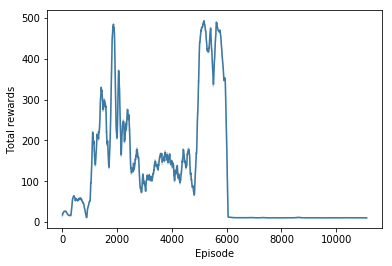

In [17]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

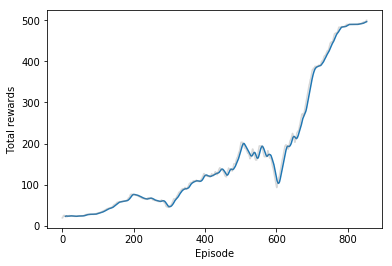

In [19]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

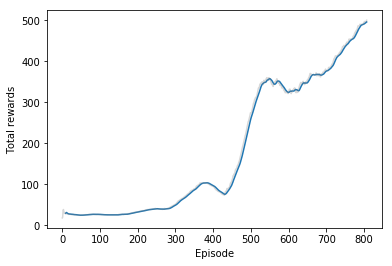

In [17]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

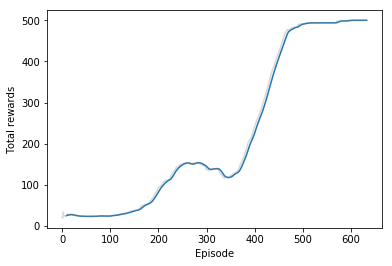

In [19]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

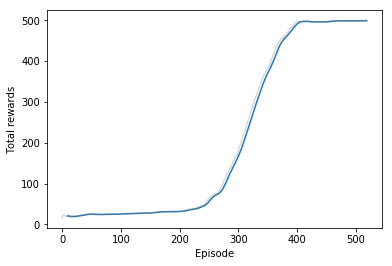

In [17]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

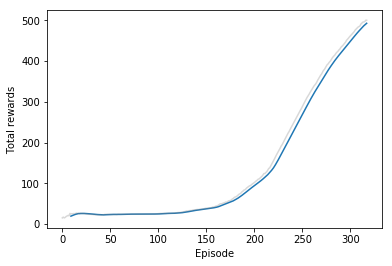

In [22]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

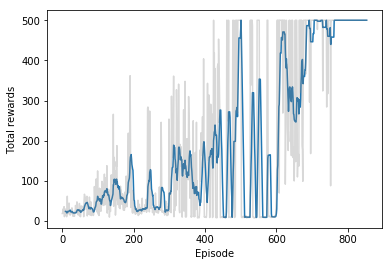

In [20]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

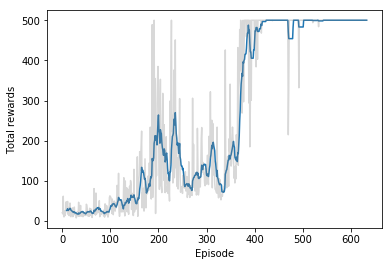

In [20]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

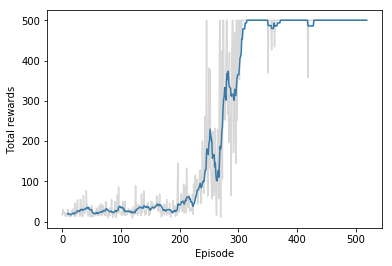

In [18]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

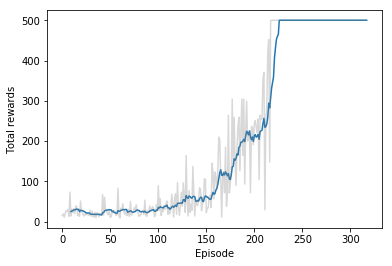

In [23]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Act losses')

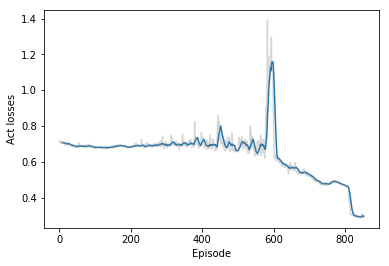

In [21]:
eps, arr = np.array(aloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses')

Text(0, 0.5, 'Act losses')

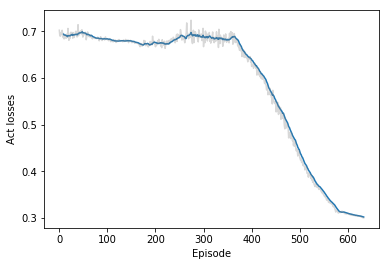

In [21]:
eps, arr = np.array(aloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses')

Text(0, 0.5, 'Act losses')

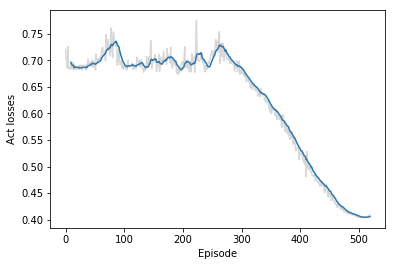

In [19]:
eps, arr = np.array(aloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses')

Text(0, 0.5, 'Act losses')

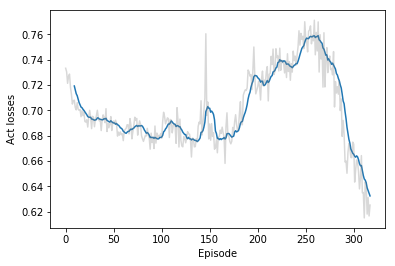

In [24]:
eps, arr = np.array(aloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses')

Text(0, 0.5, 'Env losses')

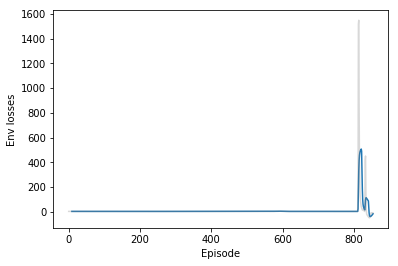

In [22]:
eps, arr = np.array(eloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Env losses')

Text(0, 0.5, 'Env losses')

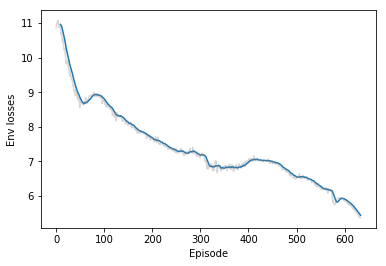

In [22]:
eps, arr = np.array(eloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Env losses')

Text(0, 0.5, 'Env losses')

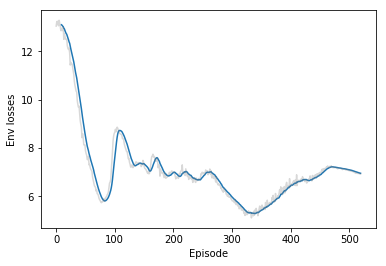

In [20]:
eps, arr = np.array(eloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Env losses')

Text(0, 0.5, 'Env losses')

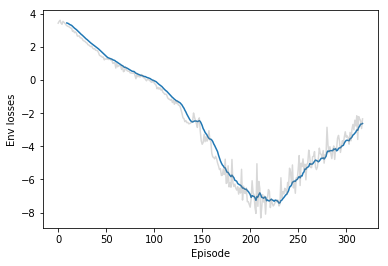

In [25]:
eps, arr = np.array(eloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Env losses')

Text(0, 0.5, 'Act losses 2')

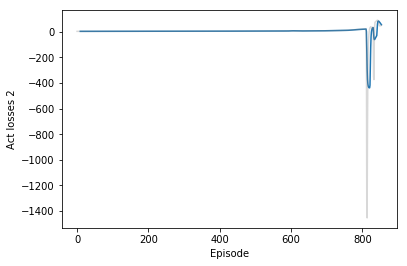

In [23]:
eps, arr = np.array(aloss2_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses 2')

Text(0, 0.5, 'Act losses 2')

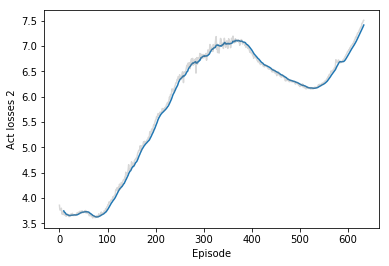

In [23]:
eps, arr = np.array(aloss2_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses 2')

Text(0, 0.5, 'Act losses 2')

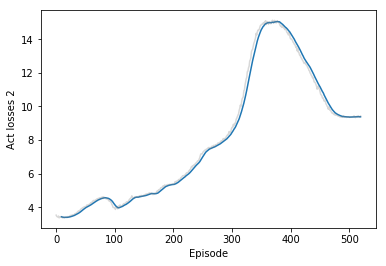

In [21]:
eps, arr = np.array(aloss2_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses 2')

Text(0, 0.5, 'Act losses 2')

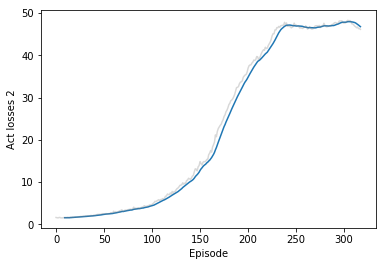

In [26]:
eps, arr = np.array(aloss2_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses 2')

## Testing

Let's checkout how our trained agent plays the game.

In [21]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
